# Optimization of RC macro parameters using Differential Evolution algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
import sys

sys.path.insert(0, '..')
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=1000, lr=0.1, sr=0.8)
readout = Ridge(output_dim=3, ridge=1e-4)
esn = reservoir >> readout

#from ddc import DataLorenz63 as DataModel
from dabench import data
from scipy.optimize import differential_evolution

plt.style.use('seaborn')

/tmp/ipykernel_124010/599857742.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Generate training, validation, and test data

In [2]:
system_dimension = 6
delta_t = 1e-2
time_dimension_train=20000
time_dimension_transient=1000
time_dimension_test=2000 
noise = 0.0

l96 = data.Lorenz96(delta_t = delta_t, system_dim = system_dimension)
l96.generate(n_steps = 23000)


In [5]:
# Initialize list of forecasts for training macro parameters
valid_data_arr = []
n_valid = 50     # Number of randomly initialized validation forecasts to test
forecast_length = 5 # model time units
for i in range(n_valid):
    ridx = np.random.randint(time_dimension_train)
    valid_data = data.Lorenz96(x0 = l96.values[ridx],delta_t = delta_t, system_dim = system_dimension)
    # Choose random starting point from training set to make a forecast
    ridx = np.random.randint(time_dimension_train)
    x0 = l96.values[ridx,:]
    # Replace with new initial run as validation data
    valid_data.generate(t_final=forecast_length)
    valid_data_arr.append(deepcopy(valid_data))
    
#print(valid_data)

# Define Loss Function

The loss function takes in a list of parameters as well as training and validation data and spits out a scalar loss.  In the loss functions we:

1. build a new reservoir with the given hyperparameters

2. predict over the validation examples

3. take the MSE over all the validation sets and sum the losses into 1 scalar


In [6]:

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
 
def objective(input_parameters , train_data, valid_data_list, pred_time=5, scale_diff=True, plot=False, printout=False):
    system_dimension = train_data.system_dim
    sparsity = 0.99
    tikhonov_parameter = 0.1
    sigma, leak_rate, spectral_radius, reservoir_dimension = input_parameters
    n_valid = len(valid_data_list)
    
    reservoir = Reservoir( int(np.rint(reservoir_dimension)),
                          sr=spectral_radius,
                          input_scaling=sigma,
                          connectivity = 1 - sparsity,
                          lr=leak_rate,
                          seed=1111)
    
    ridge = Ridge(output_dim = 6, ridge = 0.0)
    
    esn = reservoir >> ridge


    # Create and train RC model
    esn.fit(train_data.values[:-1], train_data.values[1:], warmup=200)
    
    if printout:
        print('sigma={}, leak_rate={}, spectral_radius={}, reservoir_dimension={}'.format(sigma, leak_rate, spectral_radius, reservoir_dimension))
    
    MSE = np.zeros(n_valid)

    
    for i, valid_data in enumerate(valid_data_list):
        # Generate the true trajectory
        # Initialize general object for generating model data
        dataobj = data.Lorenz96(x0 = valid_data.values[0, :], delta_t = delta_t, system_dim = system_dimension)
        dataobj.generate(t_final=pred_time)
        
        # Get the true values        print(dataobj)

        # Get the true values
        u_true = dataobj.values[:,:]

        # ESN trained
        esn_trained = deepcopy(esn)
        
        # Make a model prediction for the specified forecast horizon
        pred_steps = int(pred_time/train_data.delta_t)
        pred = [dataobj.x0]
        for j in range(pred_steps):
            pred.append(esn_trained.call(pred[-1])[0])
        pred = np.array(pred)

        # Get the predicted values
        u_pred = pred[:-1]
        
        # Compute the forecast MSE\n",
        diff = (u_true - u_pred)
        
        # Scale the difference over time\n",
        if (scale_diff):
            scaling_arg = np.arange(0,1,1/diff.shape[1])
            diff_scaling = np.exp(-scaling_arg)
            diff = diff * diff_scaling

        # Compute the forecast MSE
        MSE[i] = np.linalg.norm(diff)**2/len(pred)
        
        if plot:
            fig, axes = plt.subplots(system_dimension, 1, sharex = True, figsize = (10, 8))
            for i, ax in enumerate(axes):
                ax.plot(u_true[:,i], lw = 3, label = 'True')
                ax.plot(u_pred[:,i], lw = 3, ls = '--', label = 'Pred')
                ax.axvline(0,color = 'k', lw = 2)
    
                ax.set_ylabel(r'$x_{:d}$'.format(i), fontsize = 16)
            axes[0].set_title('Prediction', fontsize = 22)
            plt.legend()
    return np.sum(MSE)/n_valid, pred

This is quite an expensive loss function, taking about almost a minute to evaluate.  Therefore computing this function is the most computationally intensive part of the optimization and reducing the number of function evaluations is key to finding a good minimum efficiently.

In [7]:
# Index for focus valid_data_array
vidx = 0

Running Model-1:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-1: 51it [00:00, 501.26it/s]                                                                 
Running Model-1: 102it [00:00, 472.22it/s]
Running Model-1: 150it [00:00, 475.43it/s]
Running Model-1: 214it [00:00, 532.61it/s]
Running Model-1: 278it [00:00, 568.87it/s]
Running Model-1: 339it [00:00, 581.59it/s]
Running Model-1: 401it [00:00, 591.88it/s]
Running Model-1: 461it [00:00, 564.33it/s]
Running Model-1: 518it [00:00, 514.42it/s]
Running Model-1: 571it [00:01, 482.50it/s]
Running Model-1: 621it [00:01, 481.59it/s]
Running Model-1: 670it [00:01, 482.89it/s]
Running Model-1: 719it [00:01, 484.35it/s]
Running Model-1: 769it [00:01, 486.66it/s]
Running Model-1: 818it [00:01, 487.45it/s]
Running Model-1: 867it [00:01, 487.40it/s]
Running Model-1: 916it [00:01, 484.11it/s]
Running Model-1: 965it [00:01, 475.23it/s]
Running Model-1: 1013it [00:02, 459.47it/s]
Running Mod

Running Model-1: 8225it [00:17, 555.15it/s]
Running Model-1: 8282it [00:17, 557.88it/s]
Running Model-1: 8343it [00:18, 570.85it/s]
Running Model-1: 8401it [00:18, 568.88it/s]
Running Model-1: 8458it [00:18, 563.42it/s]
Running Model-1: 8515it [00:18, 560.49it/s]
Running Model-1: 8579it [00:18, 581.11it/s]
Running Model-1: 8638it [00:18, 579.61it/s]
Running Model-1: 8696it [00:18, 570.62it/s]
Running Model-1: 8754it [00:18, 553.84it/s]
Running Model-1: 8810it [00:18, 526.02it/s]
Running Model-1: 8863it [00:18, 516.46it/s]
Running Model-1: 8915it [00:19, 513.42it/s]
Running Model-1: 8981it [00:19, 553.99it/s]
Running Model-1: 9045it [00:19, 576.04it/s]
Running Model-1: 9103it [00:19, 562.76it/s]
Running Model-1: 9160it [00:19, 549.01it/s]
Running Model-1: 9216it [00:19, 524.82it/s]
Running Model-1: 9271it [00:19, 530.83it/s]
Running Model-1: 9326it [00:19, 535.09it/s]
Running Model-1: 9390it [00:19, 564.61it/s]
Running Model-1: 9455it [00:20, 588.51it/s]
Running Model-1: 9524it [00:20, 

Running Model-1: 19089it [00:35, 657.26it/s]
Running Model-1: 19155it [00:35, 655.49it/s]
Running Model-1: 19221it [00:35, 651.75it/s]
Running Model-1: 19287it [00:36, 653.66it/s]
Running Model-1: 19353it [00:36, 647.99it/s]
Running Model-1: 19422it [00:36, 659.14it/s]
Running Model-1: 19488it [00:36, 643.23it/s]
Running Model-1: 19554it [00:36, 644.99it/s]
Running Model-1: 19620it [00:36, 647.60it/s]
Running Model-1: 19689it [00:36, 659.31it/s]
Running Model-1: 19760it [00:36, 672.88it/s]
Running Model-1: 19830it [00:36, 679.08it/s]
Running Model-1: 19898it [00:36, 672.81it/s]
Running Model-1: 19966it [00:37, 643.21it/s]
Running Model-1: 20032it [00:37, 647.23it/s]
Running Model-1: 20098it [00:37, 648.33it/s]
Running Model-1: 20163it [00:37, 635.86it/s]
Running Model-1: 20227it [00:37, 583.52it/s]
Running Model-1: 20287it [00:37, 558.10it/s]
Running Model-1: 20347it [00:37, 568.26it/s]
Running Model-1: 20408it [00:37, 579.56it/s]
Running Model-1: 20478it [00:37, 612.70it/s]
Running Mo

Fitting node Ridge-1...


/home/ksolvik/miniconda3/envs/dab-installed-reservoirpy/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.09445e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


CPU times: user 1min 13s, sys: 56.8 s, total: 2min 10s
Wall time: 1min 4s


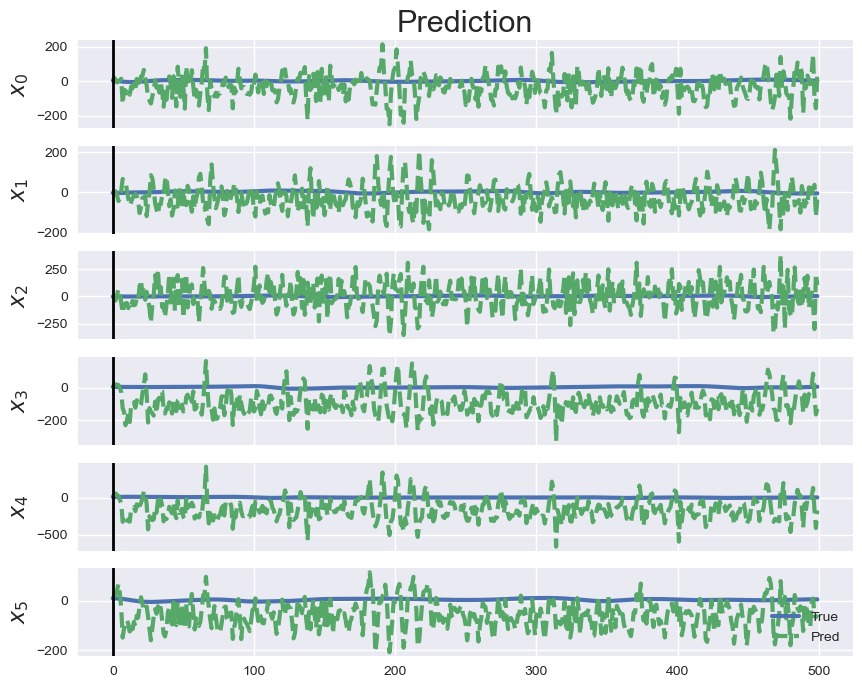

In [9]:
%%time
#sigma, leak_rate, spectral_radius, reservoir_dimension
input_parameters = 3.98034774e-02,  7.51916474e-01,  7.42573828e-01, 2.44700000e+03
# input_parameters = 4.11085572-02, 1.55577679e-01, 7.57555812e-01, 1.17514147e+03
# input_parameters = 1.0, 0.1, 0.8, 1000
mse, pred = objective(input_parameters, l96, [valid_data_arr[vidx]], plot=True, pred_time=5)

In [10]:
mse

35233.25682628505

## Initial guess is not great

We make an initial guess of the RC macro parameters to see how we do. As expected, this guess performs quite poorly

# Let's take a look at the loss function landscape

Just to get a feel for the landscape we do a grid search over a couple of the parameters.  This takes a very long time and is the reason we can't just do a grid search over the whole space.  The landscape has many local minima rendering a local method useless.

In [119]:
sigma = np.arange(0.01, 1.0, 0.1) #[0.2]
leak_rate = [0.8] #np.arange(0, 1, 0.1)
spectral_radius = np.arange(0.01, 1.0, 0.1) #[0.5]
#tikhonov_parameter = [0.1]
reservoir_dimension = [888]
#sparsity = [0.195]

params_list = list(itertools.product(sigma, leak_rate, spectral_radius, reservoir_dimension))

In [120]:
len(params_list), len(leak_rate), len(spectral_radius)

(100, 1, 10)

In [122]:
%%time
loss_arr = []
for params in params_list:
    loss_arr.append(objective(params, l96, [valid_data_arr[vidx]], pred_time=5)[0])
loss_arr = np.array(loss_arr)

Running Model-20:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-20: 115it [00:00, 1149.43it/s]                                                              
Running Model-20: 278it [00:00, 1428.20it/s]
Running Model-20: 434it [00:00, 1477.61it/s]
Running Model-20: 591it [00:00, 1511.23it/s]
Running Model-20: 743it [00:00, 1513.05it/s]
Running Model-20: 896it [00:00, 1515.57it/s]
Running Model-20: 1057it [00:00, 1545.03it/s]
Running Model-20: 1241it [00:00, 1637.24it/s]
Running Model-20: 1444it [00:00, 1758.43it/s]
Running Model-20: 1643it [00:01, 1827.80it/s]
Running Model-20: 1847it [00:01, 1891.82it/s]
Running Model-20: 2037it [00:01, 1718.27it/s]
Running Model-20: 2218it [00:01, 1742.85it/s]
Running Model-20: 2423it [00:01, 1830.90it/s]
Running Model-20: 2627it [00:01, 1891.41it/s]
Running Model-20: 2830it [00:01, 1931.66it/s]
Running Model-20: 3030it [00:01, 1950.34it/s]
Running Model-20: 3236it [00:01, 1982.16it/s]
Running M

Fitting node Ridge-20...


Running Model-21:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-21: 193it [00:00, 1921.64it/s]                                                              
Running Model-21: 393it [00:00, 1966.55it/s]
Running Model-21: 601it [00:00, 2017.20it/s]
Running Model-21: 805it [00:00, 2024.97it/s]
Running Model-21: 1008it [00:00, 2020.26it/s]
Running Model-21: 1214it [00:00, 2031.80it/s]
Running Model-21: 1418it [00:00, 2013.56it/s]
Running Model-21: 1624it [00:00, 2027.95it/s]
Running Model-21: 1827it [00:00, 1966.44it/s]
Running Model-21: 2026it [00:01, 1973.44it/s]
Running Model-21: 2225it [00:01, 1976.43it/s]
Running Model-21: 2433it [00:01, 2005.62it/s]
Running Model-21: 2638it [00:01, 2018.43it/s]
Running Model-21: 2840it [00:01, 2005.73it/s]
Running Model-21: 3041it [00:01, 1990.68it/s]
Running Model-21: 3246it [00:01, 2008.26it/s]
Running Model-21: 3447it [00:01, 1970.05it/s]
Running Model-21: 3659it [00:01, 2012.70it/s]
Running

Fitting node Ridge-21...


Running Model-22:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-22: 175it [00:00, 1746.28it/s]                                                              
Running Model-22: 378it [00:00, 1912.76it/s]
Running Model-22: 587it [00:00, 1991.75it/s]
Running Model-22: 795it [00:00, 2024.83it/s]
Running Model-22: 1004it [00:00, 2046.32it/s]
Running Model-22: 1216it [00:00, 2070.03it/s]
Running Model-22: 1424it [00:00, 2030.39it/s]
Running Model-22: 1637it [00:00, 2059.90it/s]
Running Model-22: 1852it [00:00, 2086.65it/s]
Running Model-22: 2068it [00:01, 2108.01it/s]
Running Model-22: 2279it [00:01, 2100.98it/s]
Running Model-22: 2492it [00:01, 2106.72it/s]
Running Model-22: 2703it [00:01, 2066.97it/s]
Running Model-22: 2912it [00:01, 2073.02it/s]
Running Model-22: 3122it [00:01, 2079.49it/s]
Running Model-22: 3337it [00:01, 2098.40it/s]
Running Model-22: 3547it [00:01, 2059.27it/s]
Running Model-22: 3768it [00:01, 2102.78it/s]
Running

Fitting node Ridge-22...


Running Model-23:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-23: 193it [00:00, 1923.88it/s]                                                              
Running Model-23: 401it [00:00, 2015.54it/s]
Running Model-23: 603it [00:00, 2007.93it/s]
Running Model-23: 806it [00:00, 2010.60it/s]
Running Model-23: 1011it [00:00, 2023.88it/s]
Running Model-23: 1221it [00:00, 2048.10it/s]
Running Model-23: 1426it [00:00, 1990.03it/s]
Running Model-23: 1628it [00:00, 1998.98it/s]
Running Model-23: 1839it [00:00, 2031.94it/s]
Running Model-23: 2053it [00:01, 2064.12it/s]
Running Model-23: 2265it [00:01, 2080.88it/s]
Running Model-23: 2474it [00:01, 2059.47it/s]
Running Model-23: 2686it [00:01, 2075.61it/s]
Running Model-23: 2894it [00:01, 2066.02it/s]
Running Model-23: 3101it [00:01, 2064.30it/s]
Running Model-23: 3312it [00:01, 2077.12it/s]
Running Model-23: 3520it [00:01, 2045.43it/s]
Running Model-23: 3725it [00:01, 2040.58it/s]
Running

Fitting node Ridge-23...


Running Model-24:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-24: 191it [00:00, 1908.80it/s]                                                              
Running Model-24: 382it [00:00, 1603.91it/s]
Running Model-24: 583it [00:00, 1769.55it/s]
Running Model-24: 794it [00:00, 1894.13it/s]
Running Model-24: 1004it [00:00, 1964.72it/s]
Running Model-24: 1210it [00:00, 1996.17it/s]
Running Model-24: 1412it [00:00, 1986.21it/s]
Running Model-24: 1619it [00:00, 2010.12it/s]
Running Model-24: 1821it [00:00, 1987.63it/s]
Running Model-24: 2021it [00:01, 1981.24it/s]
Running Model-24: 2220it [00:01, 1920.17it/s]
Running Model-24: 2427it [00:01, 1961.78it/s]
Running Model-24: 2624it [00:01, 1945.96it/s]
Running Model-24: 2827it [00:01, 1969.97it/s]
Running Model-24: 3033it [00:01, 1996.21it/s]
Running Model-24: 3236it [00:01, 2005.82it/s]
Running Model-24: 3437it [00:01, 1993.39it/s]
Running Model-24: 3637it [00:01, 1923.88it/s]
Running

Fitting node Ridge-24...


Running Model-25:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-25: 193it [00:00, 1929.33it/s]                                                              
Running Model-25: 386it [00:00, 1828.60it/s]
Running Model-25: 575it [00:00, 1853.71it/s]
Running Model-25: 770it [00:00, 1889.83it/s]
Running Model-25: 960it [00:00, 1842.01it/s]
Running Model-25: 1150it [00:00, 1858.96it/s]
Running Model-25: 1357it [00:00, 1925.62it/s]
Running Model-25: 1550it [00:00, 1872.32it/s]
Running Model-25: 1738it [00:00, 1858.02it/s]
Running Model-25: 1968it [00:01, 1989.48it/s]
Running Model-25: 2168it [00:01, 1991.26it/s]
Running Model-25: 2368it [00:01, 1988.14it/s]
Running Model-25: 2568it [00:01, 1978.90it/s]
Running Model-25: 2767it [00:01, 1836.41it/s]
Running Model-25: 2953it [00:01, 1662.72it/s]
Running Model-25: 3124it [00:01, 1647.09it/s]
Running Model-25: 3293it [00:01, 1657.24it/s]
Running Model-25: 3461it [00:01, 1661.83it/s]
Running 

Fitting node Ridge-25...


Running Model-26:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-26: 193it [00:00, 1925.91it/s]                                                              
Running Model-26: 386it [00:00, 1596.47it/s]
Running Model-26: 550it [00:00, 1512.86it/s]
Running Model-26: 704it [00:00, 1487.67it/s]
Running Model-26: 906it [00:00, 1662.28it/s]
Running Model-26: 1084it [00:00, 1699.70it/s]
Running Model-26: 1279it [00:00, 1777.45it/s]
Running Model-26: 1459it [00:00, 1710.94it/s]
Running Model-26: 1632it [00:00, 1636.31it/s]
Running Model-26: 1797it [00:01, 1593.09it/s]
Running Model-26: 1963it [00:01, 1612.12it/s]
Running Model-26: 2125it [00:01, 1609.66it/s]
Running Model-26: 2305it [00:01, 1664.17it/s]
Running Model-26: 2522it [00:01, 1811.98it/s]
Running Model-26: 2714it [00:01, 1839.83it/s]
Running Model-26: 2916it [00:01, 1891.67it/s]
Running Model-26: 3125it [00:01, 1949.82it/s]
Running Model-26: 3337it [00:01, 1999.95it/s]
Running 

Fitting node Ridge-26...


Running Model-27:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-27: 181it [00:00, 1805.62it/s]                                                              
Running Model-27: 362it [00:00, 1731.11it/s]
Running Model-27: 538it [00:00, 1735.55it/s]
Running Model-27: 714it [00:00, 1737.76it/s]
Running Model-27: 888it [00:00, 1725.50it/s]
Running Model-27: 1061it [00:00, 1713.37it/s]
Running Model-27: 1233it [00:00, 1708.55it/s]
Running Model-27: 1431it [00:00, 1791.92it/s]
Running Model-27: 1633it [00:00, 1860.72it/s]
Running Model-27: 1840it [00:01, 1923.96it/s]
Running Model-27: 2043it [00:01, 1955.65it/s]
Running Model-27: 2239it [00:01, 1927.14it/s]
Running Model-27: 2445it [00:01, 1965.56it/s]
Running Model-27: 2646it [00:01, 1977.36it/s]
Running Model-27: 2847it [00:01, 1984.88it/s]
Running Model-27: 3048it [00:01, 1990.41it/s]
Running Model-27: 3248it [00:01, 1926.44it/s]
Running Model-27: 3454it [00:01, 1964.57it/s]
Running 

Fitting node Ridge-27...


Running Model-28:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-28: 164it [00:00, 1630.11it/s]                                                              
Running Model-28: 351it [00:00, 1766.97it/s]
Running Model-28: 528it [00:00, 1753.98it/s]
Running Model-28: 717it [00:00, 1805.95it/s]
Running Model-28: 918it [00:00, 1878.44it/s]
Running Model-28: 1116it [00:00, 1911.38it/s]
Running Model-28: 1308it [00:00, 1908.83it/s]
Running Model-28: 1509it [00:00, 1939.31it/s]
Running Model-28: 1703it [00:00, 1903.22it/s]
Running Model-28: 1900it [00:01, 1921.79it/s]
Running Model-28: 2103it [00:01, 1954.07it/s]
Running Model-28: 2303it [00:01, 1966.23it/s]
Running Model-28: 2500it [00:01, 1913.36it/s]
Running Model-28: 2692it [00:01, 1878.63it/s]
Running Model-28: 2883it [00:01, 1887.77it/s]
Running Model-28: 3079it [00:01, 1908.59it/s]
Running Model-28: 3271it [00:01, 1909.09it/s]
Running Model-28: 3463it [00:01, 1907.59it/s]
Running 

Fitting node Ridge-28...


Running Model-29:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-29: 192it [00:00, 1911.92it/s]                                                              
Running Model-29: 403it [00:00, 2028.16it/s]
Running Model-29: 610it [00:00, 2046.94it/s]
Running Model-29: 822it [00:00, 2073.62it/s]
Running Model-29: 1031it [00:00, 2079.38it/s]
Running Model-29: 1239it [00:00, 2032.77it/s]
Running Model-29: 1443it [00:00, 1991.41it/s]
Running Model-29: 1643it [00:00, 1993.96it/s]
Running Model-29: 1843it [00:00, 1968.10it/s]
Running Model-29: 2048it [00:01, 1992.06it/s]
Running Model-29: 2254it [00:01, 2011.37it/s]
Running Model-29: 2464it [00:01, 2036.35it/s]
Running Model-29: 2677it [00:01, 2062.48it/s]
Running Model-29: 2884it [00:01, 2034.32it/s]
Running Model-29: 3088it [00:01, 2031.10it/s]
Running Model-29: 3292it [00:01, 2025.19it/s]
Running Model-29: 3495it [00:01, 2004.46it/s]
Running Model-29: 3696it [00:01, 1935.16it/s]
Running

Fitting node Ridge-29...


Running Model-30:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-30: 189it [00:00, 1886.43it/s]                                                              
Running Model-30: 399it [00:00, 2007.36it/s]
Running Model-30: 600it [00:00, 1995.13it/s]
Running Model-30: 813it [00:00, 2045.14it/s]
Running Model-30: 1018it [00:00, 1997.44it/s]
Running Model-30: 1219it [00:00, 2001.10it/s]
Running Model-30: 1420it [00:00, 1996.24it/s]
Running Model-30: 1630it [00:00, 2027.57it/s]
Running Model-30: 1833it [00:00, 1973.76it/s]
Running Model-30: 2031it [00:01, 1958.89it/s]
Running Model-30: 2238it [00:01, 1990.48it/s]
Running Model-30: 2438it [00:01, 1936.02it/s]
Running Model-30: 2633it [00:01, 1918.06it/s]
Running Model-30: 2826it [00:01, 1873.59it/s]
Running Model-30: 3014it [00:01, 1856.77it/s]
Running Model-30: 3200it [00:01, 1847.70it/s]
Running Model-30: 3385it [00:01, 1803.10it/s]
Running Model-30: 3574it [00:01, 1827.34it/s]
Running

Fitting node Ridge-30...


Running Model-31:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-31: 173it [00:00, 1723.46it/s]                                                              
Running Model-31: 346it [00:00, 1726.81it/s]
Running Model-31: 540it [00:00, 1823.76it/s]
Running Model-31: 742it [00:00, 1899.25it/s]
Running Model-31: 950it [00:00, 1961.98it/s]
Running Model-31: 1156it [00:00, 1994.81it/s]
Running Model-31: 1356it [00:00, 1957.64it/s]
Running Model-31: 1558it [00:00, 1976.08it/s]
Running Model-31: 1756it [00:00, 1972.65it/s]
Running Model-31: 1960it [00:01, 1992.09it/s]
Running Model-31: 2160it [00:01, 1929.99it/s]
Running Model-31: 2354it [00:01, 1923.84it/s]
Running Model-31: 2565it [00:01, 1976.96it/s]
Running Model-31: 2770it [00:01, 1998.25it/s]
Running Model-31: 2971it [00:01, 1991.73it/s]
Running Model-31: 3173it [00:01, 1998.49it/s]
Running Model-31: 3376it [00:01, 2006.99it/s]
Running Model-31: 3583it [00:01, 2023.44it/s]
Running 

Fitting node Ridge-31...


Running Model-32:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-32: 192it [00:00, 1912.91it/s]                                                              
Running Model-32: 403it [00:00, 2027.23it/s]
Running Model-32: 607it [00:00, 2029.29it/s]
Running Model-32: 811it [00:00, 2033.08it/s]
Running Model-32: 1015it [00:00, 2019.21it/s]
Running Model-32: 1217it [00:00, 2009.79it/s]
Running Model-32: 1426it [00:00, 2035.70it/s]
Running Model-32: 1631it [00:00, 2038.46it/s]
Running Model-32: 1835it [00:00, 1974.55it/s]
Running Model-32: 2035it [00:01, 1980.75it/s]
Running Model-32: 2242it [00:01, 2005.85it/s]
Running Model-32: 2453it [00:01, 2035.52it/s]
Running Model-32: 2660it [00:01, 2041.76it/s]
Running Model-32: 2869it [00:01, 2055.55it/s]
Running Model-32: 3079it [00:01, 2066.80it/s]
Running Model-32: 3286it [00:01, 2060.27it/s]
Running Model-32: 3494it [00:01, 2065.30it/s]
Running Model-32: 3701it [00:01, 2063.48it/s]
Running

Fitting node Ridge-32...


Running Model-33:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-33: 191it [00:00, 1904.82it/s]                                                              
Running Model-33: 400it [00:00, 2011.52it/s]
Running Model-33: 610it [00:00, 2049.56it/s]
Running Model-33: 815it [00:00, 2043.08it/s]
Running Model-33: 1020it [00:00, 2044.32it/s]
Running Model-33: 1225it [00:00, 1986.95it/s]
Running Model-33: 1429it [00:00, 2002.40it/s]
Running Model-33: 1637it [00:00, 2025.18it/s]
Running Model-33: 1840it [00:00, 2008.19it/s]
Running Model-33: 2054it [00:01, 2046.22it/s]
Running Model-33: 2259it [00:01, 1991.94it/s]
Running Model-33: 2465it [00:01, 2010.84it/s]
Running Model-33: 2667it [00:01, 2011.91it/s]
Running Model-33: 2872it [00:01, 2021.41it/s]
Running Model-33: 3080it [00:01, 2037.07it/s]
Running Model-33: 3286it [00:01, 2043.56it/s]
Running Model-33: 3491it [00:01, 2042.63it/s]
Running Model-33: 3696it [00:01, 2044.28it/s]
Running

Fitting node Ridge-33...


Running Model-34:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-34: 182it [00:00, 1815.02it/s]                                                              
Running Model-34: 364it [00:00, 1725.70it/s]
Running Model-34: 548it [00:00, 1774.71it/s]
Running Model-34: 739it [00:00, 1826.23it/s]
Running Model-34: 922it [00:00, 1823.03it/s]
Running Model-34: 1112it [00:00, 1848.84it/s]
Running Model-34: 1298it [00:00, 1825.45it/s]
Running Model-34: 1501it [00:00, 1889.29it/s]
Running Model-34: 1711it [00:00, 1952.86it/s]
Running Model-34: 1915it [00:01, 1978.29it/s]
Running Model-34: 2121it [00:01, 2001.01it/s]
Running Model-34: 2333it [00:01, 2036.10it/s]
Running Model-34: 2543it [00:01, 2054.97it/s]
Running Model-34: 2749it [00:01, 2045.09it/s]
Running Model-34: 2958it [00:01, 2058.22it/s]
Running Model-34: 3165it [00:01, 2059.96it/s]
Running Model-34: 3372it [00:01, 2055.20it/s]
Running Model-34: 3578it [00:01, 2052.39it/s]
Running 

Fitting node Ridge-34...


Running Model-35:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-35: 189it [00:00, 1881.31it/s]                                                              
Running Model-35: 397it [00:00, 1994.92it/s]
Running Model-35: 597it [00:00, 1974.44it/s]
Running Model-35: 795it [00:00, 1960.61it/s]
Running Model-35: 995it [00:00, 1972.83it/s]
Running Model-35: 1203it [00:00, 2007.09it/s]
Running Model-35: 1404it [00:00, 1987.09it/s]
Running Model-35: 1612it [00:00, 2015.32it/s]
Running Model-35: 1818it [00:00, 2027.89it/s]
Running Model-35: 2021it [00:01, 1985.80it/s]
Running Model-35: 2220it [00:01, 1985.80it/s]
Running Model-35: 2419it [00:01, 1979.72it/s]
Running Model-35: 2618it [00:01, 1955.11it/s]
Running Model-35: 2814it [00:01, 1920.16it/s]
Running Model-35: 3007it [00:01, 1921.70it/s]
Running Model-35: 3209it [00:01, 1949.84it/s]
Running Model-35: 3405it [00:01, 1951.00it/s]
Running Model-35: 3606it [00:01, 1967.30it/s]
Running 

Fitting node Ridge-35...


Running Model-36:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-36: 191it [00:00, 1902.57it/s]                                                              
Running Model-36: 389it [00:00, 1946.43it/s]
Running Model-36: 604it [00:00, 2037.52it/s]
Running Model-36: 815it [00:00, 2065.41it/s]
Running Model-36: 1026it [00:00, 2079.32it/s]
Running Model-36: 1235it [00:00, 2081.93it/s]
Running Model-36: 1444it [00:00, 2075.95it/s]
Running Model-36: 1652it [00:00, 2035.30it/s]
Running Model-36: 1856it [00:00, 2008.26it/s]
Running Model-36: 2061it [00:01, 2019.12it/s]
Running Model-36: 2266it [00:01, 2026.91it/s]
Running Model-36: 2469it [00:01, 1994.23it/s]
Running Model-36: 2673it [00:01, 2007.08it/s]
Running Model-36: 2887it [00:01, 2044.32it/s]
Running Model-36: 3097it [00:01, 2058.38it/s]
Running Model-36: 3303it [00:01, 2046.24it/s]
Running Model-36: 3508it [00:01, 2004.93it/s]
Running Model-36: 3714it [00:01, 2020.41it/s]
Running

Fitting node Ridge-36...


Running Model-37:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-37: 190it [00:00, 1898.56it/s]                                                              
Running Model-37: 396it [00:00, 1992.12it/s]
Running Model-37: 596it [00:00, 1994.56it/s]
Running Model-37: 808it [00:00, 2043.15it/s]
Running Model-37: 1013it [00:00, 2038.35it/s]
Running Model-37: 1219it [00:00, 2041.55it/s]
Running Model-37: 1428it [00:00, 2056.90it/s]
Running Model-37: 1640it [00:00, 2074.96it/s]
Running Model-37: 1848it [00:00, 2062.65it/s]
Running Model-37: 2056it [00:01, 2066.14it/s]
Running Model-37: 2263it [00:01, 1939.38it/s]
Running Model-37: 2459it [00:01, 1888.71it/s]
Running Model-37: 2654it [00:01, 1904.34it/s]
Running Model-37: 2864it [00:01, 1960.25it/s]
Running Model-37: 3073it [00:01, 1996.99it/s]
Running Model-37: 3285it [00:01, 2031.85it/s]
Running Model-37: 3495it [00:01, 2050.35it/s]
Running Model-37: 3706it [00:01, 2066.85it/s]
Running

Fitting node Ridge-37...


Running Model-38:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-38: 182it [00:00, 1819.66it/s]                                                              
Running Model-38: 376it [00:00, 1889.33it/s]
Running Model-38: 571it [00:00, 1914.30it/s]
Running Model-38: 783it [00:00, 1995.09it/s]
Running Model-38: 996it [00:00, 2042.60it/s]
Running Model-38: 1217it [00:00, 2098.53it/s]
Running Model-38: 1427it [00:00, 2067.63it/s]
Running Model-38: 1634it [00:00, 2053.58it/s]
Running Model-38: 1840it [00:00, 2008.31it/s]
Running Model-38: 2055it [00:01, 2050.06it/s]
Running Model-38: 2264it [00:01, 2061.25it/s]
Running Model-38: 2478it [00:01, 2084.34it/s]
Running Model-38: 2692it [00:01, 2099.31it/s]
Running Model-38: 2903it [00:01, 2085.35it/s]
Running Model-38: 3112it [00:01, 2046.61it/s]
Running Model-38: 3322it [00:01, 2061.68it/s]
Running Model-38: 3533it [00:01, 2074.89it/s]
Running Model-38: 3741it [00:01, 2071.13it/s]
Running 

Fitting node Ridge-38...


Running Model-39:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-39: 188it [00:00, 1879.28it/s]                                                              
Running Model-39: 393it [00:00, 1977.22it/s]
Running Model-39: 598it [00:00, 2009.51it/s]
Running Model-39: 812it [00:00, 2060.16it/s]
Running Model-39: 1027it [00:00, 2092.43it/s]
Running Model-39: 1241it [00:00, 2106.19it/s]
Running Model-39: 1456it [00:00, 2119.33it/s]
Running Model-39: 1674it [00:00, 2137.50it/s]
Running Model-39: 1888it [00:00, 2123.45it/s]
Running Model-39: 2101it [00:01, 2091.71it/s]
Running Model-39: 2311it [00:01, 2093.47it/s]
Running Model-39: 2522it [00:01, 2097.86it/s]
Running Model-39: 2732it [00:01, 2094.96it/s]
Running Model-39: 2944it [00:01, 2102.41it/s]
Running Model-39: 3163it [00:01, 2127.14it/s]
Running Model-39: 3376it [00:01, 2115.23it/s]
Running Model-39: 3588it [00:01, 2066.82it/s]
Running Model-39: 3795it [00:01, 2062.88it/s]
Running

Fitting node Ridge-39...


Running Model-40:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-40: 189it [00:00, 1885.31it/s]                                                              
Running Model-40: 393it [00:00, 1970.73it/s]
Running Model-40: 596it [00:00, 1997.45it/s]
Running Model-40: 796it [00:00, 1954.30it/s]
Running Model-40: 992it [00:00, 1917.95it/s]
Running Model-40: 1184it [00:00, 1918.12it/s]
Running Model-40: 1376it [00:00, 1894.10it/s]
Running Model-40: 1566it [00:00, 1893.91it/s]
Running Model-40: 1769it [00:00, 1933.77it/s]
Running Model-40: 1963it [00:01, 1926.14it/s]
Running Model-40: 2156it [00:01, 1844.63it/s]
Running Model-40: 2342it [00:01, 1830.27it/s]
Running Model-40: 2552it [00:01, 1906.28it/s]
Running Model-40: 2744it [00:01, 1908.90it/s]
Running Model-40: 2939it [00:01, 1920.17it/s]
Running Model-40: 3132it [00:01, 1891.78it/s]
Running Model-40: 3337it [00:01, 1937.77it/s]
Running Model-40: 3539it [00:01, 1960.31it/s]
Running 

Fitting node Ridge-40...


Running Model-41:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-41: 174it [00:00, 1731.67it/s]                                                              
Running Model-41: 351it [00:00, 1752.34it/s]
Running Model-41: 568it [00:00, 1942.54it/s]
Running Model-41: 779it [00:00, 2007.81it/s]
Running Model-41: 990it [00:00, 2044.28it/s]
Running Model-41: 1195it [00:00, 2037.61it/s]
Running Model-41: 1399it [00:00, 2003.65it/s]
Running Model-41: 1615it [00:00, 2052.44it/s]
Running Model-41: 1831it [00:00, 2084.28it/s]
Running Model-41: 2046it [00:01, 2102.97it/s]
Running Model-41: 2257it [00:01, 2096.71it/s]
Running Model-41: 2467it [00:01, 2074.92it/s]
Running Model-41: 2675it [00:01, 2075.18it/s]
Running Model-41: 2888it [00:01, 2091.42it/s]
Running Model-41: 3098it [00:01, 2074.94it/s]
Running Model-41: 3306it [00:01, 2066.30it/s]
Running Model-41: 3513it [00:01, 2059.53it/s]
Running Model-41: 3720it [00:01, 2060.27it/s]
Running 

Fitting node Ridge-41...


Running Model-42:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-42: 180it [00:00, 1792.23it/s]                                                              
Running Model-42: 360it [00:00, 1679.01it/s]
Running Model-42: 537it [00:00, 1716.85it/s]
Running Model-42: 738it [00:00, 1828.65it/s]
Running Model-42: 938it [00:00, 1887.25it/s]
Running Model-42: 1141it [00:00, 1934.00it/s]
Running Model-42: 1347it [00:00, 1972.66it/s]
Running Model-42: 1545it [00:00, 1948.40it/s]
Running Model-42: 1746it [00:00, 1966.73it/s]
Running Model-42: 1946it [00:01, 1974.92it/s]
Running Model-42: 2152it [00:01, 1999.27it/s]
Running Model-42: 2353it [00:01, 1961.53it/s]
Running Model-42: 2550it [00:01, 1919.85it/s]
Running Model-42: 2743it [00:01, 1918.87it/s]
Running Model-42: 2939it [00:01, 1929.15it/s]
Running Model-42: 3135it [00:01, 1936.32it/s]
Running Model-42: 3340it [00:01, 1969.39it/s]
Running Model-42: 3545it [00:01, 1991.98it/s]
Running 

Fitting node Ridge-42...


Running Model-43:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-43: 190it [00:00, 1895.57it/s]                                                              
Running Model-43: 402it [00:00, 2019.60it/s]
Running Model-43: 619it [00:00, 2086.35it/s]
Running Model-43: 838it [00:00, 2125.74it/s]
Running Model-43: 1051it [00:00, 2126.63it/s]
Running Model-43: 1264it [00:00, 2094.05it/s]
Running Model-43: 1474it [00:00, 2079.95it/s]
Running Model-43: 1683it [00:00, 2061.23it/s]
Running Model-43: 1891it [00:00, 2065.62it/s]
Running Model-43: 2098it [00:01, 2035.56it/s]
Running Model-43: 2302it [00:01, 1998.77it/s]
Running Model-43: 2504it [00:01, 2003.93it/s]
Running Model-43: 2705it [00:01, 1998.42it/s]
Running Model-43: 2907it [00:01, 2001.67it/s]
Running Model-43: 3113it [00:01, 2018.40it/s]
Running Model-43: 3320it [00:01, 2033.71it/s]
Running Model-43: 3524it [00:01, 2021.02it/s]
Running Model-43: 3728it [00:01, 2024.99it/s]
Running

Fitting node Ridge-43...


Running Model-44:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-44: 188it [00:00, 1872.62it/s]                                                              
Running Model-44: 383it [00:00, 1913.41it/s]
Running Model-44: 580it [00:00, 1938.78it/s]
Running Model-44: 784it [00:00, 1976.10it/s]
Running Model-44: 986it [00:00, 1990.28it/s]
Running Model-44: 1188it [00:00, 1998.45it/s]
Running Model-44: 1388it [00:00, 1990.47it/s]
Running Model-44: 1588it [00:00, 1981.46it/s]
Running Model-44: 1794it [00:00, 2003.79it/s]
Running Model-44: 1995it [00:01, 1983.22it/s]
Running Model-44: 2199it [00:01, 1997.66it/s]
Running Model-44: 2404it [00:01, 2013.35it/s]
Running Model-44: 2614it [00:01, 2039.19it/s]
Running Model-44: 2818it [00:01, 2038.93it/s]
Running Model-44: 3022it [00:01, 2033.98it/s]
Running Model-44: 3228it [00:01, 2039.44it/s]
Running Model-44: 3433it [00:01, 2041.33it/s]
Running Model-44: 3639it [00:01, 2046.18it/s]
Running 

Fitting node Ridge-44...


Running Model-45:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-45: 190it [00:00, 1893.02it/s]                                                              
Running Model-45: 397it [00:00, 1993.37it/s]
Running Model-45: 609it [00:00, 2047.56it/s]
Running Model-45: 827it [00:00, 2096.55it/s]
Running Model-45: 1040it [00:00, 2106.47it/s]
Running Model-45: 1251it [00:00, 2086.06it/s]
Running Model-45: 1460it [00:00, 2076.92it/s]
Running Model-45: 1668it [00:00, 2020.18it/s]
Running Model-45: 1878it [00:00, 2042.38it/s]
Running Model-45: 2100it [00:01, 2092.95it/s]
Running Model-45: 2318it [00:01, 2117.57it/s]
Running Model-45: 2530it [00:01, 2104.54it/s]
Running Model-45: 2743it [00:01, 2111.99it/s]
Running Model-45: 2955it [00:01, 2094.02it/s]
Running Model-45: 3170it [00:01, 2109.78it/s]
Running Model-45: 3382it [00:01, 2052.14it/s]
Running Model-45: 3588it [00:01, 2033.45it/s]
Running Model-45: 3792it [00:01, 1995.57it/s]
Running

Fitting node Ridge-45...


Running Model-46:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-46: 190it [00:00, 1896.64it/s]                                                              
Running Model-46: 391it [00:00, 1962.04it/s]
Running Model-46: 603it [00:00, 2032.28it/s]
Running Model-46: 807it [00:00, 1994.37it/s]
Running Model-46: 1007it [00:00, 1942.89it/s]
Running Model-46: 1208it [00:00, 1964.77it/s]
Running Model-46: 1423it [00:00, 2021.80it/s]
Running Model-46: 1632it [00:00, 2040.89it/s]
Running Model-46: 1843it [00:00, 2061.64it/s]
Running Model-46: 2051it [00:01, 2067.21it/s]
Running Model-46: 2258it [00:01, 2065.72it/s]
Running Model-46: 2467it [00:01, 2071.09it/s]
Running Model-46: 2677it [00:01, 2077.72it/s]
Running Model-46: 2885it [00:01, 2069.49it/s]
Running Model-46: 3092it [00:01, 2041.62it/s]
Running Model-46: 3300it [00:01, 2051.81it/s]
Running Model-46: 3506it [00:01, 2015.36it/s]
Running Model-46: 3710it [00:01, 2020.83it/s]
Running

Fitting node Ridge-46...


Running Model-47:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-47: 189it [00:00, 1887.85it/s]                                                              
Running Model-47: 399it [00:00, 2005.46it/s]
Running Model-47: 610it [00:00, 2052.43it/s]
Running Model-47: 816it [00:00, 2055.34it/s]
Running Model-47: 1024it [00:00, 2063.85it/s]
Running Model-47: 1231it [00:00, 2060.78it/s]
Running Model-47: 1441it [00:00, 2072.50it/s]
Running Model-47: 1649it [00:00, 2073.56it/s]
Running Model-47: 1857it [00:00, 2070.26it/s]
Running Model-47: 2070it [00:01, 2085.50it/s]
Running Model-47: 2283it [00:01, 2097.60it/s]
Running Model-47: 2496it [00:01, 2106.46it/s]
Running Model-47: 2713it [00:01, 2124.85it/s]
Running Model-47: 2926it [00:01, 2088.48it/s]
Running Model-47: 3135it [00:01, 2059.07it/s]
Running Model-47: 3343it [00:01, 2064.57it/s]
Running Model-47: 3552it [00:01, 2071.94it/s]
Running Model-47: 3760it [00:01, 2059.70it/s]
Running

Fitting node Ridge-47...


Running Model-48:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-48: 189it [00:00, 1885.00it/s]                                                              
Running Model-48: 401it [00:00, 2022.62it/s]
Running Model-48: 604it [00:00, 1970.89it/s]
Running Model-48: 803it [00:00, 1978.18it/s]
Running Model-48: 1018it [00:00, 2037.64it/s]
Running Model-48: 1222it [00:00, 2037.66it/s]
Running Model-48: 1429it [00:00, 2046.15it/s]
Running Model-48: 1634it [00:00, 2043.02it/s]
Running Model-48: 1839it [00:00, 2014.14it/s]
Running Model-48: 2046it [00:01, 2030.37it/s]
Running Model-48: 2261it [00:01, 2065.66it/s]
Running Model-48: 2474it [00:01, 2084.84it/s]
Running Model-48: 2683it [00:01, 2065.63it/s]
Running Model-48: 2890it [00:01, 2046.96it/s]
Running Model-48: 3099it [00:01, 2059.03it/s]
Running Model-48: 3305it [00:01, 2050.79it/s]
Running Model-48: 3511it [00:01, 2039.15it/s]
Running Model-48: 3715it [00:01, 2006.57it/s]
Running

Fitting node Ridge-48...


Running Model-49:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-49: 186it [00:00, 1859.63it/s]                                                              
Running Model-49: 387it [00:00, 1942.12it/s]
Running Model-49: 582it [00:00, 1910.25it/s]
Running Model-49: 774it [00:00, 1907.01it/s]
Running Model-49: 967it [00:00, 1914.72it/s]
Running Model-49: 1165it [00:00, 1935.98it/s]
Running Model-49: 1368it [00:00, 1966.43it/s]
Running Model-49: 1578it [00:00, 2007.38it/s]
Running Model-49: 1790it [00:00, 2042.33it/s]
Running Model-49: 1995it [00:01, 2041.92it/s]
Running Model-49: 2200it [00:01, 2033.12it/s]
Running Model-49: 2404it [00:01, 1959.81it/s]
Running Model-49: 2601it [00:01, 1961.75it/s]
Running Model-49: 2812it [00:01, 2003.74it/s]
Running Model-49: 3030it [00:01, 2054.32it/s]
Running Model-49: 3236it [00:01, 2026.63it/s]
Running Model-49: 3439it [00:01, 1940.35it/s]
Running Model-49: 3634it [00:01, 1906.32it/s]
Running 

Fitting node Ridge-49...


Running Model-50:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-50: 163it [00:00, 1623.92it/s]                                                              
Running Model-50: 364it [00:00, 1846.45it/s]
Running Model-50: 558it [00:00, 1888.19it/s]
Running Model-50: 756it [00:00, 1923.86it/s]
Running Model-50: 972it [00:00, 2007.90it/s]
Running Model-50: 1185it [00:00, 2048.14it/s]
Running Model-50: 1403it [00:00, 2089.37it/s]
Running Model-50: 1614it [00:00, 2094.63it/s]
Running Model-50: 1828it [00:00, 2106.66it/s]
Running Model-50: 2039it [00:01, 2038.97it/s]
Running Model-50: 2250it [00:01, 2060.08it/s]
Running Model-50: 2457it [00:01, 2053.46it/s]
Running Model-50: 2664it [00:01, 2055.47it/s]
Running Model-50: 2877it [00:01, 2076.19it/s]
Running Model-50: 3097it [00:01, 2112.01it/s]
Running Model-50: 3318it [00:01, 2141.25it/s]
Running Model-50: 3543it [00:01, 2169.06it/s]
Running Model-50: 3760it [00:01, 2121.19it/s]
Running 

Fitting node Ridge-50...


Running Model-51:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-51: 191it [00:00, 1904.51it/s]                                                              
Running Model-51: 389it [00:00, 1948.53it/s]
Running Model-51: 592it [00:00, 1984.02it/s]
Running Model-51: 791it [00:00, 1975.15it/s]
Running Model-51: 997it [00:00, 2004.14it/s]
Running Model-51: 1211it [00:00, 2047.81it/s]
Running Model-51: 1419it [00:00, 2057.26it/s]
Running Model-51: 1627it [00:00, 2063.65it/s]
Running Model-51: 1837it [00:00, 2074.50it/s]
Running Model-51: 2045it [00:01, 2073.32it/s]
Running Model-51: 2259it [00:01, 2093.56it/s]
Running Model-51: 2471it [00:01, 2100.80it/s]
Running Model-51: 2684it [00:01, 2108.23it/s]
Running Model-51: 2895it [00:01, 2103.31it/s]
Running Model-51: 3106it [00:01, 2103.64it/s]
Running Model-51: 3317it [00:01, 2091.96it/s]
Running Model-51: 3527it [00:01, 2086.47it/s]
Running Model-51: 3736it [00:01, 2076.13it/s]
Running 

Fitting node Ridge-51...


Running Model-52:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-52: 188it [00:00, 1874.58it/s]                                                              
Running Model-52: 384it [00:00, 1920.17it/s]
Running Model-52: 583it [00:00, 1950.44it/s]
Running Model-52: 780it [00:00, 1955.82it/s]
Running Model-52: 978it [00:00, 1962.97it/s]
Running Model-52: 1175it [00:00, 1948.58it/s]
Running Model-52: 1370it [00:00, 1948.20it/s]
Running Model-52: 1571it [00:00, 1966.87it/s]
Running Model-52: 1771it [00:00, 1976.95it/s]
Running Model-52: 1969it [00:01, 1927.52it/s]
Running Model-52: 2167it [00:01, 1942.41it/s]
Running Model-52: 2363it [00:01, 1947.33it/s]
Running Model-52: 2559it [00:01, 1950.90it/s]
Running Model-52: 2758it [00:01, 1961.65it/s]
Running Model-52: 2955it [00:01, 1947.03it/s]
Running Model-52: 3150it [00:01, 1912.59it/s]
Running Model-52: 3351it [00:01, 1940.96it/s]
Running Model-52: 3557it [00:01, 1975.00it/s]
Running 

Fitting node Ridge-52...


Running Model-53:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-53: 150it [00:00, 1495.28it/s]                                                              
Running Model-53: 355it [00:00, 1820.67it/s]
Running Model-53: 564it [00:00, 1942.67it/s]
Running Model-53: 769it [00:00, 1982.38it/s]
Running Model-53: 970it [00:00, 1991.67it/s]
Running Model-53: 1170it [00:00, 1955.23it/s]
Running Model-53: 1366it [00:00, 1955.08it/s]
Running Model-53: 1570it [00:00, 1981.34it/s]
Running Model-53: 1777it [00:00, 2006.70it/s]
Running Model-53: 1980it [00:01, 2013.76it/s]
Running Model-53: 2182it [00:01, 1961.36it/s]
Running Model-53: 2387it [00:01, 1987.05it/s]
Running Model-53: 2600it [00:01, 2028.60it/s]
Running Model-53: 2805it [00:01, 2033.73it/s]
Running Model-53: 3009it [00:01, 1977.07it/s]
Running Model-53: 3214it [00:01, 1997.18it/s]
Running Model-53: 3419it [00:01, 2011.53it/s]
Running Model-53: 3629it [00:01, 2036.67it/s]
Running 

Fitting node Ridge-53...


Running Model-54:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-54: 189it [00:00, 1886.03it/s]                                                              
Running Model-54: 381it [00:00, 1903.91it/s]
Running Model-54: 572it [00:00, 1898.04it/s]
Running Model-54: 762it [00:00, 1839.56it/s]
Running Model-54: 961it [00:00, 1892.13it/s]
Running Model-54: 1159it [00:00, 1921.14it/s]
Running Model-54: 1357it [00:00, 1939.19it/s]
Running Model-54: 1554it [00:00, 1948.53it/s]
Running Model-54: 1755it [00:00, 1965.55it/s]
Running Model-54: 1959it [00:01, 1987.52it/s]
Running Model-54: 2163it [00:01, 2002.09it/s]
Running Model-54: 2364it [00:01, 1997.26it/s]
Running Model-54: 2564it [00:01, 1978.95it/s]
Running Model-54: 2762it [00:01, 1950.08it/s]
Running Model-54: 2958it [00:01, 1951.25it/s]
Running Model-54: 3170it [00:01, 1999.50it/s]
Running Model-54: 3377it [00:01, 2018.48it/s]
Running Model-54: 3580it [00:01, 2021.54it/s]
Running 

Fitting node Ridge-54...


Running Model-55:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-55: 180it [00:00, 1799.60it/s]                                                              
Running Model-55: 391it [00:00, 1980.61it/s]
Running Model-55: 604it [00:00, 2047.61it/s]
Running Model-55: 813it [00:00, 2063.31it/s]
Running Model-55: 1026it [00:00, 2085.78it/s]
Running Model-55: 1237it [00:00, 2091.92it/s]
Running Model-55: 1452it [00:00, 2108.81it/s]
Running Model-55: 1663it [00:00, 2105.88it/s]
Running Model-55: 1874it [00:00, 2015.41it/s]
Running Model-55: 2080it [00:01, 2028.69it/s]
Running Model-55: 2288it [00:01, 2041.69it/s]
Running Model-55: 2496it [00:01, 2052.79it/s]
Running Model-55: 2702it [00:01, 1908.57it/s]
Running Model-55: 2916it [00:01, 1972.84it/s]
Running Model-55: 3127it [00:01, 2011.97it/s]
Running Model-55: 3335it [00:01, 2029.77it/s]
Running Model-55: 3547it [00:01, 2054.98it/s]
Running Model-55: 3758it [00:01, 2071.04it/s]
Running

Fitting node Ridge-55...


Running Model-56:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-56: 188it [00:00, 1873.00it/s]                                                              
Running Model-56: 393it [00:00, 1970.33it/s]
Running Model-56: 599it [00:00, 2009.06it/s]
Running Model-56: 800it [00:00, 1970.78it/s]
Running Model-56: 998it [00:00, 1956.34it/s]
Running Model-56: 1201it [00:00, 1979.66it/s]
Running Model-56: 1410it [00:00, 2015.07it/s]
Running Model-56: 1619it [00:00, 2036.56it/s]
Running Model-56: 1827it [00:00, 2048.23it/s]
Running Model-56: 2038it [00:01, 2065.77it/s]
Running Model-56: 2245it [00:01, 2014.50it/s]
Running Model-56: 2452it [00:01, 2028.97it/s]
Running Model-56: 2656it [00:01, 2026.74it/s]
Running Model-56: 2873it [00:01, 2069.35it/s]
Running Model-56: 3085it [00:01, 2083.57it/s]
Running Model-56: 3295it [00:01, 2086.42it/s]
Running Model-56: 3504it [00:01, 2084.02it/s]
Running Model-56: 3713it [00:01, 2044.51it/s]
Running 

Fitting node Ridge-56...


Running Model-57:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-57: 188it [00:00, 1879.06it/s]                                                              
Running Model-57: 388it [00:00, 1948.98it/s]
Running Model-57: 599it [00:00, 2021.91it/s]
Running Model-57: 809it [00:00, 2052.51it/s]
Running Model-57: 1015it [00:00, 1983.87it/s]
Running Model-57: 1214it [00:00, 1974.54it/s]
Running Model-57: 1426it [00:00, 2021.06it/s]
Running Model-57: 1632it [00:00, 2032.11it/s]
Running Model-57: 1836it [00:00, 1985.45it/s]
Running Model-57: 2046it [00:01, 2017.86it/s]
Running Model-57: 2255it [00:01, 2039.24it/s]
Running Model-57: 2460it [00:01, 2017.47it/s]
Running Model-57: 2662it [00:01, 2014.08it/s]
Running Model-57: 2864it [00:01, 1990.20it/s]
Running Model-57: 3064it [00:01, 1983.77it/s]
Running Model-57: 3269it [00:01, 2002.56it/s]
Running Model-57: 3477it [00:01, 2025.13it/s]
Running Model-57: 3680it [00:01, 2004.40it/s]
Running

Fitting node Ridge-57...


Running Model-58:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-58: 186it [00:00, 1853.55it/s]                                                              
Running Model-58: 391it [00:00, 1966.48it/s]
Running Model-58: 588it [00:00, 1963.77it/s]
Running Model-58: 787it [00:00, 1973.79it/s]
Running Model-58: 996it [00:00, 2015.30it/s]
Running Model-58: 1206it [00:00, 2044.00it/s]
Running Model-58: 1420it [00:00, 2073.87it/s]
Running Model-58: 1628it [00:00, 2072.57it/s]
Running Model-58: 1840it [00:00, 2086.95it/s]
Running Model-58: 2049it [00:01, 1977.80it/s]
Running Model-58: 2248it [00:01, 1917.12it/s]
Running Model-58: 2448it [00:01, 1940.65it/s]
Running Model-58: 2655it [00:01, 1977.10it/s]
Running Model-58: 2861it [00:01, 2000.66it/s]
Running Model-58: 3069it [00:01, 2023.69it/s]
Running Model-58: 3272it [00:01, 2022.02it/s]
Running Model-58: 3476it [00:01, 2026.49it/s]
Running Model-58: 3684it [00:01, 2041.58it/s]
Running 

Fitting node Ridge-58...


Running Model-59:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-59: 160it [00:00, 1595.28it/s]                                                              
Running Model-59: 320it [00:00, 1550.59it/s]
Running Model-59: 522it [00:00, 1759.10it/s]
Running Model-59: 730it [00:00, 1882.80it/s]
Running Model-59: 938it [00:00, 1952.42it/s]
Running Model-59: 1146it [00:00, 1994.69it/s]
Running Model-59: 1346it [00:00, 1980.06it/s]
Running Model-59: 1545it [00:00, 1954.22it/s]
Running Model-59: 1741it [00:00, 1955.61it/s]
Running Model-59: 1944it [00:01, 1978.07it/s]
Running Model-59: 2147it [00:01, 1992.95it/s]
Running Model-59: 2347it [00:01, 1980.43it/s]
Running Model-59: 2552it [00:01, 1999.59it/s]
Running Model-59: 2753it [00:01, 1991.07it/s]
Running Model-59: 2954it [00:01, 1995.18it/s]
Running Model-59: 3157it [00:01, 2004.25it/s]
Running Model-59: 3361it [00:01, 2013.50it/s]
Running Model-59: 3563it [00:01, 1989.94it/s]
Running 

Fitting node Ridge-59...


Running Model-60:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-60: 112it [00:00, 1119.04it/s]                                                              
Running Model-60: 243it [00:00, 1228.92it/s]
Running Model-60: 386it [00:00, 1320.27it/s]
Running Model-60: 576it [00:00, 1547.19it/s]
Running Model-60: 782it [00:00, 1729.82it/s]
Running Model-60: 987it [00:00, 1838.22it/s]
Running Model-60: 1190it [00:00, 1900.76it/s]
Running Model-60: 1395it [00:00, 1947.49it/s]
Running Model-60: 1600it [00:00, 1977.55it/s]
Running Model-60: 1803it [00:01, 1991.42it/s]
Running Model-60: 2003it [00:01, 1982.65it/s]
Running Model-60: 2207it [00:01, 1998.19it/s]
Running Model-60: 2407it [00:01, 1960.57it/s]
Running Model-60: 2604it [00:01, 1913.26it/s]
Running Model-60: 2812it [00:01, 1960.50it/s]
Running Model-60: 3012it [00:01, 1970.76it/s]
Running Model-60: 3210it [00:01, 1972.39it/s]
Running Model-60: 3415it [00:01, 1993.94it/s]
Running M

Fitting node Ridge-60...


Running Model-61:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-61: 174it [00:00, 1733.35it/s]                                                              
Running Model-61: 351it [00:00, 1752.60it/s]
Running Model-61: 542it [00:00, 1822.06it/s]
Running Model-61: 737it [00:00, 1871.68it/s]
Running Model-61: 944it [00:00, 1942.03it/s]
Running Model-61: 1148it [00:00, 1974.86it/s]
Running Model-61: 1356it [00:00, 2008.43it/s]
Running Model-61: 1571it [00:00, 2051.92it/s]
Running Model-61: 1777it [00:00, 2047.27it/s]
Running Model-61: 1982it [00:01, 2047.34it/s]
Running Model-61: 2190it [00:01, 2056.15it/s]
Running Model-61: 2397it [00:01, 2059.80it/s]
Running Model-61: 2613it [00:01, 2088.43it/s]
Running Model-61: 2822it [00:01, 2070.53it/s]
Running Model-61: 3033it [00:01, 2082.11it/s]
Running Model-61: 3258it [00:01, 2130.81it/s]
Running Model-61: 3472it [00:01, 2085.91it/s]
Running Model-61: 3681it [00:01, 2066.10it/s]
Running 

Fitting node Ridge-61...


Running Model-62:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-62: 166it [00:00, 1657.29it/s]                                                              
Running Model-62: 336it [00:00, 1678.74it/s]
Running Model-62: 521it [00:00, 1754.61it/s]
Running Model-62: 725it [00:00, 1866.64it/s]
Running Model-62: 912it [00:00, 1855.55it/s]
Running Model-62: 1114it [00:00, 1910.41it/s]
Running Model-62: 1319it [00:00, 1955.66it/s]
Running Model-62: 1528it [00:00, 1996.45it/s]
Running Model-62: 1729it [00:00, 1999.36it/s]
Running Model-62: 1931it [00:01, 2004.85it/s]
Running Model-62: 2132it [00:01, 2002.84it/s]
Running Model-62: 2338it [00:01, 2018.65it/s]
Running Model-62: 2544it [00:01, 2029.10it/s]
Running Model-62: 2759it [00:01, 2064.60it/s]
Running Model-62: 2972it [00:01, 2083.32it/s]
Running Model-62: 3186it [00:01, 2099.49it/s]
Running Model-62: 3399it [00:01, 2106.93it/s]
Running Model-62: 3612it [00:01, 2113.66it/s]
Running 

Fitting node Ridge-62...


Running Model-63:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-63: 190it [00:00, 1896.17it/s]                                                              
Running Model-63: 395it [00:00, 1983.01it/s]
Running Model-63: 595it [00:00, 1990.23it/s]
Running Model-63: 799it [00:00, 2008.19it/s]
Running Model-63: 1000it [00:00, 2007.14it/s]
Running Model-63: 1205it [00:00, 2020.85it/s]
Running Model-63: 1420it [00:00, 2061.14it/s]
Running Model-63: 1630it [00:00, 2071.26it/s]
Running Model-63: 1838it [00:00, 2073.29it/s]
Running Model-63: 2046it [00:01, 2073.01it/s]
Running Model-63: 2254it [00:01, 2068.05it/s]
Running Model-63: 2461it [00:01, 2042.25it/s]
Running Model-63: 2666it [00:01, 1996.73it/s]
Running Model-63: 2868it [00:01, 2002.26it/s]
Running Model-63: 3078it [00:01, 2029.46it/s]
Running Model-63: 3282it [00:01, 2030.18it/s]
Running Model-63: 3501it [00:01, 2077.20it/s]
Running Model-63: 3709it [00:01, 2063.39it/s]
Running

Fitting node Ridge-63...


Running Model-64:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-64: 190it [00:00, 1894.29it/s]                                                              
Running Model-64: 393it [00:00, 1971.15it/s]
Running Model-64: 600it [00:00, 2014.01it/s]
Running Model-64: 805it [00:00, 2024.83it/s]
Running Model-64: 1017it [00:00, 2058.32it/s]
Running Model-64: 1230it [00:00, 2081.03it/s]
Running Model-64: 1445it [00:00, 2101.50it/s]
Running Model-64: 1656it [00:00, 2096.72it/s]
Running Model-64: 1866it [00:00, 2050.37it/s]
Running Model-64: 2074it [00:01, 2058.80it/s]
Running Model-64: 2281it [00:01, 2028.63it/s]
Running Model-64: 2485it [00:01, 1992.53it/s]
Running Model-64: 2685it [00:01, 1948.63it/s]
Running Model-64: 2893it [00:01, 1986.21it/s]
Running Model-64: 3095it [00:01, 1994.41it/s]
Running Model-64: 3305it [00:01, 2023.65it/s]
Running Model-64: 3511it [00:01, 2033.54it/s]
Running Model-64: 3716it [00:01, 2036.05it/s]
Running

Fitting node Ridge-64...


Running Model-65:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-65: 190it [00:00, 1891.29it/s]                                                              
Running Model-65: 397it [00:00, 1988.83it/s]
Running Model-65: 599it [00:00, 2002.24it/s]
Running Model-65: 801it [00:00, 2007.30it/s]
Running Model-65: 1008it [00:00, 2028.46it/s]
Running Model-65: 1211it [00:00, 2025.37it/s]
Running Model-65: 1414it [00:00, 2019.34it/s]
Running Model-65: 1616it [00:00, 2007.11it/s]
Running Model-65: 1819it [00:00, 2012.79it/s]
Running Model-65: 2022it [00:01, 2016.95it/s]
Running Model-65: 2224it [00:01, 2014.51it/s]
Running Model-65: 2426it [00:01, 2015.38it/s]
Running Model-65: 2634it [00:01, 2033.98it/s]
Running Model-65: 2838it [00:01, 2033.21it/s]
Running Model-65: 3044it [00:01, 2040.62it/s]
Running Model-65: 3254it [00:01, 2058.19it/s]
Running Model-65: 3463it [00:01, 2066.00it/s]
Running Model-65: 3670it [00:01, 2058.79it/s]
Running

Fitting node Ridge-65...


Running Model-66:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-66: 188it [00:00, 1879.14it/s]                                                              
Running Model-66: 406it [00:00, 2053.88it/s]
Running Model-66: 612it [00:00, 1960.98it/s]
Running Model-66: 809it [00:00, 1876.69it/s]
Running Model-66: 1015it [00:00, 1938.37it/s]
Running Model-66: 1220it [00:00, 1974.36it/s]
Running Model-66: 1431it [00:00, 2015.08it/s]
Running Model-66: 1640it [00:00, 2035.95it/s]
Running Model-66: 1849it [00:00, 2051.27it/s]
Running Model-66: 2058it [00:01, 2062.85it/s]
Running Model-66: 2265it [00:01, 2059.35it/s]
Running Model-66: 2472it [00:01, 2059.95it/s]
Running Model-66: 2679it [00:01, 2054.71it/s]
Running Model-66: 2885it [00:01, 1998.17it/s]
Running Model-66: 3104it [00:01, 2052.83it/s]
Running Model-66: 3327it [00:01, 2105.09it/s]
Running Model-66: 3555it [00:01, 2154.90it/s]
Running Model-66: 3791it [00:01, 2213.70it/s]
Running

Fitting node Ridge-66...


Running Model-67:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-67: 187it [00:00, 1867.61it/s]                                                              
Running Model-67: 400it [00:00, 2017.12it/s]
Running Model-67: 608it [00:00, 2042.60it/s]
Running Model-67: 813it [00:00, 2038.29it/s]
Running Model-67: 1022it [00:00, 2055.33it/s]
Running Model-67: 1228it [00:00, 2046.98it/s]
Running Model-67: 1440it [00:00, 2068.12it/s]
Running Model-67: 1647it [00:00, 2054.54it/s]
Running Model-67: 1853it [00:00, 1995.00it/s]
Running Model-67: 2053it [00:01, 1926.16it/s]
Running Model-67: 2265it [00:01, 1981.53it/s]
Running Model-67: 2473it [00:01, 2010.30it/s]
Running Model-67: 2681it [00:01, 2029.45it/s]
Running Model-67: 2885it [00:01, 2031.71it/s]
Running Model-67: 3089it [00:01, 2026.57it/s]
Running Model-67: 3296it [00:01, 2039.13it/s]
Running Model-67: 3501it [00:01, 2040.62it/s]
Running Model-67: 3706it [00:01, 2036.41it/s]
Running

Fitting node Ridge-67...


Running Model-68:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-68: 188it [00:00, 1870.26it/s]                                                              
Running Model-68: 395it [00:00, 1986.71it/s]
Running Model-68: 594it [00:00, 1949.73it/s]
Running Model-68: 797it [00:00, 1979.71it/s]
Running Model-68: 996it [00:00, 1962.73it/s]
Running Model-68: 1193it [00:00, 1929.42it/s]
Running Model-68: 1387it [00:00, 1858.76it/s]
Running Model-68: 1592it [00:00, 1916.81it/s]
Running Model-68: 1794it [00:00, 1947.14it/s]
Running Model-68: 1994it [00:01, 1961.39it/s]
Running Model-68: 2201it [00:01, 1993.33it/s]
Running Model-68: 2404it [00:01, 2004.11it/s]
Running Model-68: 2605it [00:01, 1999.90it/s]
Running Model-68: 2808it [00:01, 2008.25it/s]
Running Model-68: 3014it [00:01, 2021.77it/s]
Running Model-68: 3217it [00:01, 2019.63it/s]
Running Model-68: 3423it [00:01, 2030.76it/s]
Running Model-68: 3627it [00:01, 2023.13it/s]
Running 

Fitting node Ridge-68...


Running Model-69:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-69: 188it [00:00, 1876.13it/s]                                                              
Running Model-69: 389it [00:00, 1948.82it/s]
Running Model-69: 597it [00:00, 2007.82it/s]
Running Model-69: 809it [00:00, 2050.20it/s]
Running Model-69: 1015it [00:00, 2042.25it/s]
Running Model-69: 1220it [00:00, 2025.57it/s]
Running Model-69: 1431it [00:00, 2052.63it/s]
Running Model-69: 1639it [00:00, 2060.84it/s]
Running Model-69: 1847it [00:00, 2065.91it/s]
Running Model-69: 2054it [00:01, 2047.31it/s]
Running Model-69: 2259it [00:01, 2011.15it/s]
Running Model-69: 2461it [00:01, 1935.00it/s]
Running Model-69: 2657it [00:01, 1941.65it/s]
Running Model-69: 2859it [00:01, 1963.63it/s]
Running Model-69: 3059it [00:01, 1972.51it/s]
Running Model-69: 3264it [00:01, 1993.88it/s]
Running Model-69: 3474it [00:01, 2023.75it/s]
Running Model-69: 3683it [00:01, 2042.45it/s]
Running

Fitting node Ridge-69...


Running Model-70:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-70: 188it [00:00, 1875.01it/s]                                                              
Running Model-70: 392it [00:00, 1970.04it/s]
Running Model-70: 590it [00:00, 1911.57it/s]
Running Model-70: 784it [00:00, 1920.79it/s]
Running Model-70: 981it [00:00, 1935.35it/s]
Running Model-70: 1182it [00:00, 1959.73it/s]
Running Model-70: 1379it [00:00, 1962.48it/s]
Running Model-70: 1582it [00:00, 1982.48it/s]
Running Model-70: 1789it [00:00, 2008.08it/s]
Running Model-70: 1992it [00:01, 2011.53it/s]
Running Model-70: 2194it [00:01, 1933.20it/s]
Running Model-70: 2393it [00:01, 1949.69it/s]
Running Model-70: 2595it [00:01, 1969.71it/s]
Running Model-70: 2793it [00:01, 1958.28it/s]
Running Model-70: 2997it [00:01, 1980.29it/s]
Running Model-70: 3201it [00:01, 1996.20it/s]
Running Model-70: 3401it [00:01, 1951.71it/s]
Running Model-70: 3597it [00:01, 1885.77it/s]
Running 

Fitting node Ridge-70...


Running Model-71:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-71: 191it [00:00, 1903.26it/s]                                                              
Running Model-71: 395it [00:00, 1980.94it/s]
Running Model-71: 603it [00:00, 2021.73it/s]
Running Model-71: 806it [00:00, 2021.31it/s]
Running Model-71: 1011it [00:00, 2029.72it/s]
Running Model-71: 1214it [00:00, 2016.74it/s]
Running Model-71: 1421it [00:00, 2031.18it/s]
Running Model-71: 1633it [00:00, 2058.26it/s]
Running Model-71: 1839it [00:00, 2008.18it/s]
Running Model-71: 2042it [00:01, 2011.84it/s]
Running Model-71: 2248it [00:01, 2024.93it/s]
Running Model-71: 2456it [00:01, 2040.38it/s]
Running Model-71: 2668it [00:01, 2062.37it/s]
Running Model-71: 2875it [00:01, 2050.92it/s]
Running Model-71: 3086it [00:01, 2066.58it/s]
Running Model-71: 3293it [00:01, 2047.77it/s]
Running Model-71: 3498it [00:01, 2032.96it/s]
Running Model-71: 3702it [00:01, 2001.46it/s]
Running

Fitting node Ridge-71...


Running Model-72:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-72: 190it [00:00, 1898.65it/s]                                                              
Running Model-72: 404it [00:00, 2037.42it/s]
Running Model-72: 608it [00:00, 1980.58it/s]
Running Model-72: 812it [00:00, 2002.70it/s]
Running Model-72: 1017it [00:00, 2019.31it/s]
Running Model-72: 1220it [00:00, 2014.02it/s]
Running Model-72: 1431it [00:00, 2044.82it/s]
Running Model-72: 1643it [00:00, 2066.95it/s]
Running Model-72: 1854it [00:00, 2079.15it/s]
Running Model-72: 2062it [00:01, 2070.65it/s]
Running Model-72: 2270it [00:01, 2033.37it/s]
Running Model-72: 2474it [00:01, 1983.36it/s]
Running Model-72: 2673it [00:01, 1966.84it/s]
Running Model-72: 2870it [00:01, 1944.67it/s]
Running Model-72: 3075it [00:01, 1974.30it/s]
Running Model-72: 3273it [00:01, 1908.04it/s]
Running Model-72: 3479it [00:01, 1949.33it/s]
Running Model-72: 3678it [00:01, 1959.28it/s]
Running

Fitting node Ridge-72...


Running Model-73:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-73: 185it [00:00, 1841.86it/s]                                                              
Running Model-73: 379it [00:00, 1898.97it/s]
Running Model-73: 586it [00:00, 1976.78it/s]
Running Model-73: 784it [00:00, 1931.28it/s]
Running Model-73: 978it [00:00, 1862.12it/s]
Running Model-73: 1165it [00:00, 1844.12it/s]
Running Model-73: 1360it [00:00, 1876.67it/s]
Running Model-73: 1552it [00:00, 1889.10it/s]
Running Model-73: 1747it [00:00, 1907.11it/s]
Running Model-73: 1946it [00:01, 1932.19it/s]
Running Model-73: 2140it [00:01, 1933.76it/s]
Running Model-73: 2334it [00:01, 1887.11it/s]
Running Model-73: 2524it [00:01, 1821.67it/s]
Running Model-73: 2710it [00:01, 1831.63it/s]
Running Model-73: 2899it [00:01, 1847.17it/s]
Running Model-73: 3093it [00:01, 1874.12it/s]
Running Model-73: 3281it [00:01, 1871.75it/s]
Running Model-73: 3471it [00:01, 1878.31it/s]
Running 

Fitting node Ridge-73...


Running Model-74:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-74: 153it [00:00, 1526.41it/s]                                                              
Running Model-74: 322it [00:00, 1620.97it/s]
Running Model-74: 494it [00:00, 1666.00it/s]
Running Model-74: 671it [00:00, 1706.73it/s]
Running Model-74: 842it [00:00, 1706.96it/s]
Running Model-74: 1013it [00:00, 1682.11it/s]
Running Model-74: 1191it [00:00, 1713.06it/s]
Running Model-74: 1376it [00:00, 1754.79it/s]
Running Model-74: 1561it [00:00, 1782.46it/s]
Running Model-74: 1756it [00:01, 1833.47it/s]
Running Model-74: 1940it [00:01, 1803.82it/s]
Running Model-74: 2124it [00:01, 1812.04it/s]
Running Model-74: 2306it [00:01, 1811.90it/s]
Running Model-74: 2495it [00:01, 1835.05it/s]
Running Model-74: 2682it [00:01, 1844.17it/s]
Running Model-74: 2878it [00:01, 1877.81it/s]
Running Model-74: 3077it [00:01, 1910.96it/s]
Running Model-74: 3274it [00:01, 1928.34it/s]
Running 

Fitting node Ridge-74...


Running Model-75:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-75: 171it [00:00, 1704.63it/s]                                                              
Running Model-75: 367it [00:00, 1851.95it/s]
Running Model-75: 560it [00:00, 1884.55it/s]
Running Model-75: 753it [00:00, 1902.35it/s]
Running Model-75: 950it [00:00, 1925.34it/s]
Running Model-75: 1143it [00:00, 1916.49it/s]
Running Model-75: 1335it [00:00, 1861.47it/s]
Running Model-75: 1522it [00:00, 1825.82it/s]
Running Model-75: 1717it [00:00, 1863.04it/s]
Running Model-75: 1911it [00:01, 1886.13it/s]
Running Model-75: 2123it [00:01, 1956.47it/s]
Running Model-75: 2319it [00:01, 1936.42it/s]
Running Model-75: 2513it [00:01, 1849.63it/s]
Running Model-75: 2699it [00:01, 1841.68it/s]
Running Model-75: 2900it [00:01, 1890.32it/s]
Running Model-75: 3104it [00:01, 1932.27it/s]
Running Model-75: 3309it [00:01, 1965.80it/s]
Running Model-75: 3516it [00:01, 1995.56it/s]
Running 

Fitting node Ridge-75...


Running Model-76:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-76: 189it [00:00, 1888.07it/s]                                                              
Running Model-76: 392it [00:00, 1967.15it/s]
Running Model-76: 595it [00:00, 1992.89it/s]
Running Model-76: 798it [00:00, 2005.88it/s]
Running Model-76: 1006it [00:00, 2031.35it/s]
Running Model-76: 1213it [00:00, 2042.68it/s]
Running Model-76: 1418it [00:00, 2044.58it/s]
Running Model-76: 1626it [00:00, 2054.32it/s]
Running Model-76: 1832it [00:00, 2040.78it/s]
Running Model-76: 2040it [00:01, 2050.83it/s]
Running Model-76: 2246it [00:01, 2001.68it/s]
Running Model-76: 2447it [00:01, 2003.11it/s]
Running Model-76: 2656it [00:01, 2028.88it/s]
Running Model-76: 2860it [00:01, 1990.65it/s]
Running Model-76: 3064it [00:01, 2004.18it/s]
Running Model-76: 3265it [00:01, 1939.31it/s]
Running Model-76: 3460it [00:01, 1905.11it/s]
Running Model-76: 3651it [00:01, 1897.43it/s]
Running

Fitting node Ridge-76...


Running Model-77:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-77: 184it [00:00, 1832.48it/s]                                                              
Running Model-77: 368it [00:00, 1767.00it/s]
Running Model-77: 578it [00:00, 1913.59it/s]
Running Model-77: 770it [00:00, 1815.02it/s]
Running Model-77: 966it [00:00, 1863.65it/s]
Running Model-77: 1163it [00:00, 1897.44it/s]
Running Model-77: 1357it [00:00, 1909.47it/s]
Running Model-77: 1556it [00:00, 1934.44it/s]
Running Model-77: 1750it [00:00, 1905.73it/s]
Running Model-77: 1943it [00:01, 1911.14it/s]
Running Model-77: 2140it [00:01, 1927.59it/s]
Running Model-77: 2335it [00:01, 1932.71it/s]
Running Model-77: 2535it [00:01, 1952.38it/s]
Running Model-77: 2736it [00:01, 1968.12it/s]
Running Model-77: 2945it [00:01, 2003.45it/s]
Running Model-77: 3149it [00:01, 2014.14it/s]
Running Model-77: 3364it [00:01, 2054.70it/s]
Running Model-77: 3573it [00:01, 2064.24it/s]
Running 

Fitting node Ridge-77...


Running Model-78:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-78: 188it [00:00, 1878.81it/s]                                                              
Running Model-78: 402it [00:00, 2031.38it/s]
Running Model-78: 606it [00:00, 2023.36it/s]
Running Model-78: 809it [00:00, 1964.43it/s]
Running Model-78: 1006it [00:00, 1943.76it/s]
Running Model-78: 1214it [00:00, 1986.90it/s]
Running Model-78: 1413it [00:00, 1931.49it/s]
Running Model-78: 1607it [00:00, 1913.75it/s]
Running Model-78: 1811it [00:00, 1951.02it/s]
Running Model-78: 2018it [00:01, 1985.73it/s]
Running Model-78: 2224it [00:01, 2005.93it/s]
Running Model-78: 2429it [00:01, 2017.58it/s]
Running Model-78: 2631it [00:01, 2001.47it/s]
Running Model-78: 2832it [00:01, 1980.04it/s]
Running Model-78: 3040it [00:01, 2008.93it/s]
Running Model-78: 3244it [00:01, 2017.36it/s]
Running Model-78: 3452it [00:01, 2034.35it/s]
Running Model-78: 3663it [00:01, 2055.22it/s]
Running

Fitting node Ridge-78...


Running Model-79:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-79: 187it [00:00, 1868.65it/s]                                                              
Running Model-79: 392it [00:00, 1969.38it/s]
Running Model-79: 594it [00:00, 1990.78it/s]
Running Model-79: 800it [00:00, 2016.42it/s]
Running Model-79: 1010it [00:00, 2044.74it/s]
Running Model-79: 1215it [00:00, 2009.02it/s]
Running Model-79: 1417it [00:00, 1986.20it/s]
Running Model-79: 1616it [00:00, 1919.18it/s]
Running Model-79: 1809it [00:00, 1848.87it/s]
Running Model-79: 2010it [00:01, 1894.91it/s]
Running Model-79: 2201it [00:01, 1897.41it/s]
Running Model-79: 2400it [00:01, 1923.99it/s]
Running Model-79: 2608it [00:01, 1968.58it/s]
Running Model-79: 2815it [00:01, 1998.13it/s]
Running Model-79: 3027it [00:01, 2032.94it/s]
Running Model-79: 3237it [00:01, 2052.11it/s]
Running Model-79: 3444it [00:01, 2057.28it/s]
Running Model-79: 3652it [00:01, 2062.13it/s]
Running

Fitting node Ridge-79...


Running Model-80:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-80: 191it [00:00, 1908.08it/s]                                                              
Running Model-80: 387it [00:00, 1937.56it/s]
Running Model-80: 583it [00:00, 1944.86it/s]
Running Model-80: 787it [00:00, 1980.33it/s]
Running Model-80: 990it [00:00, 1997.79it/s]
Running Model-80: 1193it [00:00, 2007.06it/s]
Running Model-80: 1396it [00:00, 2011.93it/s]
Running Model-80: 1598it [00:00, 2001.20it/s]
Running Model-80: 1805it [00:00, 2021.43it/s]
Running Model-80: 2010it [00:01, 2029.32it/s]
Running Model-80: 2213it [00:01, 2011.96it/s]
Running Model-80: 2418it [00:01, 2023.23it/s]
Running Model-80: 2630it [00:01, 2049.56it/s]
Running Model-80: 2837it [00:01, 2053.20it/s]
Running Model-80: 3044it [00:01, 2058.05it/s]
Running Model-80: 3250it [00:01, 2048.45it/s]
Running Model-80: 3455it [00:01, 2048.09it/s]
Running Model-80: 3660it [00:01, 2046.77it/s]
Running 

Fitting node Ridge-80...


Running Model-81:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-81: 190it [00:00, 1898.59it/s]                                                              
Running Model-81: 405it [00:00, 2043.29it/s]
Running Model-81: 610it [00:00, 2043.88it/s]
Running Model-81: 815it [00:00, 2019.50it/s]
Running Model-81: 1017it [00:00, 1988.25it/s]
Running Model-81: 1216it [00:00, 1966.22it/s]
Running Model-81: 1413it [00:00, 1964.46it/s]
Running Model-81: 1610it [00:00, 1964.95it/s]
Running Model-81: 1807it [00:00, 1939.95it/s]
Running Model-81: 2012it [00:01, 1972.81it/s]
Running Model-81: 2224it [00:01, 2016.60it/s]
Running Model-81: 2433it [00:01, 2038.56it/s]
Running Model-81: 2642it [00:01, 2052.72it/s]
Running Model-81: 2849it [00:01, 2056.94it/s]
Running Model-81: 3057it [00:01, 2062.65it/s]
Running Model-81: 3271it [00:01, 2084.91it/s]
Running Model-81: 3480it [00:01, 2076.25it/s]
Running Model-81: 3691it [00:01, 2084.80it/s]
Running

Fitting node Ridge-81...


Running Model-82:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-82: 180it [00:00, 1798.92it/s]                                                              
Running Model-82: 374it [00:00, 1878.55it/s]
Running Model-82: 590it [00:00, 2004.49it/s]
Running Model-82: 801it [00:00, 2042.34it/s]
Running Model-82: 1006it [00:00, 2043.90it/s]
Running Model-82: 1217it [00:00, 2064.15it/s]
Running Model-82: 1424it [00:00, 2046.74it/s]
Running Model-82: 1629it [00:00, 2024.71it/s]
Running Model-82: 1832it [00:00, 1964.80it/s]
Running Model-82: 2040it [00:01, 1997.64it/s]
Running Model-82: 2249it [00:01, 2022.76it/s]
Running Model-82: 2462it [00:01, 2054.59it/s]
Running Model-82: 2674it [00:01, 2072.45it/s]
Running Model-82: 2885it [00:01, 2081.86it/s]
Running Model-82: 3094it [00:01, 2082.17it/s]
Running Model-82: 3308it [00:01, 2097.43it/s]
Running Model-82: 3520it [00:01, 2102.34it/s]
Running Model-82: 3731it [00:01, 2076.85it/s]
Running

Fitting node Ridge-82...


Running Model-83:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-83: 190it [00:00, 1898.71it/s]                                                              
Running Model-83: 406it [00:00, 2048.88it/s]
Running Model-83: 617it [00:00, 2073.36it/s]
Running Model-83: 829it [00:00, 2088.81it/s]
Running Model-83: 1045it [00:00, 2111.19it/s]
Running Model-83: 1257it [00:00, 2082.41it/s]
Running Model-83: 1466it [00:00, 2058.35it/s]
Running Model-83: 1674it [00:00, 2064.34it/s]
Running Model-83: 1881it [00:00, 2059.16it/s]
Running Model-83: 2087it [00:01, 2050.22it/s]
Running Model-83: 2296it [00:01, 2060.57it/s]
Running Model-83: 2509it [00:01, 2079.34it/s]
Running Model-83: 2719it [00:01, 2084.19it/s]
Running Model-83: 2928it [00:01, 2065.70it/s]
Running Model-83: 3135it [00:01, 2056.56it/s]
Running Model-83: 3341it [00:01, 2029.17it/s]
Running Model-83: 3544it [00:01, 2012.89it/s]
Running Model-83: 3750it [00:01, 2024.98it/s]
Running

Fitting node Ridge-83...


Running Model-84:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-84: 174it [00:00, 1738.25it/s]                                                              
Running Model-84: 359it [00:00, 1800.23it/s]
Running Model-84: 542it [00:00, 1812.57it/s]
Running Model-84: 730it [00:00, 1835.91it/s]
Running Model-84: 928it [00:00, 1886.42it/s]
Running Model-84: 1138it [00:00, 1957.85it/s]
Running Model-84: 1350it [00:00, 2008.11it/s]
Running Model-84: 1556it [00:00, 2023.37it/s]
Running Model-84: 1761it [00:00, 2030.75it/s]
Running Model-84: 1966it [00:01, 2036.11it/s]
Running Model-84: 2171it [00:01, 2039.14it/s]
Running Model-84: 2378it [00:01, 2046.57it/s]
Running Model-84: 2583it [00:01, 2039.72it/s]
Running Model-84: 2787it [00:01, 2030.50it/s]
Running Model-84: 2997it [00:01, 2047.69it/s]
Running Model-84: 3206it [00:01, 2057.02it/s]
Running Model-84: 3420it [00:01, 2081.67it/s]
Running Model-84: 3630it [00:01, 2086.52it/s]
Running 

Fitting node Ridge-84...


Running Model-85:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-85: 178it [00:00, 1778.86it/s]                                                              
Running Model-85: 377it [00:00, 1902.77it/s]
Running Model-85: 587it [00:00, 1992.05it/s]
Running Model-85: 803it [00:00, 2057.26it/s]
Running Model-85: 1016it [00:00, 2081.36it/s]
Running Model-85: 1227it [00:00, 2089.09it/s]
Running Model-85: 1436it [00:00, 2086.12it/s]
Running Model-85: 1646it [00:00, 2088.67it/s]
Running Model-85: 1861it [00:00, 2107.73it/s]
Running Model-85: 2073it [00:01, 2108.16it/s]
Running Model-85: 2291it [00:01, 2128.13it/s]
Running Model-85: 2504it [00:01, 2101.85it/s]
Running Model-85: 2715it [00:01, 2101.17it/s]
Running Model-85: 2928it [00:01, 2109.47it/s]
Running Model-85: 3139it [00:01, 2102.15it/s]
Running Model-85: 3350it [00:01, 2083.33it/s]
Running Model-85: 3559it [00:01, 2082.78it/s]
Running Model-85: 3768it [00:01, 2068.20it/s]
Running

Fitting node Ridge-85...


Running Model-86:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-86: 170it [00:00, 1699.15it/s]                                                              
Running Model-86: 363it [00:00, 1831.87it/s]
Running Model-86: 564it [00:00, 1911.94it/s]
Running Model-86: 769it [00:00, 1964.52it/s]
Running Model-86: 973it [00:00, 1991.26it/s]
Running Model-86: 1175it [00:00, 2000.47it/s]
Running Model-86: 1387it [00:00, 2037.36it/s]
Running Model-86: 1594it [00:00, 2047.65it/s]
Running Model-86: 1801it [00:00, 2053.17it/s]
Running Model-86: 2009it [00:01, 2060.59it/s]
Running Model-86: 2216it [00:01, 2047.98it/s]
Running Model-86: 2421it [00:01, 2042.91it/s]
Running Model-86: 2626it [00:01, 2043.59it/s]
Running Model-86: 2831it [00:01, 2040.55it/s]
Running Model-86: 3036it [00:01, 2033.53it/s]
Running Model-86: 3246it [00:01, 2051.28it/s]
Running Model-86: 3456it [00:01, 2065.64it/s]
Running Model-86: 3663it [00:01, 2056.88it/s]
Running 

Fitting node Ridge-86...


Running Model-87:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-87: 187it [00:00, 1868.15it/s]                                                              
Running Model-87: 384it [00:00, 1921.74it/s]
Running Model-87: 589it [00:00, 1977.56it/s]
Running Model-87: 787it [00:00, 1943.80it/s]
Running Model-87: 982it [00:00, 1863.48it/s]
Running Model-87: 1169it [00:00, 1852.56it/s]
Running Model-87: 1355it [00:00, 1811.76it/s]
Running Model-87: 1537it [00:00, 1802.92it/s]
Running Model-87: 1739it [00:00, 1866.02it/s]
Running Model-87: 1948it [00:01, 1932.90it/s]
Running Model-87: 2142it [00:01, 1905.26it/s]
Running Model-87: 2333it [00:01, 1889.22it/s]
Running Model-87: 2523it [00:01, 1838.02it/s]
Running Model-87: 2722it [00:01, 1881.38it/s]
Running Model-87: 2919it [00:01, 1906.14it/s]
Running Model-87: 3119it [00:01, 1933.46it/s]
Running Model-87: 3313it [00:01, 1931.81it/s]
Running Model-87: 3508it [00:01, 1936.43it/s]
Running 

Fitting node Ridge-87...


Running Model-88:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-88: 187it [00:00, 1863.14it/s]                                                              
Running Model-88: 390it [00:00, 1957.17it/s]
Running Model-88: 586it [00:00, 1930.26it/s]
Running Model-88: 780it [00:00, 1930.40it/s]
Running Model-88: 980it [00:00, 1952.94it/s]
Running Model-88: 1176it [00:00, 1954.89it/s]
Running Model-88: 1372it [00:00, 1952.81it/s]
Running Model-88: 1572it [00:00, 1966.98it/s]
Running Model-88: 1775it [00:00, 1984.92it/s]
Running Model-88: 1978it [00:01, 1996.70it/s]
Running Model-88: 2180it [00:01, 2003.63it/s]
Running Model-88: 2384it [00:01, 2012.99it/s]
Running Model-88: 2590it [00:01, 2025.35it/s]
Running Model-88: 2793it [00:01, 2024.71it/s]
Running Model-88: 2997it [00:01, 2028.51it/s]
Running Model-88: 3201it [00:01, 2030.01it/s]
Running Model-88: 3407it [00:01, 2038.42it/s]
Running Model-88: 3611it [00:01, 2032.88it/s]
Running 

Fitting node Ridge-88...


Running Model-89:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-89: 149it [00:00, 1486.65it/s]                                                              
Running Model-89: 314it [00:00, 1580.12it/s]
Running Model-89: 501it [00:00, 1711.69it/s]
Running Model-89: 677it [00:00, 1729.72it/s]
Running Model-89: 853it [00:00, 1740.00it/s]
Running Model-89: 1041it [00:00, 1787.50it/s]
Running Model-89: 1220it [00:00, 1754.06it/s]
Running Model-89: 1396it [00:00, 1716.69it/s]
Running Model-89: 1583it [00:00, 1760.68it/s]
Running Model-89: 1777it [00:01, 1812.25it/s]
Running Model-89: 1959it [00:01, 1713.68it/s]
Running Model-89: 2132it [00:01, 1646.74it/s]
Running Model-89: 2298it [00:01, 1618.66it/s]
Running Model-89: 2461it [00:01, 1556.12it/s]
Running Model-89: 2619it [00:01, 1561.87it/s]
Running Model-89: 2776it [00:01, 1516.80it/s]
Running Model-89: 2929it [00:01, 1465.65it/s]
Running Model-89: 3115it [00:01, 1574.48it/s]
Running 

Fitting node Ridge-89...


Running Model-90:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-90: 189it [00:00, 1885.16it/s]                                                              
Running Model-90: 389it [00:00, 1949.93it/s]
Running Model-90: 591it [00:00, 1979.11it/s]
Running Model-90: 799it [00:00, 2015.47it/s]
Running Model-90: 1009it [00:00, 2045.58it/s]
Running Model-90: 1217it [00:00, 2056.98it/s]
Running Model-90: 1423it [00:00, 1976.58it/s]
Running Model-90: 1622it [00:00, 1945.07it/s]
Running Model-90: 1817it [00:00, 1943.83it/s]
Running Model-90: 2031it [00:01, 2001.70it/s]
Running Model-90: 2240it [00:01, 2027.67it/s]
Running Model-90: 2449it [00:01, 2044.94it/s]
Running Model-90: 2662it [00:01, 2070.07it/s]
Running Model-90: 2872it [00:01, 2077.78it/s]
Running Model-90: 3080it [00:01, 2077.32it/s]
Running Model-90: 3289it [00:01, 2079.30it/s]
Running Model-90: 3501it [00:01, 2089.72it/s]
Running Model-90: 3717it [00:01, 2108.63it/s]
Running

Fitting node Ridge-90...


Running Model-91:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-91: 189it [00:00, 1882.29it/s]                                                              
Running Model-91: 384it [00:00, 1917.79it/s]
Running Model-91: 583it [00:00, 1949.46it/s]
Running Model-91: 780it [00:00, 1957.40it/s]
Running Model-91: 976it [00:00, 1929.87it/s]
Running Model-91: 1180it [00:00, 1964.56it/s]
Running Model-91: 1386it [00:00, 1994.80it/s]
Running Model-91: 1587it [00:00, 1998.47it/s]
Running Model-91: 1789it [00:00, 2003.89it/s]
Running Model-91: 1999it [00:01, 2031.95it/s]
Running Model-91: 2203it [00:01, 2018.24it/s]
Running Model-91: 2412it [00:01, 2038.63it/s]
Running Model-91: 2616it [00:01, 2033.77it/s]
Running Model-91: 2824it [00:01, 2046.72it/s]
Running Model-91: 3034it [00:01, 2061.73it/s]
Running Model-91: 3243it [00:01, 2068.49it/s]
Running Model-91: 3450it [00:01, 2024.92it/s]
Running Model-91: 3653it [00:01, 2009.70it/s]
Running 

Fitting node Ridge-91...


Running Model-92:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-92: 188it [00:00, 1871.59it/s]                                                              
Running Model-92: 380it [00:00, 1896.29it/s]
Running Model-92: 587it [00:00, 1974.45it/s]
Running Model-92: 797it [00:00, 2021.59it/s]
Running Model-92: 1007it [00:00, 2047.82it/s]
Running Model-92: 1221it [00:00, 2078.59it/s]
Running Model-92: 1429it [00:00, 2028.04it/s]
Running Model-92: 1633it [00:00, 2023.12it/s]
Running Model-92: 1838it [00:00, 2030.35it/s]
Running Model-92: 2050it [00:01, 2056.42it/s]
Running Model-92: 2259it [00:01, 2066.08it/s]
Running Model-92: 2468it [00:01, 2071.14it/s]
Running Model-92: 2676it [00:01, 2045.03it/s]
Running Model-92: 2883it [00:01, 2051.90it/s]
Running Model-92: 3089it [00:01, 2042.36it/s]
Running Model-92: 3298it [00:01, 2055.43it/s]
Running Model-92: 3508it [00:01, 2068.67it/s]
Running Model-92: 3715it [00:01, 2026.46it/s]
Running

Fitting node Ridge-92...


Running Model-93:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-93: 186it [00:00, 1850.66it/s]                                                              
Running Model-93: 398it [00:00, 2005.62it/s]
Running Model-93: 613it [00:00, 2070.47it/s]
Running Model-93: 827it [00:00, 2096.79it/s]
Running Model-93: 1039it [00:00, 2104.81it/s]
Running Model-93: 1252it [00:00, 2112.50it/s]
Running Model-93: 1464it [00:00, 2114.47it/s]
Running Model-93: 1676it [00:00, 2092.57it/s]
Running Model-93: 1886it [00:00, 2093.38it/s]
Running Model-93: 2101it [00:01, 2110.31it/s]
Running Model-93: 2320it [00:01, 2133.81it/s]
Running Model-93: 2534it [00:01, 2130.39it/s]
Running Model-93: 2748it [00:01, 2110.30it/s]
Running Model-93: 2960it [00:01, 2081.36it/s]
Running Model-93: 3169it [00:01, 2080.76it/s]
Running Model-93: 3378it [00:01, 2075.07it/s]
Running Model-93: 3589it [00:01, 2084.97it/s]
Running Model-93: 3798it [00:01, 2085.88it/s]
Running

Fitting node Ridge-93...


Running Model-94:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-94: 186it [00:00, 1854.75it/s]                                                              
Running Model-94: 388it [00:00, 1946.54it/s]
Running Model-94: 586it [00:00, 1960.77it/s]
Running Model-94: 789it [00:00, 1987.14it/s]
Running Model-94: 988it [00:00, 1979.39it/s]
Running Model-94: 1191it [00:00, 1995.20it/s]
Running Model-94: 1391it [00:00, 1987.98it/s]
Running Model-94: 1592it [00:00, 1993.28it/s]
Running Model-94: 1796it [00:00, 2006.78it/s]
Running Model-94: 1998it [00:01, 2008.76it/s]
Running Model-94: 2205it [00:01, 2025.33it/s]
Running Model-94: 2408it [00:01, 2024.92it/s]
Running Model-94: 2614it [00:01, 2035.21it/s]
Running Model-94: 2820it [00:01, 2040.39it/s]
Running Model-94: 3025it [00:01, 2039.68it/s]
Running Model-94: 3229it [00:01, 1977.15it/s]
Running Model-94: 3430it [00:01, 1984.86it/s]
Running Model-94: 3630it [00:01, 1987.26it/s]
Running 

Fitting node Ridge-94...


Running Model-95:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-95: 186it [00:00, 1854.81it/s]                                                              
Running Model-95: 374it [00:00, 1859.72it/s]
Running Model-95: 560it [00:00, 1830.77it/s]
Running Model-95: 767it [00:00, 1922.70it/s]
Running Model-95: 975it [00:00, 1978.49it/s]
Running Model-95: 1183it [00:00, 2011.86it/s]
Running Model-95: 1388it [00:00, 2021.32it/s]
Running Model-95: 1592it [00:00, 2025.03it/s]
Running Model-95: 1796it [00:00, 2027.86it/s]
Running Model-95: 1999it [00:01, 2020.00it/s]
Running Model-95: 2209it [00:01, 2042.57it/s]
Running Model-95: 2414it [00:01, 2002.60it/s]
Running Model-95: 2615it [00:01, 1979.35it/s]
Running Model-95: 2814it [00:01, 1975.26it/s]
Running Model-95: 3019it [00:01, 1995.83it/s]
Running Model-95: 3224it [00:01, 2010.63it/s]
Running Model-95: 3426it [00:01, 2012.63it/s]
Running Model-95: 3628it [00:01, 2002.47it/s]
Running 

Fitting node Ridge-95...


Running Model-96:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-96: 189it [00:00, 1880.31it/s]                                                              
Running Model-96: 396it [00:00, 1989.77it/s]
Running Model-96: 598it [00:00, 2000.81it/s]
Running Model-96: 804it [00:00, 2021.61it/s]
Running Model-96: 1008it [00:00, 2026.43it/s]
Running Model-96: 1218it [00:00, 2049.69it/s]
Running Model-96: 1423it [00:00, 2044.00it/s]
Running Model-96: 1631it [00:00, 2054.46it/s]
Running Model-96: 1840it [00:00, 2065.25it/s]
Running Model-96: 2047it [00:01, 2056.49it/s]
Running Model-96: 2253it [00:01, 2006.80it/s]
Running Model-96: 2461it [00:01, 2027.04it/s]
Running Model-96: 2668it [00:01, 2038.91it/s]
Running Model-96: 2883it [00:01, 2070.92it/s]
Running Model-96: 3093it [00:01, 2078.24it/s]
Running Model-96: 3301it [00:01, 2067.98it/s]
Running Model-96: 3513it [00:01, 2082.82it/s]
Running Model-96: 3722it [00:01, 2071.39it/s]
Running

Fitting node Ridge-96...


Running Model-97:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-97: 189it [00:00, 1880.18it/s]                                                              
Running Model-97: 394it [00:00, 1978.80it/s]
Running Model-97: 608it [00:00, 2049.38it/s]
Running Model-97: 832it [00:00, 2123.44it/s]
Running Model-97: 1049it [00:00, 2138.76it/s]
Running Model-97: 1263it [00:00, 2115.55it/s]
Running Model-97: 1478it [00:00, 2123.07it/s]
Running Model-97: 1693it [00:00, 2130.29it/s]
Running Model-97: 1907it [00:00, 2125.25it/s]
Running Model-97: 2120it [00:01, 2123.83it/s]
Running Model-97: 2333it [00:01, 2086.53it/s]
Running Model-97: 2542it [00:01, 2059.04it/s]
Running Model-97: 2757it [00:01, 2084.30it/s]
Running Model-97: 2966it [00:01, 2070.42it/s]
Running Model-97: 3174it [00:01, 2068.95it/s]
Running Model-97: 3381it [00:01, 2051.19it/s]
Running Model-97: 3587it [00:01, 2022.50it/s]
Running Model-97: 3790it [00:01, 2018.11it/s]
Running

Fitting node Ridge-97...


Running Model-98:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-98: 186it [00:00, 1858.48it/s]                                                              
Running Model-98: 387it [00:00, 1945.75it/s]
Running Model-98: 582it [00:00, 1930.80it/s]
Running Model-98: 780it [00:00, 1949.15it/s]
Running Model-98: 980it [00:00, 1966.36it/s]
Running Model-98: 1181it [00:00, 1979.21it/s]
Running Model-98: 1380it [00:00, 1982.20it/s]
Running Model-98: 1579it [00:00, 1887.93it/s]
Running Model-98: 1769it [00:00, 1867.85it/s]
Running Model-98: 1957it [00:01, 1831.17it/s]
Running Model-98: 2141it [00:01, 1824.45it/s]
Running Model-98: 2324it [00:01, 1825.30it/s]
Running Model-98: 2507it [00:01, 1821.74it/s]
Running Model-98: 2690it [00:01, 1805.47it/s]
Running Model-98: 2871it [00:01, 1767.46it/s]
Running Model-98: 3048it [00:01, 1749.98it/s]
Running Model-98: 3224it [00:01, 1747.70it/s]
Running Model-98: 3400it [00:01, 1751.09it/s]
Running 

Fitting node Ridge-98...


Running Model-99:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-99: 185it [00:00, 1845.21it/s]                                                              
Running Model-99: 370it [00:00, 1765.31it/s]
Running Model-99: 548it [00:00, 1768.25it/s]
Running Model-99: 725it [00:00, 1754.38it/s]
Running Model-99: 906it [00:00, 1771.05it/s]
Running Model-99: 1085it [00:00, 1774.79it/s]
Running Model-99: 1283it [00:00, 1839.72it/s]
Running Model-99: 1485it [00:00, 1896.29it/s]
Running Model-99: 1684it [00:00, 1924.18it/s]
Running Model-99: 1882it [00:01, 1941.28it/s]
Running Model-99: 2078it [00:01, 1944.35it/s]
Running Model-99: 2282it [00:01, 1972.06it/s]
Running Model-99: 2489it [00:01, 2000.25it/s]
Running Model-99: 2693it [00:01, 2011.12it/s]
Running Model-99: 2898it [00:01, 2021.87it/s]
Running Model-99: 3101it [00:01, 2023.12it/s]
Running Model-99: 3308it [00:01, 2035.53it/s]
Running Model-99: 3512it [00:01, 2034.70it/s]
Running 

Fitting node Ridge-99...


Running Model-100:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-100: 148it [00:00, 1478.64it/s]                                                             
Running Model-100: 296it [00:00, 1477.60it/s]
Running Model-100: 505it [00:00, 1754.97it/s]
Running Model-100: 707it [00:00, 1858.60it/s]
Running Model-100: 918it [00:00, 1948.96it/s]
Running Model-100: 1130it [00:00, 2005.70it/s]
Running Model-100: 1346it [00:00, 2054.32it/s]
Running Model-100: 1552it [00:00, 2053.55it/s]
Running Model-100: 1762it [00:00, 2066.14it/s]
Running Model-100: 1981it [00:01, 2102.57it/s]
Running Model-100: 2193it [00:01, 2106.35it/s]
Running Model-100: 2408it [00:01, 2117.85it/s]
Running Model-100: 2620it [00:01, 2073.17it/s]
Running Model-100: 2828it [00:01, 1979.98it/s]
Running Model-100: 3038it [00:01, 2013.19it/s]
Running Model-100: 3244it [00:01, 2025.76it/s]
Running Model-100: 3451it [00:01, 2037.18it/s]
Running Model-100: 3658it [00:01, 2045

Fitting node Ridge-100...


Running Model-101:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-101: 191it [00:00, 1900.64it/s]                                                             
Running Model-101: 388it [00:00, 1938.08it/s]
Running Model-101: 599it [00:00, 2012.26it/s]
Running Model-101: 809it [00:00, 2046.47it/s]
Running Model-101: 1014it [00:00, 2027.18it/s]
Running Model-101: 1225it [00:00, 2054.54it/s]
Running Model-101: 1435it [00:00, 2066.87it/s]
Running Model-101: 1644it [00:00, 2072.67it/s]
Running Model-101: 1854it [00:00, 2079.30it/s]
Running Model-101: 2064it [00:01, 2084.22it/s]
Running Model-101: 2273it [00:01, 1970.80it/s]
Running Model-101: 2478it [00:01, 1992.64it/s]
Running Model-101: 2682it [00:01, 2005.49it/s]
Running Model-101: 2889it [00:01, 2022.70it/s]
Running Model-101: 3095it [00:01, 2032.33it/s]
Running Model-101: 3299it [00:01, 2033.95it/s]
Running Model-101: 3506it [00:01, 2044.55it/s]
Running Model-101: 3720it [00:01, 207

Fitting node Ridge-101...


Running Model-102:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-102: 189it [00:00, 1881.19it/s]                                                             
Running Model-102: 378it [00:00, 1730.83it/s]
Running Model-102: 563it [00:00, 1780.01it/s]
Running Model-102: 746it [00:00, 1796.75it/s]
Running Model-102: 948it [00:00, 1873.87it/s]
Running Model-102: 1151it [00:00, 1924.26it/s]
Running Model-102: 1357it [00:00, 1966.08it/s]
Running Model-102: 1554it [00:00, 1939.07it/s]
Running Model-102: 1763it [00:00, 1985.41it/s]
Running Model-102: 1971it [00:01, 2013.90it/s]
Running Model-102: 2181it [00:01, 2039.39it/s]
Running Model-102: 2386it [00:01, 1993.45it/s]
Running Model-102: 2586it [00:01, 1979.18it/s]
Running Model-102: 2792it [00:01, 2001.14it/s]
Running Model-102: 2997it [00:01, 2014.05it/s]
Running Model-102: 3200it [00:01, 2017.97it/s]
Running Model-102: 3407it [00:01, 2032.38it/s]
Running Model-102: 3618it [00:01, 2053

Fitting node Ridge-102...


Running Model-103:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-103: 181it [00:00, 1805.13it/s]                                                             
Running Model-103: 385it [00:00, 1942.18it/s]
Running Model-103: 600it [00:00, 2033.74it/s]
Running Model-103: 810it [00:00, 2057.85it/s]
Running Model-103: 1023it [00:00, 2081.88it/s]
Running Model-103: 1232it [00:00, 2063.12it/s]
Running Model-103: 1444it [00:00, 2081.36it/s]
Running Model-103: 1656it [00:00, 2092.74it/s]
Running Model-103: 1867it [00:00, 2097.73it/s]
Running Model-103: 2077it [00:01, 2088.01it/s]
Running Model-103: 2286it [00:01, 2049.03it/s]
Running Model-103: 2492it [00:01, 2038.68it/s]
Running Model-103: 2696it [00:01, 2038.14it/s]
Running Model-103: 2905it [00:01, 2050.62it/s]
Running Model-103: 3114it [00:01, 2061.24it/s]
Running Model-103: 3322it [00:01, 2066.30it/s]
Running Model-103: 3532it [00:01, 2074.92it/s]
Running Model-103: 3740it [00:01, 206

Fitting node Ridge-103...


Running Model-104:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-104: 181it [00:00, 1807.89it/s]                                                             
Running Model-104: 370it [00:00, 1855.78it/s]
Running Model-104: 578it [00:00, 1955.70it/s]
Running Model-104: 784it [00:00, 1996.37it/s]
Running Model-104: 986it [00:00, 2002.82it/s]
Running Model-104: 1189it [00:00, 2010.21it/s]
Running Model-104: 1392it [00:00, 2016.36it/s]
Running Model-104: 1594it [00:00, 2015.33it/s]
Running Model-104: 1797it [00:00, 2017.73it/s]
Running Model-104: 1999it [00:01, 2002.71it/s]
Running Model-104: 2200it [00:01, 1951.80it/s]
Running Model-104: 2396it [00:01, 1929.58it/s]
Running Model-104: 2627it [00:01, 2038.81it/s]
Running Model-104: 2846it [00:01, 2081.97it/s]
Running Model-104: 3070it [00:01, 2126.27it/s]
Running Model-104: 3289it [00:01, 2143.92it/s]
Running Model-104: 3514it [00:01, 2173.84it/s]
Running Model-104: 3757it [00:01, 2248

Fitting node Ridge-104...


Running Model-105:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-105: 188it [00:00, 1878.71it/s]                                                             
Running Model-105: 390it [00:00, 1957.77it/s]
Running Model-105: 591it [00:00, 1979.42it/s]
Running Model-105: 798it [00:00, 2015.04it/s]
Running Model-105: 1005it [00:00, 2032.53it/s]
Running Model-105: 1217it [00:00, 2060.01it/s]
Running Model-105: 1425it [00:00, 2066.22it/s]
Running Model-105: 1632it [00:00, 2041.26it/s]
Running Model-105: 1838it [00:00, 2044.21it/s]
Running Model-105: 2052it [00:01, 2073.43it/s]
Running Model-105: 2265it [00:01, 2088.75it/s]
Running Model-105: 2479it [00:01, 2103.29it/s]
Running Model-105: 2690it [00:01, 2067.36it/s]
Running Model-105: 2897it [00:01, 2041.96it/s]
Running Model-105: 3102it [00:01, 2044.00it/s]
Running Model-105: 3319it [00:01, 2080.71it/s]
Running Model-105: 3528it [00:01, 2063.39it/s]
Running Model-105: 3735it [00:01, 206

Fitting node Ridge-105...


Running Model-106:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-106: 187it [00:00, 1867.64it/s]                                                             
Running Model-106: 395it [00:00, 1986.46it/s]
Running Model-106: 594it [00:00, 1977.00it/s]
Running Model-106: 792it [00:00, 1959.93it/s]
Running Model-106: 997it [00:00, 1991.08it/s]
Running Model-106: 1201it [00:00, 2007.01it/s]
Running Model-106: 1405it [00:00, 2016.50it/s]
Running Model-106: 1608it [00:00, 2019.74it/s]
Running Model-106: 1814it [00:00, 2031.75it/s]
Running Model-106: 2021it [00:01, 2042.78it/s]
Running Model-106: 2226it [00:01, 2022.24it/s]
Running Model-106: 2429it [00:01, 1986.83it/s]
Running Model-106: 2641it [00:01, 2024.65it/s]
Running Model-106: 2853it [00:01, 2052.68it/s]
Running Model-106: 3059it [00:01, 2054.29it/s]
Running Model-106: 3266it [00:01, 2057.44it/s]
Running Model-106: 3475it [00:01, 2064.36it/s]
Running Model-106: 3682it [00:01, 2018

Fitting node Ridge-106...


Running Model-107:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-107: 188it [00:00, 1871.65it/s]                                                             
Running Model-107: 398it [00:00, 2004.36it/s]
Running Model-107: 610it [00:00, 2056.80it/s]
Running Model-107: 830it [00:00, 2110.27it/s]
Running Model-107: 1043it [00:00, 2115.15it/s]
Running Model-107: 1255it [00:00, 2081.53it/s]
Running Model-107: 1464it [00:00, 2054.57it/s]
Running Model-107: 1670it [00:00, 2043.72it/s]
Running Model-107: 1883it [00:00, 2068.98it/s]
Running Model-107: 2090it [00:01, 2069.15it/s]
Running Model-107: 2297it [00:01, 2022.98it/s]
Running Model-107: 2500it [00:01, 2024.22it/s]
Running Model-107: 2712it [00:01, 2052.05it/s]
Running Model-107: 2918it [00:01, 2047.34it/s]
Running Model-107: 3123it [00:01, 2036.47it/s]
Running Model-107: 3327it [00:01, 2033.22it/s]
Running Model-107: 3539it [00:01, 2055.64it/s]
Running Model-107: 3752it [00:01, 207

Fitting node Ridge-107...


Running Model-108:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-108: 106it [00:00, 1057.87it/s]                                                             
Running Model-108: 300it [00:00, 1574.54it/s]
Running Model-108: 510it [00:00, 1811.57it/s]
Running Model-108: 714it [00:00, 1899.41it/s]
Running Model-108: 911it [00:00, 1923.97it/s]
Running Model-108: 1114it [00:00, 1958.73it/s]
Running Model-108: 1312it [00:00, 1963.52it/s]
Running Model-108: 1511it [00:00, 1970.86it/s]
Running Model-108: 1722it [00:00, 2013.58it/s]
Running Model-108: 1932it [00:01, 2038.25it/s]
Running Model-108: 2138it [00:01, 2043.92it/s]
Running Model-108: 2343it [00:01, 2007.77it/s]
Running Model-108: 2544it [00:01, 1971.32it/s]
Running Model-108: 2746it [00:01, 1985.15it/s]
Running Model-108: 2950it [00:01, 2001.00it/s]
Running Model-108: 3154it [00:01, 2011.11it/s]
Running Model-108: 3356it [00:01, 2000.60it/s]
Running Model-108: 3557it [00:01, 1989

Fitting node Ridge-108...


Running Model-109:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-109: 177it [00:00, 1766.40it/s]                                                             
Running Model-109: 363it [00:00, 1819.65it/s]
Running Model-109: 562it [00:00, 1896.65it/s]
Running Model-109: 752it [00:00, 1885.08it/s]
Running Model-109: 942it [00:00, 1889.89it/s]
Running Model-109: 1145it [00:00, 1936.04it/s]
Running Model-109: 1346it [00:00, 1958.86it/s]
Running Model-109: 1549it [00:00, 1980.27it/s]
Running Model-109: 1754it [00:00, 2000.26it/s]
Running Model-109: 1955it [00:01, 1998.07it/s]
Running Model-109: 2155it [00:01, 1987.40it/s]
Running Model-109: 2363it [00:01, 2013.65it/s]
Running Model-109: 2569it [00:01, 2025.41it/s]
Running Model-109: 2775it [00:01, 2034.14it/s]
Running Model-109: 2979it [00:01, 2033.45it/s]
Running Model-109: 3187it [00:01, 2047.23it/s]
Running Model-109: 3395it [00:01, 2056.53it/s]
Running Model-109: 3601it [00:01, 2055

Fitting node Ridge-109...


Running Model-110:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-110: 186it [00:00, 1857.31it/s]                                                             
Running Model-110: 394it [00:00, 1985.85it/s]
Running Model-110: 594it [00:00, 1990.21it/s]
Running Model-110: 800it [00:00, 2017.53it/s]
Running Model-110: 1002it [00:00, 2017.45it/s]
Running Model-110: 1210it [00:00, 2036.57it/s]
Running Model-110: 1416it [00:00, 2043.07it/s]
Running Model-110: 1621it [00:00, 2044.56it/s]
Running Model-110: 1826it [00:00, 2044.49it/s]
Running Model-110: 2031it [00:01, 2034.94it/s]
Running Model-110: 2235it [00:01, 1987.34it/s]
Running Model-110: 2443it [00:01, 2013.25it/s]
Running Model-110: 2653it [00:01, 2036.57it/s]
Running Model-110: 2870it [00:01, 2074.45it/s]
Running Model-110: 3078it [00:01, 2068.16it/s]
Running Model-110: 3287it [00:01, 2074.62it/s]
Running Model-110: 3505it [00:01, 2103.55it/s]
Running Model-110: 3720it [00:01, 211

Fitting node Ridge-110...


Running Model-111:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-111: 159it [00:00, 1588.05it/s]                                                             
Running Model-111: 335it [00:00, 1688.11it/s]
Running Model-111: 546it [00:00, 1877.75it/s]
Running Model-111: 758it [00:00, 1973.16it/s]
Running Model-111: 969it [00:00, 2022.35it/s]
Running Model-111: 1180it [00:00, 2050.51it/s]
Running Model-111: 1386it [00:00, 2050.26it/s]
Running Model-111: 1592it [00:00, 2043.12it/s]
Running Model-111: 1806it [00:00, 2071.92it/s]
Running Model-111: 2014it [00:01, 2068.21it/s]
Running Model-111: 2221it [00:01, 2048.09it/s]
Running Model-111: 2426it [00:01, 2022.63it/s]
Running Model-111: 2638it [00:01, 2050.60it/s]
Running Model-111: 2848it [00:01, 2063.96it/s]
Running Model-111: 3055it [00:01, 2056.05it/s]
Running Model-111: 3261it [00:01, 2039.88it/s]
Running Model-111: 3471it [00:01, 2055.22it/s]
Running Model-111: 3677it [00:01, 2046

Fitting node Ridge-111...


Running Model-112:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-112: 185it [00:00, 1842.96it/s]                                                             
Running Model-112: 388it [00:00, 1946.83it/s]
Running Model-112: 583it [00:00, 1663.91it/s]
Running Model-112: 754it [00:00, 1652.37it/s]
Running Model-112: 922it [00:00, 1657.06it/s]
Running Model-112: 1090it [00:00, 1643.85it/s]
Running Model-112: 1283it [00:00, 1732.23it/s]
Running Model-112: 1482it [00:00, 1810.85it/s]
Running Model-112: 1690it [00:00, 1892.45it/s]
Running Model-112: 1899it [00:01, 1952.35it/s]
Running Model-112: 2100it [00:01, 1968.36it/s]
Running Model-112: 2298it [00:01, 1931.03it/s]
Running Model-112: 2492it [00:01, 1798.00it/s]
Running Model-112: 2700it [00:01, 1876.09it/s]
Running Model-112: 2913it [00:01, 1948.11it/s]
Running Model-112: 3124it [00:01, 1992.56it/s]
Running Model-112: 3325it [00:01, 1995.15it/s]
Running Model-112: 3526it [00:01, 1997

Fitting node Ridge-112...


Running Model-113:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-113: 189it [00:00, 1888.12it/s]                                                             
Running Model-113: 399it [00:00, 2008.62it/s]
Running Model-113: 611it [00:00, 2058.04it/s]
Running Model-113: 822it [00:00, 2078.06it/s]
Running Model-113: 1031it [00:00, 2081.65it/s]
Running Model-113: 1240it [00:00, 2023.85it/s]
Running Model-113: 1443it [00:00, 2009.37it/s]
Running Model-113: 1645it [00:00, 2008.26it/s]
Running Model-113: 1849it [00:00, 2017.88it/s]
Running Model-113: 2056it [00:01, 2033.28it/s]
Running Model-113: 2260it [00:01, 2032.75it/s]
Running Model-113: 2465it [00:01, 2036.63it/s]
Running Model-113: 2669it [00:01, 2031.44it/s]
Running Model-113: 2879it [00:01, 2050.88it/s]
Running Model-113: 3085it [00:01, 2042.84it/s]
Running Model-113: 3290it [00:01, 1954.75it/s]
Running Model-113: 3489it [00:01, 1962.08it/s]
Running Model-113: 3686it [00:01, 195

Fitting node Ridge-113...


Running Model-114:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-114: 189it [00:00, 1887.94it/s]                                                             
Running Model-114: 401it [00:00, 2017.52it/s]
Running Model-114: 613it [00:00, 2060.26it/s]
Running Model-114: 822it [00:00, 2071.34it/s]
Running Model-114: 1030it [00:00, 2070.36it/s]
Running Model-114: 1238it [00:00, 2060.22it/s]
Running Model-114: 1445it [00:00, 2059.79it/s]
Running Model-114: 1657it [00:00, 2078.00it/s]
Running Model-114: 1865it [00:00, 2076.41it/s]
Running Model-114: 2073it [00:01, 2076.71it/s]
Running Model-114: 2281it [00:01, 2029.65it/s]
Running Model-114: 2485it [00:01, 2006.01it/s]
Running Model-114: 2699it [00:01, 2043.73it/s]
Running Model-114: 2904it [00:01, 2008.90it/s]
Running Model-114: 3106it [00:01, 1998.71it/s]
Running Model-114: 3307it [00:01, 1982.92it/s]
Running Model-114: 3511it [00:01, 1999.47it/s]
Running Model-114: 3726it [00:01, 204

Fitting node Ridge-114...


Running Model-115:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-115: 187it [00:00, 1862.96it/s]                                                             
Running Model-115: 398it [00:00, 2004.15it/s]
Running Model-115: 606it [00:00, 2037.73it/s]
Running Model-115: 812it [00:00, 2045.76it/s]
Running Model-115: 1017it [00:00, 2042.63it/s]
Running Model-115: 1226it [00:00, 2056.49it/s]
Running Model-115: 1435it [00:00, 2066.00it/s]
Running Model-115: 1642it [00:00, 2055.90it/s]
Running Model-115: 1848it [00:00, 2029.73it/s]
Running Model-115: 2052it [00:01, 2014.73it/s]
Running Model-115: 2256it [00:01, 2020.78it/s]
Running Model-115: 2464it [00:01, 2038.15it/s]
Running Model-115: 2668it [00:01, 2016.66it/s]
Running Model-115: 2874it [00:01, 2027.63it/s]
Running Model-115: 3080it [00:01, 2035.97it/s]
Running Model-115: 3288it [00:01, 2046.54it/s]
Running Model-115: 3494it [00:01, 2050.47it/s]
Running Model-115: 3700it [00:01, 204

Fitting node Ridge-115...


Running Model-116:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-116: 188it [00:00, 1871.03it/s]                                                             
Running Model-116: 380it [00:00, 1897.78it/s]
Running Model-116: 584it [00:00, 1961.96it/s]
Running Model-116: 791it [00:00, 2002.05it/s]
Running Model-116: 992it [00:00, 1994.15it/s]
Running Model-116: 1192it [00:00, 1963.51it/s]
Running Model-116: 1389it [00:00, 1911.67it/s]
Running Model-116: 1581it [00:00, 1889.85it/s]
Running Model-116: 1771it [00:00, 1852.02it/s]
Running Model-116: 1957it [00:01, 1853.49it/s]
Running Model-116: 2153it [00:01, 1884.09it/s]
Running Model-116: 2361it [00:01, 1940.48it/s]
Running Model-116: 2570it [00:01, 1984.03it/s]
Running Model-116: 2781it [00:01, 2020.19it/s]
Running Model-116: 2996it [00:01, 2057.77it/s]
Running Model-116: 3202it [00:01, 2056.30it/s]
Running Model-116: 3408it [00:01, 2019.40it/s]
Running Model-116: 3611it [00:01, 2000

Fitting node Ridge-116...


Running Model-117:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-117: 186it [00:00, 1854.61it/s]                                                             
Running Model-117: 390it [00:00, 1961.26it/s]
Running Model-117: 587it [00:00, 1924.68it/s]
Running Model-117: 782it [00:00, 1932.40it/s]
Running Model-117: 977it [00:00, 1937.33it/s]
Running Model-117: 1178it [00:00, 1959.72it/s]
Running Model-117: 1390it [00:00, 2009.72it/s]
Running Model-117: 1592it [00:00, 1972.69it/s]
Running Model-117: 1790it [00:00, 1973.32it/s]
Running Model-117: 1988it [00:01, 1970.76it/s]
Running Model-117: 2187it [00:01, 1976.00it/s]
Running Model-117: 2391it [00:01, 1994.60it/s]
Running Model-117: 2595it [00:01, 2006.92it/s]
Running Model-117: 2799it [00:01, 2016.09it/s]
Running Model-117: 3001it [00:01, 2002.84it/s]
Running Model-117: 3204it [00:01, 2008.36it/s]
Running Model-117: 3406it [00:01, 2010.94it/s]
Running Model-117: 3611it [00:01, 2021

Fitting node Ridge-117...


Running Model-118:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-118: 170it [00:00, 1696.86it/s]                                                             
Running Model-118: 347it [00:00, 1733.24it/s]
Running Model-118: 545it [00:00, 1843.06it/s]
Running Model-118: 748it [00:00, 1915.76it/s]
Running Model-118: 952it [00:00, 1959.40it/s]
Running Model-118: 1163it [00:00, 2010.12it/s]
Running Model-118: 1370it [00:00, 2029.00it/s]
Running Model-118: 1573it [00:00, 2025.64it/s]
Running Model-118: 1776it [00:00, 2020.34it/s]
Running Model-118: 1980it [00:01, 2025.47it/s]
Running Model-118: 2183it [00:01, 1982.03it/s]
Running Model-118: 2392it [00:01, 2012.44it/s]
Running Model-118: 2594it [00:01, 2011.38it/s]
Running Model-118: 2796it [00:01, 2002.39it/s]
Running Model-118: 3003it [00:01, 2021.41it/s]
Running Model-118: 3210it [00:01, 2035.65it/s]
Running Model-118: 3415it [00:01, 2038.99it/s]
Running Model-118: 3620it [00:01, 2039

Fitting node Ridge-118...


Running Model-119:   0%|                                                            | 0/1 [00:00<?, ?it/s]
Running Model-119: 187it [00:00, 1866.11it/s]                                                             
Running Model-119: 396it [00:00, 1990.10it/s]
Running Model-119: 603it [00:00, 2023.12it/s]
Running Model-119: 810it [00:00, 2038.52it/s]
Running Model-119: 1018it [00:00, 2050.84it/s]
Running Model-119: 1224it [00:00, 2052.25it/s]
Running Model-119: 1436it [00:00, 2072.93it/s]
Running Model-119: 1646it [00:00, 2079.72it/s]
Running Model-119: 1858it [00:00, 2091.59it/s]
Running Model-119: 2075it [00:01, 2114.88it/s]
Running Model-119: 2287it [00:01, 2115.32it/s]
Running Model-119: 2499it [00:01, 2112.75it/s]
Running Model-119: 2711it [00:01, 2098.21it/s]
Running Model-119: 2921it [00:01, 2089.74it/s]
Running Model-119: 3130it [00:01, 2071.02it/s]
Running Model-119: 3338it [00:01, 2018.71it/s]
Running Model-119: 3541it [00:01, 2004.36it/s]
Running Model-119: 3742it [00:01, 200

Fitting node Ridge-119...
CPU times: user 29min 45s, sys: 16min 46s, total: 46min 32s
Wall time: 26min 2s


In [139]:
X.ravel()[6]

0.6100000000000001

In [141]:
Y.ravel()[6]

0.01

In [137]:
np.argmax(loss_arr)

6

(105.84249050099358, 500.0)

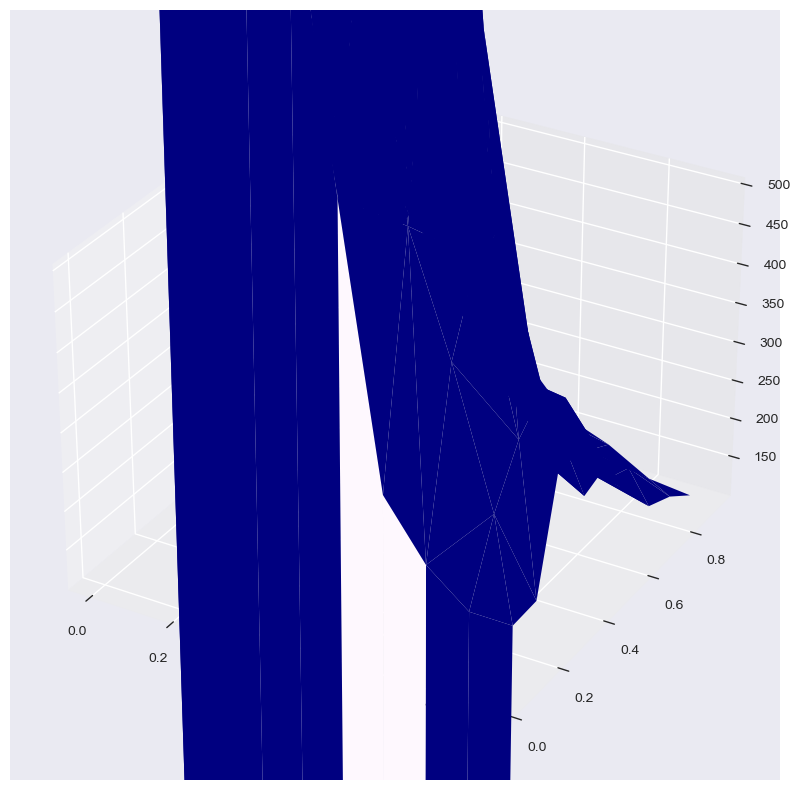

In [133]:
X, Y = np.meshgrid(spectral_radius, sigma)
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(X.ravel(), Y.ravel(),loss_arr, cmap='gist_ncar', edgecolor='none')
ax.set_zlim(min(loss_arr), 500)

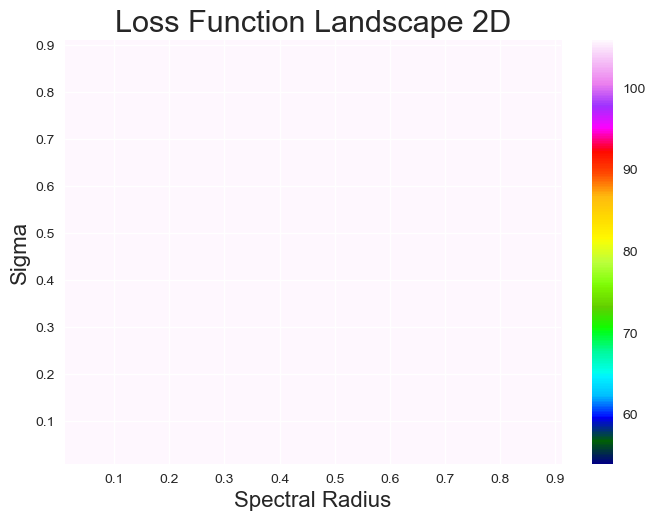

In [124]:
var_x = spectral_radius
var_y = sigma
plt.imshow(loss_arr.reshape(len(var_x), len(var_y)),
           cmap = 'gist_ncar', #'viridis', #'RdBu',
           interpolation = 'bicubic',#'kaiser', #'none', #'lanczos'
           vmax = 60,
           extent = [var_x[0],var_x[-1], var_y[0],var_y[-1]],
           origin = 'lower',
           aspect = 'auto')
plt.xlabel('Spectral Radius', fontsize=16)
plt.ylabel('Sigma', fontsize=16)
plt.title('Loss Function Landscape 2D', fontsize = 22)
plt.colorbar()

# Now let's use Differential Evolution to do a Global Search

"Differential evolution is a stochastic population based method that is useful for global optimization problems. At each pass through the population the algorithm mutates each candidate solution by mixing with other candidate solutions to create a trial candidate. There are several strategies for creating trial candidates, which suit some problems more than others. The ‘best1bin’ strategy is a good starting point for many systems. In this strategy two members of the population are randomly chosen. Their difference is used to mutate the best member (the ‘best’ in ‘best1bin’) so far:

$$b' = b_0 + \text{mutation} \times (\text{population}[rand_0] - \text{population}[rand_1])$$

A trial vector is then constructed. Starting with a randomly chosen ith parameter the trial is sequentially filled (in modulo) with parameters from b' or the original candidate. The choice of whether to use b' or the original candidate is made with a binomial distribution (the ‘bin’ in ‘best1bin’) - a random number in \[0, 1\) is generated. If this number is less than the recombination constant then the parameter is loaded from b', otherwise it is loaded from the original candidate. The final parameter is always loaded from b'. Once the trial candidate is built its fitness is assessed. If the trial is better than the original candidate then it takes its place. If it is also better than the best overall candidate it also replaces that. To improve your chances of finding a global minimum use higher popsize values, with higher mutation and (dithering), but lower recombination values. This has the effect of widening the search radius, but slowing convergence."

In [12]:
#sigma, leak_rate, spectral_radius, tikhonov_parameter, reservoir_dimension, sparsity
# input_parameters = 0.1, 0.8, 0.25, 888
#bounds = [(0.01, 1.0), (0.0, 1.0), (0.1, 1.5), (500, 2000)]
bounds = [(0.01, 1.0), (0.0, 1.0), (0.1, 1.5), (500, 2000)]

In [14]:
%%time
opt = differential_evolution(objective, bounds,
                             args=(l96, valid_data_arr), strategy='best1bin',
                             maxiter=100, popsize=16, tol=0.1, mutation=(0.5, 1.0),
                             recombination=0.7, seed=11111, callback=None, disp=True,
                             polish=True, init='latinhypercube', atol=0,
                             updating='deferred', workers=1)

Running Model-3:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-3: 149it [00:00, 1481.96it/s]                                                               
Running Model-3: 298it [00:00, 1436.42it/s]
Running Model-3: 442it [00:00, 1405.45it/s]
Running Model-3: 583it [00:00, 1327.24it/s]
Running Model-3: 717it [00:00, 1278.27it/s]
Running Model-3: 846it [00:00, 1249.78it/s]
Running Model-3: 974it [00:00, 1256.41it/s]
Running Model-3: 1112it [00:00, 1292.63it/s]
Running Model-3: 1242it [00:00, 1196.32it/s]
Running Model-3: 1364it [00:01, 1175.52it/s]
Running Model-3: 1483it [00:01, 1136.22it/s]
Running Model-3: 1598it [00:01, 1137.23it/s]
Running Model-3: 1724it [00:01, 1169.49it/s]
Running Model-3: 1860it [00:01, 1222.58it/s]
Running Model-3: 1991it [00:01, 1244.71it/s]
Running Model-3: 2118it [00:01, 1250.40it/s]
Running Model-3: 2263it [00:01, 1308.59it/s]
Running Model-3: 2395it [00:01, 1262.85it/s]
Running Model-3: 2522it [00

Running Model-3: 100%|██████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.79s/it]


Fitting node Ridge-3...


Running Model-4:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-4: 76it [00:00, 757.37it/s]                                                                 
Running Model-4: 162it [00:00, 815.62it/s]
Running Model-4: 244it [00:00, 789.49it/s]
Running Model-4: 327it [00:00, 803.62it/s]
Running Model-4: 410it [00:00, 811.02it/s]
Running Model-4: 492it [00:00, 810.93it/s]
Running Model-4: 577it [00:00, 822.22it/s]
Running Model-4: 663it [00:00, 832.46it/s]
Running Model-4: 747it [00:00, 832.55it/s]
Running Model-4: 832it [00:01, 835.31it/s]
Running Model-4: 919it [00:01, 842.38it/s]
Running Model-4: 1004it [00:01, 824.93it/s]
Running Model-4: 1087it [00:01, 825.16it/s]
Running Model-4: 1171it [00:01, 828.91it/s]
Running Model-4: 1258it [00:01, 840.66it/s]
Running Model-4: 1343it [00:01, 825.69it/s]
Running Model-4: 1426it [00:01, 823.85it/s]
Running Model-4: 1509it [00:01, 811.90it/s]
Running Model-4: 1592it [00:01, 817.15it/s]
Runn

Running Model-4: 13664it [00:17, 828.87it/s]
Running Model-4: 13747it [00:17, 814.03it/s]
Running Model-4: 13831it [00:17, 819.91it/s]
Running Model-4: 13914it [00:17, 800.64it/s]
Running Model-4: 13998it [00:17, 810.59it/s]
Running Model-4: 14080it [00:17, 795.60it/s]
Running Model-4: 14160it [00:17, 788.72it/s]
Running Model-4: 14239it [00:17, 783.63it/s]
Running Model-4: 14323it [00:18, 797.98it/s]
Running Model-4: 14403it [00:18, 780.97it/s]
Running Model-4: 14482it [00:18, 781.04it/s]
Running Model-4: 14561it [00:18, 773.28it/s]
Running Model-4: 14647it [00:18, 797.17it/s]
Running Model-4: 14735it [00:18, 821.52it/s]
Running Model-4: 14820it [00:18, 829.32it/s]
Running Model-4: 14907it [00:18, 840.66it/s]
Running Model-4: 14994it [00:18, 848.96it/s]
Running Model-4: 15080it [00:18, 850.46it/s]
Running Model-4: 15166it [00:19, 844.45it/s]
Running Model-4: 15251it [00:19, 824.69it/s]
Running Model-4: 15334it [00:19, 824.32it/s]
Running Model-4: 15417it [00:19, 816.87it/s]
Running Mo

Fitting node Ridge-4...


Running Model-5:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-5: 91it [00:00, 907.38it/s]                                                                 
Running Model-5: 192it [00:00, 964.71it/s]
Running Model-5: 291it [00:00, 974.19it/s]
Running Model-5: 389it [00:00, 971.87it/s]
Running Model-5: 487it [00:00, 943.79it/s]
Running Model-5: 582it [00:00, 942.22it/s]
Running Model-5: 683it [00:00, 963.67it/s]
Running Model-5: 780it [00:00, 954.46it/s]
Running Model-5: 879it [00:00, 963.38it/s]
Running Model-5: 977it [00:01, 966.32it/s]
Running Model-5: 1081it [00:01, 987.52it/s]
Running Model-5: 1180it [00:01, 961.88it/s]
Running Model-5: 1279it [00:01, 967.17it/s]
Running Model-5: 1380it [00:01, 976.65it/s]
Running Model-5: 1478it [00:01, 975.31it/s]
Running Model-5: 1578it [00:01, 982.27it/s]
Running Model-5: 1677it [00:01, 959.81it/s]
Running Model-5: 1774it [00:01, 956.81it/s]
Running Model-5: 1872it [00:01, 963.26it/s]
Run

Running Model-5: 16384it [00:17, 946.10it/s]
Running Model-5: 16479it [00:17, 944.42it/s]
Running Model-5: 16578it [00:17, 957.35it/s]
Running Model-5: 16674it [00:17, 928.79it/s]
Running Model-5: 16768it [00:17, 908.68it/s]
Running Model-5: 16860it [00:17, 890.46it/s]
Running Model-5: 16950it [00:17, 875.95it/s]
Running Model-5: 17046it [00:17, 899.60it/s]
Running Model-5: 17143it [00:18, 919.54it/s]
Running Model-5: 17239it [00:18, 930.61it/s]
Running Model-5: 17339it [00:18, 948.99it/s]
Running Model-5: 17435it [00:18, 950.74it/s]
Running Model-5: 17538it [00:18, 973.65it/s]
Running Model-5: 17637it [00:18, 977.12it/s]
Running Model-5: 17739it [00:18, 987.73it/s]
Running Model-5: 17838it [00:18, 969.35it/s]
Running Model-5: 17936it [00:18, 950.93it/s]
Running Model-5: 18032it [00:18, 921.64it/s]
Running Model-5: 18125it [00:19, 902.21it/s]
Running Model-5: 18218it [00:19, 909.26it/s]
Running Model-5: 18313it [00:19, 918.75it/s]
Running Model-5: 18407it [00:19, 924.24it/s]
Running Mo

Fitting node Ridge-5...


Running Model-6:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-6: 94it [00:00, 930.17it/s]                                                                 
Running Model-6: 188it [00:00, 922.83it/s]
Running Model-6: 281it [00:00, 894.38it/s]
Running Model-6: 371it [00:00, 894.89it/s]
Running Model-6: 461it [00:00, 893.34it/s]
Running Model-6: 551it [00:00, 894.62it/s]
Running Model-6: 653it [00:00, 934.29it/s]
Running Model-6: 755it [00:00, 959.25it/s]
Running Model-6: 857it [00:00, 974.48it/s]
Running Model-6: 955it [00:01, 959.69it/s]
Running Model-6: 1052it [00:01, 938.29it/s]
Running Model-6: 1146it [00:01, 902.01it/s]
Running Model-6: 1237it [00:01, 903.08it/s]
Running Model-6: 1333it [00:01, 916.40it/s]
Running Model-6: 1431it [00:01, 933.50it/s]
Running Model-6: 1527it [00:01, 940.35it/s]
Running Model-6: 1624it [00:01, 948.96it/s]
Running Model-6: 1720it [00:01, 938.10it/s]
Running Model-6: 1814it [00:01, 934.93it/s]
Run

Running Model-6: 16283it [00:17, 964.57it/s]
Running Model-6: 16380it [00:17, 960.97it/s]
Running Model-6: 16477it [00:17, 945.58it/s]
Running Model-6: 16572it [00:17, 942.38it/s]
Running Model-6: 16675it [00:17, 967.88it/s]
Running Model-6: 16772it [00:17, 958.80it/s]
Running Model-6: 16868it [00:17, 954.70it/s]
Running Model-6: 16964it [00:17, 941.28it/s]
Running Model-6: 17067it [00:18, 965.22it/s]
Running Model-6: 17170it [00:18, 982.89it/s]
Running Model-6: 17274it [00:18, 998.22it/s]
Running Model-6: 17376it [00:18, 1004.07it/s]
Running Model-6: 17477it [00:18, 981.73it/s] 
Running Model-6: 17576it [00:18, 959.80it/s]
Running Model-6: 17673it [00:18, 951.65it/s]
Running Model-6: 17769it [00:18, 943.76it/s]
Running Model-6: 17864it [00:18, 918.16it/s]
Running Model-6: 17956it [00:19, 915.70it/s]
Running Model-6: 18049it [00:19, 917.70it/s]
Running Model-6: 18141it [00:19, 904.30it/s]
Running Model-6: 18238it [00:19, 922.26it/s]
Running Model-6: 18331it [00:19, 901.26it/s]
Running 

Fitting node Ridge-6...


Running Model-7:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-7: 236it [00:00, 2350.83it/s]                                                               
Running Model-7: 473it [00:00, 2360.31it/s]
Running Model-7: 710it [00:00, 2264.22it/s]
Running Model-7: 937it [00:00, 2228.56it/s]
Running Model-7: 1161it [00:00, 2208.72it/s]
Running Model-7: 1383it [00:00, 2172.49it/s]
Running Model-7: 1601it [00:00, 2165.00it/s]
Running Model-7: 1822it [00:00, 2177.56it/s]
Running Model-7: 2049it [00:00, 2204.87it/s]
Running Model-7: 2291it [00:01, 2269.68it/s]
Running Model-7: 2519it [00:01, 2236.40it/s]
Running Model-7: 2743it [00:01, 2235.06it/s]
Running Model-7: 2973it [00:01, 2252.02it/s]
Running Model-7: 3207it [00:01, 2276.54it/s]
Running Model-7: 3446it [00:01, 2309.99it/s]
Running Model-7: 3684it [00:01, 2329.90it/s]
Running Model-7: 3918it [00:01, 2327.29it/s]
Running Model-7: 4163it [00:01, 2362.63it/s]
Running Model-7: 4405it 

Fitting node Ridge-7...


Running Model-8:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-8: 92it [00:00, 918.55it/s]                                                                 
Running Model-8: 184it [00:00, 891.40it/s]
Running Model-8: 280it [00:00, 920.16it/s]
Running Model-8: 373it [00:00, 909.33it/s]
Running Model-8: 469it [00:00, 925.93it/s]
Running Model-8: 562it [00:00, 893.05it/s]
Running Model-8: 654it [00:00, 899.55it/s]
Running Model-8: 745it [00:00, 892.84it/s]
Running Model-8: 846it [00:00, 927.46it/s]
Running Model-8: 944it [00:01, 943.01it/s]
Running Model-8: 1050it [00:01, 978.16it/s]
Running Model-8: 1148it [00:01, 967.38it/s]
Running Model-8: 1253it [00:01, 991.71it/s]
Running Model-8: 1353it [00:01, 972.49it/s]
Running Model-8: 1451it [00:01, 973.51it/s]
Running Model-8: 1549it [00:01, 972.00it/s]
Running Model-8: 1647it [00:01, 961.97it/s]
Running Model-8: 1750it [00:01, 980.71it/s]
Running Model-8: 1855it [00:01, 999.58it/s]
Run

Running Model-8: 16811it [00:16, 991.31it/s]
Running Model-8: 16916it [00:16, 1005.53it/s]
Running Model-8: 17017it [00:17, 986.40it/s] 
Running Model-8: 17117it [00:17, 989.73it/s]
Running Model-8: 17217it [00:17, 973.27it/s]
Running Model-8: 17315it [00:17, 968.66it/s]
Running Model-8: 17412it [00:17, 950.95it/s]
Running Model-8: 17508it [00:17, 935.08it/s]
Running Model-8: 17608it [00:17, 953.84it/s]
Running Model-8: 17710it [00:17, 971.49it/s]
Running Model-8: 17813it [00:17, 988.01it/s]
Running Model-8: 17917it [00:18, 1001.44it/s]
Running Model-8: 18023it [00:18, 1018.72it/s]
Running Model-8: 18129it [00:18, 1028.82it/s]
Running Model-8: 18233it [00:18, 1032.08it/s]
Running Model-8: 18339it [00:18, 1036.71it/s]
Running Model-8: 18443it [00:18, 1013.77it/s]
Running Model-8: 18545it [00:18, 995.56it/s] 
Running Model-8: 18648it [00:18, 1003.84it/s]
Running Model-8: 18749it [00:18, 1005.40it/s]
Running Model-8: 18855it [00:18, 1021.21it/s]
Running Model-8: 18959it [00:19, 1024.54it/

Fitting node Ridge-8...


Running Model-9:   0%|                                                              | 0/1 [00:00<?, ?it/s]
Running Model-9: 81it [00:00, 801.04it/s]                                                                 
Running Model-9: 163it [00:00, 809.75it/s]
Running Model-9: 244it [00:00, 809.03it/s]
Running Model-9: 325it [00:00, 794.86it/s]
Running Model-9: 413it [00:00, 823.66it/s]
Running Model-9: 496it [00:00, 810.16it/s]
Running Model-9: 585it [00:00, 834.34it/s]
Running Model-9: 669it [00:00, 824.89it/s]
Running Model-9: 754it [00:00, 832.09it/s]
Running Model-9: 838it [00:01, 817.68it/s]
Running Model-9: 928it [00:01, 841.58it/s]
Running Model-9: 1021it [00:01, 867.18it/s]
Running Model-9: 1108it [00:01, 865.84it/s]
Running Model-9: 1201it [00:01, 884.39it/s]
Running Model-9: 1292it [00:01, 890.22it/s]
Running Model-9: 1382it [00:01, 892.32it/s]
Running Model-9: 1472it [00:01, 888.61it/s]
Running Model-9: 1561it [00:01, 874.06it/s]
Running Model-9: 1649it [00:01, 869.87it/s]
Runn

Running Model-9: 14804it [00:17, 820.95it/s]
Running Model-9: 14887it [00:17, 817.85it/s]
Running Model-9: 14976it [00:17, 837.20it/s]
Running Model-9: 15064it [00:17, 848.52it/s]
Running Model-9: 15155it [00:17, 864.69it/s]
Running Model-9: 15245it [00:17, 875.00it/s]
Running Model-9: 15336it [00:17, 884.15it/s]
Running Model-9: 15427it [00:17, 890.42it/s]
Running Model-9: 15517it [00:18, 883.90it/s]
Running Model-9: 15608it [00:18, 890.15it/s]
Running Model-9: 15699it [00:18, 893.02it/s]
Running Model-9: 15789it [00:18, 893.24it/s]
Running Model-9: 15879it [00:18, 878.58it/s]
Running Model-9: 15969it [00:18, 882.73it/s]
Running Model-9: 16058it [00:18, 856.15it/s]
Running Model-9: 16150it [00:18, 873.62it/s]
Running Model-9: 16238it [00:18, 873.99it/s]
Running Model-9: 16327it [00:18, 878.47it/s]
Running Model-9: 16415it [00:19, 872.30it/s]
Running Model-9: 16505it [00:19, 878.89it/s]
Running Model-9: 16593it [00:19, 867.78it/s]
Running Model-9: 16685it [00:19, 882.17it/s]
Running Mo

Fitting node Ridge-9...


Running Model-10:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-10: 223it [00:00, 2226.57it/s]                                                              
Running Model-10: 446it [00:00, 2215.39it/s]
Running Model-10: 743it [00:00, 2557.57it/s]
Running Model-10: 1027it [00:00, 2665.94it/s]
Running Model-10: 1294it [00:00, 2591.59it/s]
Running Model-10: 1570it [00:00, 2643.87it/s]
Running Model-10: 1835it [00:00, 2581.03it/s]
Running Model-10: 2098it [00:00, 2595.70it/s]
Running Model-10: 2366it [00:00, 2620.81it/s]
Running Model-10: 2641it [00:01, 2658.85it/s]
Running Model-10: 2918it [00:01, 2691.85it/s]
Running Model-10: 3188it [00:01, 2684.46it/s]
Running Model-10: 3460it [00:01, 2689.72it/s]
Running Model-10: 3730it [00:01, 2656.29it/s]
Running Model-10: 3996it [00:01, 2594.91it/s]
Running Model-10: 4256it [00:01, 2590.79it/s]
Running Model-10: 4516it [00:01, 2562.07it/s]
Running Model-10: 4773it [00:01, 2513.32it/s]
Runnin

Fitting node Ridge-10...


Running Model-11:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-11: 154it [00:00, 1539.37it/s]                                                              
Running Model-11: 334it [00:00, 1687.78it/s]
Running Model-11: 519it [00:00, 1755.44it/s]
Running Model-11: 695it [00:00, 1750.54it/s]
Running Model-11: 883it [00:00, 1795.11it/s]
Running Model-11: 1071it [00:00, 1821.27it/s]
Running Model-11: 1261it [00:00, 1845.47it/s]
Running Model-11: 1446it [00:00, 1830.46it/s]
Running Model-11: 1630it [00:00, 1800.79it/s]
Running Model-11: 1811it [00:01, 1773.37it/s]
Running Model-11: 1989it [00:01, 1770.03it/s]
Running Model-11: 2170it [00:01, 1780.90it/s]
Running Model-11: 2357it [00:01, 1807.05it/s]
Running Model-11: 2538it [00:01, 1801.18it/s]
Running Model-11: 2719it [00:01, 1799.38it/s]
Running Model-11: 2899it [00:01, 1784.10it/s]
Running Model-11: 3084it [00:01, 1802.26it/s]
Running Model-11: 3265it [00:01, 1792.79it/s]
Running 

Fitting node Ridge-11...


Running Model-12:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-12: 123it [00:00, 1227.19it/s]                                                       
Running Model-12: 246it [00:00, 1203.20it/s]
Running Model-12: 367it [00:00, 1150.76it/s]
Running Model-12: 485it [00:00, 1158.42it/s]
Running Model-12: 606it [00:00, 1175.35it/s]
Running Model-12: 736it [00:00, 1215.45it/s]
Running Model-12: 860it [00:00, 1220.98it/s]
Running Model-12: 990it [00:00, 1245.71it/s]
Running Model-12: 1119it [00:00, 1258.96it/s]
Running Model-12: 1250it [00:01, 1273.48it/s]
Running Model-12: 1378it [00:01, 1252.19it/s]
Running Model-12: 1508it [00:01, 1265.26it/s]
Running Model-12: 1635it [00:01, 1241.75it/s]
Running Model-12: 1762it [00:01, 1248.59it/s]
Running Model-12: 1887it [00:01, 1233.59it/s]
Running Model-12: 2017it [00:01, 1252.21it/s]
Running Model-12: 2143it [00:01, 1231.86it/s]
Running Model-12: 2272it [00:01, 1247.74it/s]
Running Model-12: 2401it 

Running Model-12: 20319it [00:16, 1292.70it/s]
Running Model-12: 20453it [00:16, 1305.72it/s]
Running Model-12: 20584it [00:16, 1299.48it/s]
Running Model-12: 20714it [00:16, 1299.09it/s]
Running Model-12: 20844it [00:16, 1280.37it/s]
Running Model-12: 20973it [00:17, 1255.75it/s]
Running Model-12: 21099it [00:17, 1245.50it/s]
Running Model-12: 21233it [00:17, 1268.08it/s]
Running Model-12: 21360it [00:17, 1259.01it/s]
Running Model-12: 21486it [00:17, 1242.96it/s]
Running Model-12: 21616it [00:17, 1257.56it/s]
Running Model-12: 21749it [00:17, 1278.38it/s]
Running Model-12: 21877it [00:17, 1265.94it/s]
Running Model-12: 22009it [00:17, 1279.66it/s]
Running Model-12: 22138it [00:17, 1279.51it/s]
Running Model-12: 22266it [00:18, 1276.04it/s]
Running Model-12: 22396it [00:18, 1281.02it/s]
Running Model-12: 22533it [00:18, 1304.71it/s]
Running Model-12: 22667it [00:18, 1312.67it/s]
Running Model-12: 22799it [00:18, 1285.14it/s]
Running Model-12: 22999it [00:18, 1235.63it/s]
Running Model

Fitting node Ridge-12...


Running Model-13:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-13: 141it [00:00, 1402.74it/s]                                                       
Running Model-13: 297it [00:00, 1493.25it/s]
Running Model-13: 452it [00:00, 1514.23it/s]
Running Model-13: 604it [00:00, 1498.94it/s]
Running Model-13: 754it [00:00, 1493.14it/s]
Running Model-13: 904it [00:00, 1390.76it/s]
Running Model-13: 1046it [00:00, 1398.66it/s]
Running Model-13: 1187it [00:00, 1372.53it/s]
Running Model-13: 1331it [00:00, 1392.40it/s]
Running Model-13: 1471it [00:01, 1369.90it/s]
Running Model-13: 1614it [00:01, 1385.11it/s]
Running Model-13: 1753it [00:01, 1385.89it/s]
Running Model-13: 1898it [00:01, 1404.43it/s]
Running Model-13: 2057it [00:01, 1457.68it/s]
Running Model-13: 2203it [00:01, 1446.22it/s]
Running Model-13: 2351it [00:01, 1454.14it/s]
Running Model-13: 2506it [00:01, 1482.09it/s]
Running Model-13: 2656it [00:01, 1485.95it/s]
Running Model-13: 2813i

Fitting node Ridge-13...


Running Model-14:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-14: 132it [00:00, 1310.82it/s]                                                       
Running Model-14: 269it [00:00, 1342.65it/s]
Running Model-14: 408it [00:00, 1360.58it/s]
Running Model-14: 545it [00:00, 1334.34it/s]
Running Model-14: 682it [00:00, 1344.21it/s]
Running Model-14: 817it [00:00, 1327.41it/s]
Running Model-14: 952it [00:00, 1332.92it/s]
Running Model-14: 1086it [00:00, 1297.53it/s]
Running Model-14: 1219it [00:00, 1306.49it/s]
Running Model-14: 1350it [00:01, 1286.96it/s]
Running Model-14: 1485it [00:01, 1305.42it/s]
Running Model-14: 1620it [00:01, 1316.94it/s]
Running Model-14: 1757it [00:01, 1332.18it/s]
Running Model-14: 1891it [00:01, 1317.58it/s]
Running Model-14: 2027it [00:01, 1329.06it/s]
Running Model-14: 2160it [00:01, 1309.81it/s]
Running Model-14: 2292it [00:01, 1290.63it/s]
Running Model-14: 2422it [00:01, 1290.94it/s]
Running Model-14: 2555it

Running Model-14: 19968it [00:17, 1048.47it/s]
Running Model-14: 20087it [00:17, 1087.76it/s]
Running Model-14: 20213it [00:17, 1137.57it/s]
Running Model-14: 20328it [00:17, 1060.65it/s]
Running Model-14: 20443it [00:17, 1084.72it/s]
Running Model-14: 20563it [00:17, 1117.51it/s]
Running Model-14: 20676it [00:17, 1047.47it/s]
Running Model-14: 20785it [00:17, 1058.89it/s]
Running Model-14: 20903it [00:17, 1090.37it/s]
Running Model-14: 21013it [00:18, 1084.11it/s]
Running Model-14: 21123it [00:18, 1012.49it/s]
Running Model-14: 21229it [00:18, 1024.45it/s]
Running Model-14: 21334it [00:18, 1031.13it/s]
Running Model-14: 21454it [00:18, 1078.54it/s]
Running Model-14: 21587it [00:18, 1149.87it/s]
Running Model-14: 21703it [00:18, 1121.77it/s]
Running Model-14: 21817it [00:18, 1124.13it/s]
Running Model-14: 21930it [00:18, 1106.10it/s]
Running Model-14: 22041it [00:19, 1007.10it/s]
Running Model-14: 22144it [00:19, 992.01it/s] 
Running Model-14: 22245it [00:19, 984.71it/s]
Running Model-

Fitting node Ridge-14...


Running Model-15:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-15: 78it [00:00, 772.85it/s]                                                                
Running Model-15: 167it [00:00, 836.81it/s]
Running Model-15: 251it [00:00, 820.75it/s]
Running Model-15: 338it [00:00, 837.07it/s]
Running Model-15: 422it [00:00, 825.37it/s]
Running Model-15: 512it [00:00, 849.94it/s]
Running Model-15: 598it [00:00, 846.67it/s]
Running Model-15: 689it [00:00, 866.15it/s]
Running Model-15: 776it [00:00, 860.07it/s]
Running Model-15: 864it [00:01, 863.62it/s]
Running Model-15: 956it [00:01, 877.69it/s]
Running Model-15: 1044it [00:01, 863.48it/s]
Running Model-15: 1131it [00:01, 842.44it/s]
Running Model-15: 1220it [00:01, 856.02it/s]
Running Model-15: 1306it [00:01, 839.58it/s]
Running Model-15: 1391it [00:01, 840.89it/s]
Running Model-15: 1480it [00:01, 854.80it/s]
Running Model-15: 1566it [00:01, 849.91it/s]
Running Model-15: 1656it [00:01

Running Model-15: 14429it [00:16, 859.87it/s]
Running Model-15: 14516it [00:17, 861.75it/s]
Running Model-15: 14603it [00:17, 853.28it/s]
Running Model-15: 14694it [00:17, 869.81it/s]
Running Model-15: 14782it [00:17, 863.68it/s]
Running Model-15: 14874it [00:17, 878.13it/s]
Running Model-15: 14962it [00:17, 864.27it/s]
Running Model-15: 15050it [00:17, 867.52it/s]
Running Model-15: 15140it [00:17, 876.05it/s]
Running Model-15: 15229it [00:17, 879.70it/s]
Running Model-15: 15318it [00:17, 875.41it/s]
Running Model-15: 15406it [00:18, 874.18it/s]
Running Model-15: 15498it [00:18, 885.56it/s]
Running Model-15: 15587it [00:18, 881.73it/s]
Running Model-15: 15676it [00:18, 866.04it/s]
Running Model-15: 15763it [00:18, 847.07it/s]
Running Model-15: 15849it [00:18, 849.84it/s]
Running Model-15: 15940it [00:18, 867.35it/s]
Running Model-15: 16033it [00:18, 884.10it/s]
Running Model-15: 16122it [00:18, 880.26it/s]
Running Model-15: 16211it [00:18, 863.46it/s]
Running Model-15: 16298it [00:19, 

Fitting node Ridge-15...


Running Model-16:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-16: 86it [00:00, 857.53it/s]                                                                
Running Model-16: 209it [00:00, 1074.96it/s]
Running Model-16: 357it [00:00, 1255.81it/s]
Running Model-16: 499it [00:00, 1318.89it/s]
Running Model-16: 649it [00:00, 1381.66it/s]
Running Model-16: 793it [00:00, 1400.23it/s]
Running Model-16: 937it [00:00, 1412.54it/s]
Running Model-16: 1080it [00:00, 1416.99it/s]
Running Model-16: 1225it [00:00, 1426.24it/s]
Running Model-16: 1368it [00:01, 1397.76it/s]
Running Model-16: 1514it [00:01, 1413.86it/s]
Running Model-16: 1656it [00:01, 1385.56it/s]
Running Model-16: 1800it [00:01, 1401.49it/s]
Running Model-16: 1941it [00:01, 1373.34it/s]
Running Model-16: 2094it [00:01, 1416.72it/s]
Running Model-16: 2236it [00:01, 1380.97it/s]
Running Model-16: 2381it [00:01, 1400.35it/s]
Running Model-16: 2522it [00:01, 1381.85it/s]
Running Mo

Running Model-16: 22711it [00:16, 1395.30it/s]
Running Model-16: 22851it [00:16, 1373.18it/s]
Running Model-16: 22999it [00:16, 1383.33it/s]
Running Model-16: 100%|█████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.63s/it]


Fitting node Ridge-16...


Running Model-17:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-17: 201it [00:00, 2008.01it/s]                                                              
Running Model-17: 439it [00:00, 2224.27it/s]
Running Model-17: 681it [00:00, 2311.02it/s]
Running Model-17: 913it [00:00, 2237.13it/s]
Running Model-17: 1138it [00:00, 2226.35it/s]
Running Model-17: 1381it [00:00, 2291.86it/s]
Running Model-17: 1611it [00:00, 2258.27it/s]
Running Model-17: 1839it [00:00, 2262.35it/s]
Running Model-17: 2066it [00:00, 2240.01it/s]
Running Model-17: 2314it [00:01, 2312.69it/s]
Running Model-17: 2546it [00:01, 2273.08it/s]
Running Model-17: 2780it [00:01, 2292.13it/s]
Running Model-17: 3010it [00:01, 2229.19it/s]
Running Model-17: 3251it [00:01, 2280.38it/s]
Running Model-17: 3480it [00:01, 2262.36it/s]
Running Model-17: 3725it [00:01, 2316.89it/s]
Running Model-17: 3958it [00:01, 2283.54it/s]
Running Model-17: 4189it [00:01, 2288.67it/s]
Running

Fitting node Ridge-17...


Running Model-18:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-18: 210it [00:00, 2097.72it/s]                                                              
Running Model-18: 432it [00:00, 2168.94it/s]
Running Model-18: 649it [00:00, 2064.98it/s]
Running Model-18: 866it [00:00, 2102.42it/s]
Running Model-18: 1077it [00:00, 2074.75it/s]
Running Model-18: 1302it [00:00, 2132.25it/s]
Running Model-18: 1519it [00:00, 2143.31it/s]
Running Model-18: 1734it [00:00, 2122.58it/s]
Running Model-18: 1955it [00:00, 2146.18it/s]
Running Model-18: 2177it [00:01, 2168.04it/s]
Running Model-18: 2406it [00:01, 2203.25it/s]
Running Model-18: 2633it [00:01, 2223.12it/s]
Running Model-18: 2864it [00:01, 2247.94it/s]
Running Model-18: 3089it [00:01, 2175.46it/s]
Running Model-18: 3317it [00:01, 2205.03it/s]
Running Model-18: 3538it [00:01, 2203.52it/s]
Running Model-18: 3765it [00:01, 2223.17it/s]
Running Model-18: 3988it [00:01, 2196.37it/s]
Running

Fitting node Ridge-18...


Running Model-19:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-19: 112it [00:00, 1117.03it/s]                                                              
Running Model-19: 224it [00:00, 1082.48it/s]
Running Model-19: 333it [00:00, 988.42it/s] 
Running Model-19: 433it [00:00, 971.41it/s]
Running Model-19: 537it [00:00, 991.49it/s]
Running Model-19: 647it [00:00, 1021.22it/s]
Running Model-19: 765it [00:00, 1070.66it/s]
Running Model-19: 881it [00:00, 1095.46it/s]
Running Model-19: 1007it [00:00, 1143.77it/s]
Running Model-19: 1122it [00:01, 1142.10it/s]
Running Model-19: 1238it [00:01, 1147.27it/s]
Running Model-19: 1366it [00:01, 1185.49it/s]
Running Model-19: 1491it [00:01, 1204.08it/s]
Running Model-19: 1614it [00:01, 1211.58it/s]
Running Model-19: 1741it [00:01, 1228.12it/s]
Running Model-19: 1864it [00:01, 1222.71it/s]
Running Model-19: 1989it [00:01, 1228.79it/s]
Running Model-19: 2115it [00:01, 1236.07it/s]
Running Model

Running Model-19: 19353it [00:16, 1216.62it/s]
Running Model-19: 19475it [00:16, 1205.33it/s]
Running Model-19: 19602it [00:16, 1221.67it/s]
Running Model-19: 19726it [00:16, 1226.88it/s]
Running Model-19: 19849it [00:16, 1221.77it/s]
Running Model-19: 19974it [00:17, 1228.35it/s]
Running Model-19: 20097it [00:17, 1226.25it/s]
Running Model-19: 20220it [00:17, 1223.83it/s]
Running Model-19: 20343it [00:17, 1218.53it/s]
Running Model-19: 20468it [00:17, 1227.41it/s]
Running Model-19: 20591it [00:17, 1217.61it/s]
Running Model-19: 20713it [00:17, 1213.19it/s]
Running Model-19: 20835it [00:17, 1211.09it/s]
Running Model-19: 20957it [00:17, 1203.27it/s]
Running Model-19: 21079it [00:17, 1205.60it/s]
Running Model-19: 21200it [00:18, 1201.04it/s]
Running Model-19: 21328it [00:18, 1220.84it/s]
Running Model-19: 21451it [00:18, 1222.86it/s]
Running Model-19: 21574it [00:18, 1198.06it/s]
Running Model-19: 21694it [00:18, 1182.57it/s]
Running Model-19: 21813it [00:18, 1154.40it/s]
Running Model

Fitting node Ridge-19...


Running Model-20:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-20: 220it [00:00, 2191.00it/s]                                                              
Running Model-20: 440it [00:00, 2176.58it/s]
Running Model-20: 674it [00:00, 2250.29it/s]
Running Model-20: 903it [00:00, 2265.46it/s]
Running Model-20: 1130it [00:00, 2249.33it/s]
Running Model-20: 1355it [00:00, 2185.34it/s]
Running Model-20: 1574it [00:00, 2179.19it/s]
Running Model-20: 1793it [00:00, 2108.13it/s]
Running Model-20: 2009it [00:00, 2122.30it/s]
Running Model-20: 2222it [00:01, 2113.75it/s]
Running Model-20: 2434it [00:01, 2074.39it/s]
Running Model-20: 2642it [00:01, 2035.08it/s]
Running Model-20: 2866it [00:01, 2092.29it/s]
Running Model-20: 3076it [00:01, 2081.77it/s]
Running Model-20: 3309it [00:01, 2151.91it/s]
Running Model-20: 3525it [00:01, 2077.19it/s]
Running Model-20: 3756it [00:01, 2142.68it/s]
Running Model-20: 3971it [00:01, 2129.54it/s]
Running

Fitting node Ridge-20...


Running Model-21:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-21: 213it [00:00, 2128.85it/s]                                                              
Running Model-21: 427it [00:00, 2132.33it/s]
Running Model-21: 641it [00:00, 2095.97it/s]
Running Model-21: 855it [00:00, 2108.33it/s]
Running Model-21: 1076it [00:00, 2143.89it/s]
Running Model-21: 1294it [00:00, 2154.94it/s]
Running Model-21: 1510it [00:00, 2138.30it/s]
Running Model-21: 1732it [00:00, 2159.68it/s]
Running Model-21: 1949it [00:00, 2152.58it/s]
Running Model-21: 2169it [00:01, 2165.95it/s]
Running Model-21: 2389it [00:01, 2175.06it/s]
Running Model-21: 2609it [00:01, 2182.12it/s]
Running Model-21: 2828it [00:01, 2128.83it/s]
Running Model-21: 3042it [00:01, 2116.02it/s]
Running Model-21: 3254it [00:01, 2100.38it/s]
Running Model-21: 3477it [00:01, 2134.96it/s]
Running Model-21: 3691it [00:01, 2063.47it/s]
Running Model-21: 3903it [00:01, 2078.35it/s]
Running

Fitting node Ridge-21...


Running Model-22:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-22: 137it [00:00, 1366.73it/s]                                                              
Running Model-22: 302it [00:00, 1529.39it/s]
Running Model-22: 455it [00:00, 1363.09it/s]
Running Model-22: 643it [00:00, 1552.24it/s]
Running Model-22: 835it [00:00, 1676.92it/s]
Running Model-22: 1014it [00:00, 1712.72it/s]
Running Model-22: 1193it [00:00, 1734.67it/s]
Running Model-22: 1368it [00:00, 1714.90it/s]
Running Model-22: 1545it [00:00, 1731.54it/s]
Running Model-22: 1721it [00:01, 1739.05it/s]
Running Model-22: 1896it [00:01, 1730.26it/s]
Running Model-22: 2070it [00:01, 1695.55it/s]
Running Model-22: 2240it [00:01, 1601.61it/s]
Running Model-22: 2402it [00:01, 1563.64it/s]
Running Model-22: 2560it [00:01, 1512.10it/s]
Running Model-22: 2712it [00:01, 1488.00it/s]
Running Model-22: 2882it [00:01, 1543.82it/s]
Running Model-22: 3037it [00:01, 1474.63it/s]
Running 

Fitting node Ridge-22...


Running Model-23:   0%|                                                             | 0/1 [00:00<?, ?it/s]
Running Model-23: 93it [00:00, 925.94it/s]                                                                
Running Model-23: 211it [00:00, 1075.04it/s]
Running Model-23: 338it [00:00, 1162.74it/s]
Running Model-23: 466it [00:00, 1204.66it/s]
Running Model-23: 593it [00:00, 1224.99it/s]
Running Model-23: 720it [00:00, 1239.08it/s]
Running Model-23: 846it [00:00, 1244.64it/s]
Running Model-23: 971it [00:00, 1228.58it/s]
Running Model-23: 1099it [00:00, 1242.66it/s]
Running Model-23: 1233it [00:01, 1271.44it/s]
Running Model-23: 1361it [00:01, 1255.09it/s]
Running Model-23: 1487it [00:01, 1254.32it/s]
Running Model-23: 1619it [00:01, 1272.58it/s]
Running Model-23: 1747it [00:01, 1273.96it/s]
Running Model-23: 1875it [00:01, 1269.90it/s]
Running Model-23: 2007it [00:01, 1283.05it/s]
Running Model-23: 2136it [00:01, 1271.10it/s]
Running Model-23: 2264it [00:01, 1272.17it/s]
Running Mod

Running Model-23: 20460it [00:16, 1246.94it/s]
Running Model-23: 20588it [00:16, 1254.53it/s]
Running Model-23: 20714it [00:16, 1251.63it/s]
Running Model-23: 20847it [00:16, 1274.30it/s]
Running Model-23: 20976it [00:16, 1273.20it/s]
Running Model-23: 21111it [00:16, 1294.55it/s]
Running Model-23: 21241it [00:16, 1295.45it/s]
Running Model-23: 21377it [00:17, 1313.24it/s]
Running Model-23: 21510it [00:17, 1318.14it/s]
Running Model-23: 21643it [00:17, 1320.30it/s]
Running Model-23: 21777it [00:17, 1325.29it/s]
Running Model-23: 21911it [00:17, 1327.64it/s]
Running Model-23: 22044it [00:17, 1319.58it/s]
Running Model-23: 22177it [00:17, 1322.65it/s]
Running Model-23: 22310it [00:17, 1304.95it/s]
Running Model-23: 22441it [00:17, 1301.99it/s]
Running Model-23: 22572it [00:17, 1272.56it/s]
Running Model-23: 22703it [00:18, 1282.28it/s]
Running Model-23: 22832it [00:18, 1282.82it/s]
Running Model-23: 22999it [00:18, 1258.03it/s]
Running Model-23: 100%|█████████████████████████████████████

Fitting node Ridge-23...


Running Model-24:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-24: 92it [00:00, 913.62it/s]                                                         
Running Model-24: 189it [00:00, 941.41it/s]
Running Model-24: 284it [00:00, 934.75it/s]
Running Model-24: 382it [00:00, 951.78it/s]
Running Model-24: 482it [00:00, 967.12it/s]
Running Model-24: 583it [00:00, 981.32it/s]
Running Model-24: 682it [00:00, 983.52it/s]
Running Model-24: 781it [00:00, 950.01it/s]
Running Model-24: 877it [00:00, 949.91it/s]
Running Model-24: 973it [00:01, 923.55it/s]
Running Model-24: 1066it [00:01, 922.23it/s]
Running Model-24: 1159it [00:01, 896.83it/s]
Running Model-24: 1249it [00:01, 886.35it/s]
Running Model-24: 1338it [00:01, 856.30it/s]
Running Model-24: 1424it [00:01, 852.67it/s]
Running Model-24: 1511it [00:01, 855.59it/s]
Running Model-24: 1608it [00:01, 886.62it/s]
Running Model-24: 1701it [00:01, 898.75it/s]
Running Model-24: 1796it [00:01, 913.34it/s]

Running Model-24: 15979it [00:17, 968.57it/s]
Running Model-24: 16076it [00:17, 963.26it/s]
Running Model-24: 16182it [00:17, 988.32it/s]
Running Model-24: 16281it [00:17, 987.89it/s]
Running Model-24: 16382it [00:17, 994.30it/s]
Running Model-24: 16482it [00:17, 994.57it/s]
Running Model-24: 16583it [00:17, 998.45it/s]
Running Model-24: 16684it [00:17, 999.52it/s]
Running Model-24: 16788it [00:17, 1009.58it/s]
Running Model-24: 16889it [00:17, 1006.73it/s]
Running Model-24: 16990it [00:18, 989.85it/s] 
Running Model-24: 17090it [00:18, 982.63it/s]
Running Model-24: 17192it [00:18, 990.86it/s]
Running Model-24: 17292it [00:18, 986.09it/s]
Running Model-24: 17391it [00:18, 968.32it/s]
Running Model-24: 17494it [00:18, 984.79it/s]
Running Model-24: 17596it [00:18, 994.10it/s]
Running Model-24: 17696it [00:18, 995.04it/s]
Running Model-24: 17797it [00:18, 999.03it/s]
Running Model-24: 17897it [00:18, 981.69it/s]
Running Model-24: 17996it [00:19, 976.85it/s]
Running Model-24: 18094it [00:1

Fitting node Ridge-24...


Running Model-25:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-25: 76it [00:00, 750.66it/s]                                                         
Running Model-25: 158it [00:00, 788.24it/s]
Running Model-25: 237it [00:00, 787.19it/s]
Running Model-25: 317it [00:00, 791.22it/s]
Running Model-25: 397it [00:00, 781.81it/s]
Running Model-25: 481it [00:00, 800.65it/s]
Running Model-25: 562it [00:00, 791.32it/s]
Running Model-25: 644it [00:00, 799.46it/s]
Running Model-25: 724it [00:00, 784.64it/s]
Running Model-25: 810it [00:01, 805.56it/s]
Running Model-25: 891it [00:01, 797.28it/s]
Running Model-25: 978it [00:01, 816.96it/s]
Running Model-25: 1060it [00:01, 806.78it/s]
Running Model-25: 1143it [00:01, 811.81it/s]
Running Model-25: 1225it [00:01, 795.27it/s]
Running Model-25: 1306it [00:01, 797.72it/s]
Running Model-25: 1390it [00:01, 808.04it/s]
Running Model-25: 1475it [00:01, 820.11it/s]
Running Model-25: 1558it [00:01, 817.71it/s]
R

Running Model-25: 13341it [00:16, 772.54it/s]
Running Model-25: 13419it [00:17, 771.49it/s]
Running Model-25: 13502it [00:17, 787.51it/s]
Running Model-25: 13581it [00:17, 777.92it/s]
Running Model-25: 13663it [00:17, 787.83it/s]
Running Model-25: 13742it [00:17, 770.21it/s]
Running Model-25: 13821it [00:17, 774.08it/s]
Running Model-25: 13902it [00:17, 782.76it/s]
Running Model-25: 13984it [00:17, 792.12it/s]
Running Model-25: 14067it [00:17, 802.94it/s]
Running Model-25: 14148it [00:17, 795.46it/s]
Running Model-25: 14231it [00:18, 804.16it/s]
Running Model-25: 14315it [00:18, 813.02it/s]
Running Model-25: 14400it [00:18, 821.74it/s]
Running Model-25: 14483it [00:18, 823.87it/s]
Running Model-25: 14566it [00:18, 824.18it/s]
Running Model-25: 14649it [00:18, 811.71it/s]
Running Model-25: 14731it [00:18, 801.73it/s]
Running Model-25: 14812it [00:18, 801.42it/s]
Running Model-25: 14893it [00:18, 799.15it/s]
Running Model-25: 14973it [00:18, 767.14it/s]
Running Model-25: 15056it [00:19, 

Fitting node Ridge-25...


Running Model-26:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-26: 75it [00:00, 741.55it/s]                                                         
Running Model-26: 161it [00:00, 808.49it/s]
Running Model-26: 255it [00:00, 866.22it/s]
Running Model-26: 350it [00:00, 897.77it/s]
Running Model-26: 444it [00:00, 910.60it/s]
Running Model-26: 537it [00:00, 914.54it/s]
Running Model-26: 632it [00:00, 925.17it/s]
Running Model-26: 725it [00:00, 922.28it/s]
Running Model-26: 818it [00:00, 901.00it/s]
Running Model-26: 909it [00:01, 878.65it/s]
Running Model-26: 998it [00:01, 868.42it/s]
Running Model-26: 1085it [00:01, 864.26it/s]
Running Model-26: 1174it [00:01, 869.66it/s]
Running Model-26: 1266it [00:01, 884.06it/s]
Running Model-26: 1355it [00:01, 872.39it/s]
Running Model-26: 1450it [00:01, 893.15it/s]
Running Model-26: 1540it [00:01, 884.16it/s]
Running Model-26: 1635it [00:01, 902.01it/s]
Running Model-26: 1726it [00:01, 900.64it/s]


Running Model-26: 14986it [00:16, 893.17it/s]
Running Model-26: 15076it [00:17, 869.39it/s]
Running Model-26: 15167it [00:17, 880.57it/s]
Running Model-26: 15258it [00:17, 887.36it/s]
Running Model-26: 15351it [00:17, 898.65it/s]
Running Model-26: 15443it [00:17, 904.09it/s]
Running Model-26: 15535it [00:17, 906.73it/s]
Running Model-26: 15626it [00:17, 867.44it/s]
Running Model-26: 15714it [00:17, 863.61it/s]
Running Model-26: 15801it [00:17, 843.08it/s]
Running Model-26: 15889it [00:17, 852.29it/s]
Running Model-26: 15975it [00:18, 838.25it/s]
Running Model-26: 16059it [00:18, 830.86it/s]
Running Model-26: 16145it [00:18, 839.11it/s]
Running Model-26: 16233it [00:18, 849.92it/s]
Running Model-26: 16322it [00:18, 860.51it/s]
Running Model-26: 16409it [00:18, 858.22it/s]
Running Model-26: 16498it [00:18, 866.39it/s]
Running Model-26: 16586it [00:18, 867.67it/s]
Running Model-26: 16673it [00:18, 845.32it/s]
Running Model-26: 16758it [00:18, 841.31it/s]
Running Model-26: 16843it [00:19, 

Fitting node Ridge-26...


Running Model-27:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-27: 111it [00:00, 1105.63it/s]                                                       
Running Model-27: 226it [00:00, 1129.11it/s]
Running Model-27: 339it [00:00, 1094.17it/s]
Running Model-27: 449it [00:00, 1094.99it/s]
Running Model-27: 559it [00:00, 1094.45it/s]
Running Model-27: 670it [00:00, 1098.58it/s]
Running Model-27: 783it [00:00, 1107.65it/s]
Running Model-27: 903it [00:00, 1135.08it/s]
Running Model-27: 1017it [00:00, 1117.37it/s]
Running Model-27: 1133it [00:01, 1129.10it/s]
Running Model-27: 1246it [00:01, 1123.41it/s]
Running Model-27: 1359it [00:01, 1120.70it/s]
Running Model-27: 1472it [00:01, 1105.80it/s]
Running Model-27: 1591it [00:01, 1130.44it/s]
Running Model-27: 1713it [00:01, 1154.77it/s]
Running Model-27: 1835it [00:01, 1172.69it/s]
Running Model-27: 1953it [00:01, 1174.49it/s]
Running Model-27: 2076it [00:01, 1191.00it/s]
Running Model-27: 2198it 

Running Model-27: 18443it [00:16, 1086.56it/s]
Running Model-27: 18556it [00:16, 1098.93it/s]
Running Model-27: 18669it [00:16, 1105.44it/s]
Running Model-27: 18793it [00:16, 1144.37it/s]
Running Model-27: 18915it [00:16, 1165.22it/s]
Running Model-27: 19032it [00:17, 1132.48it/s]
Running Model-27: 19156it [00:17, 1162.02it/s]
Running Model-27: 19273it [00:17, 1153.62it/s]
Running Model-27: 19395it [00:17, 1169.96it/s]
Running Model-27: 19513it [00:17, 1151.21it/s]
Running Model-27: 19629it [00:17, 1140.75it/s]
Running Model-27: 19750it [00:17, 1160.94it/s]
Running Model-27: 19867it [00:17, 1147.14it/s]
Running Model-27: 19982it [00:17, 1146.61it/s]
Running Model-27: 20098it [00:18, 1150.34it/s]
Running Model-27: 20214it [00:18, 1128.97it/s]
Running Model-27: 20328it [00:18, 1117.66it/s]
Running Model-27: 20440it [00:18, 1097.70it/s]
Running Model-27: 20553it [00:18, 1105.13it/s]
Running Model-27: 20664it [00:18, 1084.13it/s]
Running Model-27: 20775it [00:18, 1090.42it/s]
Running Model

Fitting node Ridge-27...


Running Model-28:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-28: 115it [00:00, 1143.09it/s]                                                       
Running Model-28: 230it [00:00, 1146.75it/s]
Running Model-28: 345it [00:00, 1146.01it/s]
Running Model-28: 460it [00:00, 1122.98it/s]
Running Model-28: 575it [00:00, 1130.84it/s]
Running Model-28: 701it [00:00, 1173.85it/s]
Running Model-28: 819it [00:00, 1166.33it/s]
Running Model-28: 945it [00:00, 1195.47it/s]
Running Model-28: 1065it [00:00, 1192.89it/s]
Running Model-28: 1192it [00:01, 1215.88it/s]
Running Model-28: 1314it [00:01, 1193.40it/s]
Running Model-28: 1434it [00:01, 1179.23it/s]
Running Model-28: 1553it [00:01, 1158.43it/s]
Running Model-28: 1676it [00:01, 1177.65it/s]
Running Model-28: 1794it [00:01, 1138.62it/s]
Running Model-28: 1917it [00:01, 1163.35it/s]
Running Model-28: 2040it [00:01, 1180.96it/s]
Running Model-28: 2162it [00:01, 1192.05it/s]
Running Model-28: 2285it 

Running Model-28: 19279it [00:16, 1125.69it/s]
Running Model-28: 19392it [00:16, 1116.19it/s]
Running Model-28: 19504it [00:16, 1085.65it/s]
Running Model-28: 19627it [00:16, 1125.20it/s]
Running Model-28: 19740it [00:16, 1123.35it/s]
Running Model-28: 19861it [00:17, 1148.21it/s]
Running Model-28: 19981it [00:17, 1163.06it/s]
Running Model-28: 20098it [00:17, 1151.06it/s]
Running Model-28: 20216it [00:17, 1158.25it/s]
Running Model-28: 20332it [00:17, 1132.06it/s]
Running Model-28: 20446it [00:17, 1125.37it/s]
Running Model-28: 20559it [00:17, 1121.21it/s]
Running Model-28: 20672it [00:17, 1108.93it/s]
Running Model-28: 20790it [00:17, 1129.27it/s]
Running Model-28: 20910it [00:17, 1149.75it/s]
Running Model-28: 21028it [00:18, 1158.37it/s]
Running Model-28: 21148it [00:18, 1170.05it/s]
Running Model-28: 21268it [00:18, 1178.02it/s]
Running Model-28: 21388it [00:18, 1182.63it/s]
Running Model-28: 21507it [00:18, 1164.61it/s]
Running Model-28: 21631it [00:18, 1184.60it/s]
Running Model

Fitting node Ridge-28...


Running Model-29:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-29: 88it [00:00, 874.63it/s]                                                         
Running Model-29: 176it [00:00, 876.49it/s]
Running Model-29: 272it [00:00, 914.28it/s]
Running Model-29: 364it [00:00, 911.79it/s]
Running Model-29: 462it [00:00, 935.86it/s]
Running Model-29: 556it [00:00, 922.26it/s]
Running Model-29: 652it [00:00, 934.32it/s]
Running Model-29: 746it [00:00, 919.06it/s]
Running Model-29: 840it [00:00, 925.43it/s]
Running Model-29: 933it [00:01, 911.43it/s]
Running Model-29: 1026it [00:01, 914.55it/s]
Running Model-29: 1118it [00:01, 899.49it/s]
Running Model-29: 1209it [00:01, 885.56it/s]
Running Model-29: 1298it [00:01, 873.94it/s]
Running Model-29: 1393it [00:01, 894.55it/s]
Running Model-29: 1483it [00:01, 894.36it/s]
Running Model-29: 1573it [00:01, 884.62it/s]
Running Model-29: 1667it [00:01, 899.75it/s]
Running Model-29: 1761it [00:01, 911.44it/s]

Running Model-29: 15449it [00:16, 904.13it/s]
Running Model-29: 15540it [00:16, 894.57it/s]
Running Model-29: 15632it [00:17, 901.97it/s]
Running Model-29: 15723it [00:17, 890.61it/s]
Running Model-29: 15816it [00:17, 900.10it/s]
Running Model-29: 15907it [00:17, 898.54it/s]
Running Model-29: 16002it [00:17, 911.61it/s]
Running Model-29: 16101it [00:17, 932.92it/s]
Running Model-29: 16197it [00:17, 939.57it/s]
Running Model-29: 16297it [00:17, 957.54it/s]
Running Model-29: 16394it [00:17, 958.14it/s]
Running Model-29: 16492it [00:17, 964.41it/s]
Running Model-29: 16589it [00:18, 938.87it/s]
Running Model-29: 16684it [00:18, 933.24it/s]
Running Model-29: 16778it [00:18, 934.97it/s]
Running Model-29: 16875it [00:18, 943.40it/s]
Running Model-29: 16970it [00:18, 934.14it/s]
Running Model-29: 17067it [00:18, 943.89it/s]
Running Model-29: 17163it [00:18, 948.26it/s]
Running Model-29: 17260it [00:18, 954.00it/s]
Running Model-29: 17356it [00:18, 938.54it/s]
Running Model-29: 17453it [00:19, 

Fitting node Ridge-29...


Running Model-30:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-30: 208it [00:00, 2075.73it/s]                                                       
Running Model-30: 465it [00:00, 2362.71it/s]
Running Model-30: 722it [00:00, 2455.69it/s]
Running Model-30: 978it [00:00, 2495.23it/s]
Running Model-30: 1228it [00:00, 2477.78it/s]
Running Model-30: 1476it [00:00, 2471.78it/s]
Running Model-30: 1735it [00:00, 2509.31it/s]
Running Model-30: 1994it [00:00, 2534.26it/s]
Running Model-30: 2253it [00:00, 2550.65it/s]
Running Model-30: 2512it [00:01, 2562.09it/s]
Running Model-30: 2782it [00:01, 2602.82it/s]
Running Model-30: 3043it [00:01, 2584.77it/s]
Running Model-30: 3316it [00:01, 2627.56it/s]
Running Model-30: 3579it [00:01, 2587.49it/s]
Running Model-30: 3839it [00:01, 2589.39it/s]
Running Model-30: 4099it [00:01, 2592.11it/s]
Running Model-30: 4372it [00:01, 2630.89it/s]
Running Model-30: 4656it [00:01, 2693.23it/s]
Running Model-30: 492

Fitting node Ridge-30...


Running Model-31:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-31: 74it [00:00, 736.11it/s]                                                         
Running Model-31: 164it [00:00, 831.74it/s]
Running Model-31: 257it [00:00, 872.83it/s]
Running Model-31: 348it [00:00, 884.33it/s]
Running Model-31: 437it [00:00, 877.77it/s]
Running Model-31: 526it [00:00, 879.12it/s]
Running Model-31: 616it [00:00, 882.87it/s]
Running Model-31: 708it [00:00, 891.85it/s]
Running Model-31: 800it [00:00, 898.16it/s]
Running Model-31: 890it [00:01, 897.71it/s]
Running Model-31: 982it [00:01, 902.40it/s]
Running Model-31: 1073it [00:01, 896.53it/s]
Running Model-31: 1163it [00:01, 896.52it/s]
Running Model-31: 1253it [00:01, 886.89it/s]
Running Model-31: 1342it [00:01, 884.72it/s]
Running Model-31: 1434it [00:01, 894.01it/s]
Running Model-31: 1524it [00:01, 892.17it/s]
Running Model-31: 1615it [00:01, 896.92it/s]
Running Model-31: 1705it [00:01, 891.12it/s]


Running Model-31: 14478it [00:16, 796.74it/s]
Running Model-31: 14559it [00:16, 799.16it/s]
Running Model-31: 14639it [00:17, 799.32it/s]
Running Model-31: 14720it [00:17, 800.84it/s]
Running Model-31: 14801it [00:17, 791.26it/s]
Running Model-31: 14886it [00:17, 807.68it/s]
Running Model-31: 14967it [00:17, 806.64it/s]
Running Model-31: 15051it [00:17, 813.58it/s]
Running Model-31: 15133it [00:17, 782.84it/s]
Running Model-31: 15217it [00:17, 798.63it/s]
Running Model-31: 15301it [00:17, 809.76it/s]
Running Model-31: 15385it [00:18, 817.44it/s]
Running Model-31: 15467it [00:18, 807.58it/s]
Running Model-31: 15548it [00:18, 794.93it/s]
Running Model-31: 15630it [00:18, 800.46it/s]
Running Model-31: 15716it [00:18, 817.53it/s]
Running Model-31: 15799it [00:18, 820.80it/s]
Running Model-31: 15889it [00:18, 843.20it/s]
Running Model-31: 15974it [00:18, 842.17it/s]
Running Model-31: 16059it [00:18, 832.06it/s]
Running Model-31: 16145it [00:18, 839.74it/s]
Running Model-31: 16236it [00:19, 

Fitting node Ridge-31...


/home/ksolvik/miniconda3/envs/dab-installed-reservoirpy/lib/python3.10/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.44583e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
Running Model-32:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-32: 72it [00:00, 713.17it/s]                                                         
Running Model-32: 159it [00:00, 804.62it/s]
Running Model-32: 246it [00:00, 830.01it/s]
Running Model-32: 332it [00:00, 840.86it/s]
Running Model-32: 423it [00:00, 864.94it/s]
Running Model-32: 513it [00:00, 875.65it/s]
Running Model-32: 602it [00:00, 880.05it/s]
Running Model-32: 693it [00:00, 887.12it/s]
Running Model-32: 785it [00:00, 896.08it/s]
Running Model-32: 875it [00:01, 889.17it/s]
Running Model-32: 964it [00:01, 884.42it/s]
Running Model-32: 1055it [00:01, 892.06it/s]
Running Model-32: 1145it [00:01, 891.57it/s]


Running Model-32: 13829it [00:16, 843.40it/s]
Running Model-32: 13915it [00:16, 847.32it/s]
Running Model-32: 14000it [00:16, 847.77it/s]
Running Model-32: 14088it [00:16, 854.73it/s]
Running Model-32: 14178it [00:16, 866.43it/s]
Running Model-32: 14268it [00:16, 875.06it/s]
Running Model-32: 14356it [00:16, 873.40it/s]
Running Model-32: 14444it [00:17, 871.69it/s]
Running Model-32: 14532it [00:17, 868.74it/s]
Running Model-32: 14620it [00:17, 868.74it/s]
Running Model-32: 14712it [00:17, 881.17it/s]
Running Model-32: 14801it [00:17, 858.63it/s]
Running Model-32: 14887it [00:17, 858.97it/s]
Running Model-32: 14973it [00:17, 858.20it/s]
Running Model-32: 15061it [00:17, 864.57it/s]
Running Model-32: 15148it [00:17, 855.17it/s]
Running Model-32: 15237it [00:17, 864.42it/s]
Running Model-32: 15324it [00:18, 835.02it/s]
Running Model-32: 15408it [00:18, 822.82it/s]
Running Model-32: 15491it [00:18, 808.70it/s]
Running Model-32: 15578it [00:18, 825.77it/s]
Running Model-32: 15661it [00:18, 

Fitting node Ridge-32...


Running Model-33:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-33: 175it [00:00, 1741.13it/s]                                                       
Running Model-33: 366it [00:00, 1839.01it/s]
Running Model-33: 563it [00:00, 1896.86it/s]
Running Model-33: 778it [00:00, 1995.38it/s]
Running Model-33: 980it [00:00, 2000.87it/s]
Running Model-33: 1196it [00:00, 2052.80it/s]
Running Model-33: 1405it [00:00, 2063.53it/s]
Running Model-33: 1612it [00:00, 2029.73it/s]
Running Model-33: 1824it [00:00, 2057.25it/s]
Running Model-33: 2037it [00:01, 2078.83it/s]
Running Model-33: 2250it [00:01, 2092.65it/s]
Running Model-33: 2460it [00:01, 2057.90it/s]
Running Model-33: 2666it [00:01, 2003.96it/s]
Running Model-33: 2867it [00:01, 2005.10it/s]
Running Model-33: 3083it [00:01, 2049.83it/s]
Running Model-33: 3301it [00:01, 2086.97it/s]
Running Model-33: 3510it [00:01, 2079.47it/s]
Running Model-33: 3719it [00:01, 1998.76it/s]
Running Model-33: 3920

Fitting node Ridge-33...


Running Model-34:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-34: 106it [00:00, 1052.35it/s]                                                       
Running Model-34: 235it [00:00, 1187.19it/s]
Running Model-34: 354it [00:00, 1178.83it/s]
Running Model-34: 472it [00:00, 1156.05it/s]
Running Model-34: 599it [00:00, 1193.94it/s]
Running Model-34: 721it [00:00, 1201.11it/s]
Running Model-34: 842it [00:00, 1203.24it/s]
Running Model-34: 963it [00:00, 1196.19it/s]
Running Model-34: 1088it [00:00, 1210.33it/s]
Running Model-34: 1210it [00:01, 1176.37it/s]
Running Model-34: 1329it [00:01, 1179.61it/s]
Running Model-34: 1448it [00:01, 1182.13it/s]
Running Model-34: 1567it [00:01, 1172.03it/s]
Running Model-34: 1685it [00:01, 1159.22it/s]
Running Model-34: 1812it [00:01, 1190.61it/s]
Running Model-34: 1934it [00:01, 1198.18it/s]
Running Model-34: 2060it [00:01, 1215.71it/s]
Running Model-34: 2185it [00:01, 1223.07it/s]
Running Model-34: 2308it 

Running Model-34: 19858it [00:16, 1238.75it/s]
Running Model-34: 19982it [00:16, 1226.97it/s]
Running Model-34: 20108it [00:16, 1234.34it/s]
Running Model-34: 20232it [00:16, 1234.94it/s]
Running Model-34: 20361it [00:16, 1250.69it/s]
Running Model-34: 20487it [00:16, 1236.18it/s]
Running Model-34: 20611it [00:17, 1233.12it/s]
Running Model-34: 20735it [00:17, 1221.00it/s]
Running Model-34: 20861it [00:17, 1230.48it/s]
Running Model-34: 20985it [00:17, 1227.06it/s]
Running Model-34: 21108it [00:17, 1219.15it/s]
Running Model-34: 21230it [00:17, 1209.64it/s]
Running Model-34: 21359it [00:17, 1232.93it/s]
Running Model-34: 21485it [00:17, 1238.98it/s]
Running Model-34: 21613it [00:17, 1250.61it/s]
Running Model-34: 21739it [00:18, 1180.67it/s]
Running Model-34: 21858it [00:18, 1167.32it/s]
Running Model-34: 21985it [00:18, 1195.38it/s]
Running Model-34: 22110it [00:18, 1208.65it/s]
Running Model-34: 22232it [00:18, 1201.48it/s]
Running Model-34: 22360it [00:18, 1221.87it/s]
Running Model

Fitting node Ridge-34...


Running Model-35:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-35: 125it [00:00, 1247.96it/s]                                                       
Running Model-35: 282it [00:00, 1435.79it/s]
Running Model-35: 448it [00:00, 1537.36it/s]
Running Model-35: 603it [00:00, 1541.92it/s]
Running Model-35: 770it [00:00, 1586.94it/s]
Running Model-35: 931it [00:00, 1592.84it/s]
Running Model-35: 1095it [00:00, 1606.50it/s]
Running Model-35: 1257it [00:00, 1608.72it/s]
Running Model-35: 1419it [00:00, 1610.58it/s]
Running Model-35: 1585it [00:01, 1624.08it/s]
Running Model-35: 1748it [00:01, 1602.62it/s]
Running Model-35: 1910it [00:01, 1606.20it/s]
Running Model-35: 2071it [00:01, 1603.53it/s]
Running Model-35: 2232it [00:01, 1600.52it/s]
Running Model-35: 2393it [00:01, 1585.10it/s]
Running Model-35: 2552it [00:01, 1578.52it/s]
Running Model-35: 2710it [00:01, 1562.50it/s]
Running Model-35: 2867it [00:01, 1537.29it/s]
Running Model-35: 3021i

Fitting node Ridge-35...


Running Model-36:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-36: 145it [00:00, 1448.60it/s]                                                       
Running Model-36: 350it [00:00, 1802.08it/s]
Running Model-36: 566it [00:00, 1962.79it/s]
Running Model-36: 776it [00:00, 2015.93it/s]
Running Model-36: 985it [00:00, 2040.36it/s]
Running Model-36: 1195it [00:00, 2060.04it/s]
Running Model-36: 1402it [00:00, 1974.32it/s]
Running Model-36: 1612it [00:00, 2013.08it/s]
Running Model-36: 1814it [00:00, 1993.28it/s]
Running Model-36: 2014it [00:01, 1981.64it/s]
Running Model-36: 2225it [00:01, 2019.61it/s]
Running Model-36: 2437it [00:01, 2048.64it/s]
Running Model-36: 2643it [00:01, 2025.63it/s]
Running Model-36: 2853it [00:01, 2047.55it/s]
Running Model-36: 3065it [00:01, 2068.30it/s]
Running Model-36: 3272it [00:01, 2053.10it/s]
Running Model-36: 3487it [00:01, 2081.30it/s]
Running Model-36: 3701it [00:01, 2098.20it/s]
Running Model-36: 3911

Fitting node Ridge-36...


Running Model-37:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-37: 143it [00:00, 1420.71it/s]                                                       
Running Model-37: 299it [00:00, 1500.02it/s]
Running Model-37: 464it [00:00, 1565.97it/s]
Running Model-37: 627it [00:00, 1587.58it/s]
Running Model-37: 791it [00:00, 1605.36it/s]
Running Model-37: 956it [00:00, 1617.19it/s]
Running Model-37: 1123it [00:00, 1632.96it/s]
Running Model-37: 1292it [00:00, 1650.80it/s]
Running Model-37: 1459it [00:00, 1655.94it/s]
Running Model-37: 1625it [00:01, 1654.10it/s]
Running Model-37: 1791it [00:01, 1647.70it/s]
Running Model-37: 1956it [00:01, 1635.16it/s]
Running Model-37: 2120it [00:01, 1623.18it/s]
Running Model-37: 2283it [00:01, 1610.19it/s]
Running Model-37: 2450it [00:01, 1626.66it/s]
Running Model-37: 2616it [00:01, 1635.90it/s]
Running Model-37: 2781it [00:01, 1638.71it/s]
Running Model-37: 2945it [00:01, 1632.95it/s]
Running Model-37: 3109i

Fitting node Ridge-37...


Running Model-38:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-38: 121it [00:00, 1208.53it/s]                                                       
Running Model-38: 264it [00:00, 1332.91it/s]
Running Model-38: 398it [00:00, 1288.83it/s]
Running Model-38: 532it [00:00, 1307.16it/s]
Running Model-38: 663it [00:00, 1306.25it/s]
Running Model-38: 794it [00:00, 1285.77it/s]
Running Model-38: 923it [00:00, 1264.62it/s]
Running Model-38: 1050it [00:00, 1262.75it/s]
Running Model-38: 1179it [00:00, 1270.95it/s]
Running Model-38: 1307it [00:01, 1247.93it/s]
Running Model-38: 1438it [00:01, 1263.88it/s]
Running Model-38: 1565it [00:01, 1259.72it/s]
Running Model-38: 1700it [00:01, 1284.60it/s]
Running Model-38: 1831it [00:01, 1290.45it/s]
Running Model-38: 1961it [00:01, 1259.84it/s]
Running Model-38: 2088it [00:01, 1257.50it/s]
Running Model-38: 2217it [00:01, 1266.63it/s]
Running Model-38: 2353it [00:01, 1294.00it/s]
Running Model-38: 2485it

Running Model-38: 22024it [00:16, 1352.48it/s]
Running Model-38: 22160it [00:16, 1334.61it/s]
Running Model-38: 22294it [00:16, 1333.61it/s]
Running Model-38: 22428it [00:16, 1320.25it/s]
Running Model-38: 22570it [00:16, 1349.43it/s]
Running Model-38: 22706it [00:16, 1338.13it/s]
Running Model-38: 22840it [00:17, 1302.95it/s]
Running Model-38: 22999it [00:17, 1339.01it/s]
Running Model-38: 100%|██████████████████████████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


Fitting node Ridge-38...


Running Model-39:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-39: 219it [00:00, 2188.97it/s]                                                       
Running Model-39: 464it [00:00, 2341.75it/s]
Running Model-39: 725it [00:00, 2461.58it/s]
Running Model-39: 987it [00:00, 2523.59it/s]
Running Model-39: 1240it [00:00, 2500.01it/s]
Running Model-39: 1516it [00:00, 2586.71it/s]
Running Model-39: 1778it [00:00, 2596.55it/s]
Running Model-39: 2057it [00:00, 2656.97it/s]
Running Model-39: 2332it [00:00, 2685.72it/s]
Running Model-39: 2601it [00:01, 2659.00it/s]
Running Model-39: 2867it [00:01, 2656.92it/s]
Running Model-39: 3144it [00:01, 2685.71it/s]
Running Model-39: 3413it [00:01, 2684.03it/s]
Running Model-39: 3688it [00:01, 2702.33it/s]
Running Model-39: 3959it [00:01, 2680.71it/s]
Running Model-39: 4228it [00:01, 2604.71it/s]
Running Model-39: 4504it [00:01, 2648.10it/s]
Running Model-39: 4770it [00:01, 2633.77it/s]
Running Model-39: 503

Fitting node Ridge-39...


Running Model-40:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-40: 186it [00:00, 1855.28it/s]                                                       
Running Model-40: 391it [00:00, 1968.16it/s]
Running Model-40: 596it [00:00, 2002.21it/s]
Running Model-40: 803it [00:00, 2028.59it/s]
Running Model-40: 1019it [00:00, 2074.01it/s]
Running Model-40: 1227it [00:00, 2067.61it/s]
Running Model-40: 1443it [00:00, 2097.03it/s]
Running Model-40: 1653it [00:00, 2094.85it/s]
Running Model-40: 1873it [00:00, 2126.22it/s]
Running Model-40: 2086it [00:01, 2119.25it/s]
Running Model-40: 2298it [00:01, 2101.96it/s]
Running Model-40: 2509it [00:01, 2058.76it/s]
Running Model-40: 2716it [00:01, 2017.42it/s]
Running Model-40: 2918it [00:01, 2017.20it/s]
Running Model-40: 3124it [00:01, 2029.69it/s]
Running Model-40: 3345it [00:01, 2082.69it/s]
Running Model-40: 3554it [00:01, 2035.50it/s]
Running Model-40: 3758it [00:01, 2032.08it/s]
Running Model-40: 396

Fitting node Ridge-40...


Running Model-41:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-41: 70it [00:00, 694.83it/s]                                                         
Running Model-41: 155it [00:00, 784.13it/s]
Running Model-41: 240it [00:00, 813.53it/s]
Running Model-41: 322it [00:00, 813.77it/s]
Running Model-41: 410it [00:00, 834.42it/s]
Running Model-41: 494it [00:00, 810.48it/s]
Running Model-41: 579it [00:00, 820.88it/s]
Running Model-41: 662it [00:00, 814.76it/s]
Running Model-41: 744it [00:00, 813.30it/s]
Running Model-41: 826it [00:01, 809.99it/s]
Running Model-41: 910it [00:01, 818.90it/s]
Running Model-41: 998it [00:01, 834.44it/s]
Running Model-41: 1082it [00:01, 829.96it/s]
Running Model-41: 1166it [00:01, 828.57it/s]
Running Model-41: 1249it [00:01, 818.12it/s]
Running Model-41: 1331it [00:01, 813.89it/s]
Running Model-41: 1418it [00:01, 828.26it/s]
Running Model-41: 1501it [00:01, 825.60it/s]
Running Model-41: 1584it [00:01, 823.73it/s]
R

Running Model-41: 13797it [00:16, 801.92it/s]
Running Model-41: 13878it [00:17, 800.30it/s]
Running Model-41: 13962it [00:17, 809.93it/s]
Running Model-41: 14046it [00:17, 817.47it/s]
Running Model-41: 14130it [00:17, 823.99it/s]
Running Model-41: 14213it [00:17, 821.36it/s]
Running Model-41: 14296it [00:17, 817.04it/s]
Running Model-41: 14382it [00:17, 828.67it/s]
Running Model-41: 14470it [00:17, 843.57it/s]
Running Model-41: 14555it [00:17, 829.79it/s]
Running Model-41: 14642it [00:17, 839.87it/s]
Running Model-41: 14728it [00:18, 844.18it/s]
Running Model-41: 14813it [00:18, 840.02it/s]
Running Model-41: 14898it [00:18, 826.36it/s]
Running Model-41: 14984it [00:18, 833.24it/s]
Running Model-41: 15068it [00:18, 829.40it/s]
Running Model-41: 15155it [00:18, 840.23it/s]
Running Model-41: 15240it [00:18, 839.49it/s]
Running Model-41: 15325it [00:18, 841.69it/s]
Running Model-41: 15410it [00:18, 823.63it/s]
Running Model-41: 15493it [00:18, 811.94it/s]
Running Model-41: 15575it [00:19, 

Fitting node Ridge-41...


Running Model-42:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-42: 74it [00:00, 733.47it/s]                                                         
Running Model-42: 169it [00:00, 855.94it/s]
Running Model-42: 268it [00:00, 914.34it/s]
Running Model-42: 363it [00:00, 924.97it/s]
Running Model-42: 459it [00:00, 937.06it/s]
Running Model-42: 556it [00:00, 945.93it/s]
Running Model-42: 651it [00:00, 946.76it/s]
Running Model-42: 746it [00:00, 938.85it/s]
Running Model-42: 843it [00:00, 948.04it/s]
Running Model-42: 939it [00:01, 951.15it/s]
Running Model-42: 1037it [00:01, 957.27it/s]
Running Model-42: 1133it [00:01, 946.19it/s]
Running Model-42: 1228it [00:01, 946.98it/s]
Running Model-42: 1323it [00:01, 941.08it/s]
Running Model-42: 1418it [00:01, 936.42it/s]
Running Model-42: 1512it [00:01, 930.41it/s]
Running Model-42: 1611it [00:01, 946.84it/s]
Running Model-42: 1706it [00:01, 925.21it/s]
Running Model-42: 1800it [00:01, 927.81it/s]

Running Model-42: 15428it [00:16, 915.03it/s]
Running Model-42: 15521it [00:16, 916.40it/s]
Running Model-42: 15616it [00:17, 925.45it/s]
Running Model-42: 15709it [00:17, 923.12it/s]
Running Model-42: 15803it [00:17, 926.18it/s]
Running Model-42: 15896it [00:17, 918.06it/s]
Running Model-42: 15988it [00:17, 885.71it/s]
Running Model-42: 16082it [00:17, 900.84it/s]
Running Model-42: 16178it [00:17, 917.05it/s]
Running Model-42: 16271it [00:17, 917.92it/s]
Running Model-42: 16369it [00:17, 933.69it/s]
Running Model-42: 16463it [00:17, 932.21it/s]
Running Model-42: 16557it [00:18, 914.90it/s]
Running Model-42: 16649it [00:18, 890.49it/s]
Running Model-42: 16745it [00:18, 909.72it/s]
Running Model-42: 16837it [00:18, 909.82it/s]
Running Model-42: 16929it [00:18, 909.42it/s]
Running Model-42: 17021it [00:18, 911.92it/s]
Running Model-42: 17116it [00:18, 921.83it/s]
Running Model-42: 17209it [00:18, 907.31it/s]
Running Model-42: 17303it [00:18, 914.96it/s]
Running Model-42: 17395it [00:18, 

Fitting node Ridge-42...


Running Model-43:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-43: 208it [00:00, 2071.38it/s]                                                       
Running Model-43: 442it [00:00, 2226.91it/s]
Running Model-43: 675it [00:00, 2272.88it/s]
Running Model-43: 905it [00:00, 2283.06it/s]
Running Model-43: 1134it [00:00, 2218.30it/s]
Running Model-43: 1357it [00:00, 2209.79it/s]
Running Model-43: 1591it [00:00, 2248.42it/s]
Running Model-43: 1822it [00:00, 2267.74it/s]
Running Model-43: 2060it [00:00, 2300.65it/s]
Running Model-43: 2291it [00:01, 2287.79it/s]
Running Model-43: 2520it [00:01, 2273.74it/s]
Running Model-43: 2748it [00:01, 2242.59it/s]
Running Model-43: 2985it [00:01, 2278.71it/s]
Running Model-43: 3214it [00:01, 2250.34it/s]
Running Model-43: 3447it [00:01, 2273.41it/s]
Running Model-43: 3676it [00:01, 2275.86it/s]
Running Model-43: 3910it [00:01, 2293.55it/s]
Running Model-43: 4151it [00:01, 2327.54it/s]
Running Model-43: 439

Fitting node Ridge-43...


Running Model-44:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-44: 122it [00:00, 1213.91it/s]                                                       
Running Model-44: 269it [00:00, 1363.35it/s]
Running Model-44: 414it [00:00, 1401.46it/s]
Running Model-44: 556it [00:00, 1408.10it/s]
Running Model-44: 697it [00:00, 1405.39it/s]
Running Model-44: 840it [00:00, 1410.22it/s]
Running Model-44: 990it [00:00, 1438.00it/s]
Running Model-44: 1142it [00:00, 1461.97it/s]
Running Model-44: 1293it [00:00, 1475.46it/s]
Running Model-44: 1441it [00:01, 1472.74it/s]
Running Model-44: 1589it [00:01, 1454.23it/s]
Running Model-44: 1735it [00:01, 1447.79it/s]
Running Model-44: 1889it [00:01, 1474.43it/s]
Running Model-44: 2039it [00:01, 1478.77it/s]
Running Model-44: 2187it [00:01, 1439.82it/s]
Running Model-44: 2335it [00:01, 1449.49it/s]
Running Model-44: 2483it [00:01, 1456.82it/s]
Running Model-44: 2631it [00:01, 1462.29it/s]
Running Model-44: 2778it

Fitting node Ridge-44...


Running Model-45:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-45: 99it [00:00, 981.32it/s]                                                         
Running Model-45: 199it [00:00, 990.86it/s]
Running Model-45: 308it [00:00, 1035.59it/s]
Running Model-45: 418it [00:00, 1057.76it/s]
Running Model-45: 535it [00:00, 1096.46it/s]
Running Model-45: 649it [00:00, 1106.13it/s]
Running Model-45: 766it [00:00, 1126.00it/s]
Running Model-45: 879it [00:00, 1119.41it/s]
Running Model-45: 997it [00:00, 1135.53it/s]
Running Model-45: 1115it [00:01, 1146.05it/s]
Running Model-45: 1231it [00:01, 1149.60it/s]
Running Model-45: 1351it [00:01, 1164.20it/s]
Running Model-45: 1468it [00:01, 1145.71it/s]
Running Model-45: 1591it [00:01, 1168.58it/s]
Running Model-45: 1708it [00:01, 1135.39it/s]
Running Model-45: 1826it [00:01, 1146.34it/s]
Running Model-45: 1946it [00:01, 1161.19it/s]
Running Model-45: 2070it [00:01, 1182.72it/s]
Running Model-45: 2189it [0

Running Model-45: 18948it [00:16, 1184.41it/s]
Running Model-45: 19067it [00:16, 1164.15it/s]
Running Model-45: 19186it [00:16, 1171.14it/s]
Running Model-45: 19304it [00:16, 1169.81it/s]
Running Model-45: 19424it [00:16, 1177.53it/s]
Running Model-45: 19542it [00:16, 1163.92it/s]
Running Model-45: 19659it [00:17, 1154.56it/s]
Running Model-45: 19775it [00:17, 1147.69it/s]
Running Model-45: 19897it [00:17, 1166.19it/s]
Running Model-45: 20014it [00:17, 1160.40it/s]
Running Model-45: 20138it [00:17, 1180.68it/s]
Running Model-45: 20257it [00:17, 1175.49it/s]
Running Model-45: 20377it [00:17, 1179.70it/s]
Running Model-45: 20501it [00:17, 1196.20it/s]
Running Model-45: 20622it [00:17, 1199.31it/s]
Running Model-45: 20742it [00:17, 1183.21it/s]
Running Model-45: 20861it [00:18, 1180.70it/s]
Running Model-45: 20980it [00:18, 1175.97it/s]
Running Model-45: 21098it [00:18, 1159.31it/s]
Running Model-45: 21214it [00:18, 1150.05it/s]
Running Model-45: 21333it [00:18, 1160.76it/s]
Running Model

Fitting node Ridge-45...


Running Model-46:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-46: 189it [00:00, 1885.82it/s]                                                       
Running Model-46: 394it [00:00, 1979.75it/s]
Running Model-46: 600it [00:00, 2016.21it/s]
Running Model-46: 803it [00:00, 2019.91it/s]
Running Model-46: 1008it [00:00, 2029.96it/s]
Running Model-46: 1211it [00:00, 1919.01it/s]
Running Model-46: 1404it [00:00, 1866.54it/s]
Running Model-46: 1592it [00:00, 1868.93it/s]
Running Model-46: 1808it [00:00, 1955.99it/s]
Running Model-46: 2020it [00:01, 2004.48it/s]
Running Model-46: 2239it [00:01, 2059.92it/s]
Running Model-46: 2459it [00:01, 2101.38it/s]
Running Model-46: 2678it [00:01, 2126.04it/s]
Running Model-46: 2899it [00:01, 2150.06it/s]
Running Model-46: 3115it [00:01, 2150.40it/s]
Running Model-46: 3331it [00:01, 2115.87it/s]
Running Model-46: 3545it [00:01, 2121.98it/s]
Running Model-46: 3758it [00:01, 2087.68it/s]
Running Model-46: 397

Fitting node Ridge-46...


Running Model-47:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-47: 216it [00:00, 2151.55it/s]                                                       
Running Model-47: 432it [00:00, 2082.43it/s]
Running Model-47: 688it [00:00, 2296.03it/s]
Running Model-47: 944it [00:00, 2397.59it/s]
Running Model-47: 1185it [00:00, 2393.30it/s]
Running Model-47: 1437it [00:00, 2433.79it/s]
Running Model-47: 1699it [00:00, 2492.44it/s]
Running Model-47: 1963it [00:00, 2537.12it/s]
Running Model-47: 2217it [00:00, 2519.08it/s]
Running Model-47: 2470it [00:01, 2471.40it/s]
Running Model-47: 2718it [00:01, 2458.05it/s]
Running Model-47: 2964it [00:01, 2428.17it/s]
Running Model-47: 3220it [00:01, 2465.43it/s]
Running Model-47: 3467it [00:01, 2463.30it/s]
Running Model-47: 3725it [00:01, 2495.00it/s]
Running Model-47: 3975it [00:01, 2473.86it/s]
Running Model-47: 4226it [00:01, 2481.28it/s]
Running Model-47: 4475it [00:01, 2462.21it/s]
Running Model-47: 472

Fitting node Ridge-47...


Running Model-48:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-48: 109it [00:00, 1082.41it/s]                                                       
Running Model-48: 234it [00:00, 1179.76it/s]
Running Model-48: 352it [00:00, 1156.62it/s]
Running Model-48: 483it [00:00, 1213.71it/s]
Running Model-48: 609it [00:00, 1227.68it/s]
Running Model-48: 744it [00:00, 1267.01it/s]
Running Model-48: 873it [00:00, 1273.80it/s]
Running Model-48: 1004it [00:00, 1284.26it/s]
Running Model-48: 1133it [00:00, 1283.34it/s]
Running Model-48: 1271it [00:01, 1311.73it/s]
Running Model-48: 1403it [00:01, 1297.26it/s]
Running Model-48: 1537it [00:01, 1307.17it/s]
Running Model-48: 1668it [00:01, 1290.40it/s]
Running Model-48: 1798it [00:01, 1273.83it/s]
Running Model-48: 1929it [00:01, 1283.39it/s]
Running Model-48: 2058it [00:01, 1282.13it/s]
Running Model-48: 2194it [00:01, 1303.36it/s]
Running Model-48: 2330it [00:01, 1319.70it/s]
Running Model-48: 2463it

Running Model-48: 20746it [00:16, 1255.01it/s]
Running Model-48: 20872it [00:16, 1251.56it/s]
Running Model-48: 21001it [00:16, 1261.27it/s]
Running Model-48: 21133it [00:16, 1275.59it/s]
Running Model-48: 21261it [00:16, 1245.94it/s]
Running Model-48: 21393it [00:17, 1265.38it/s]
Running Model-48: 21522it [00:17, 1271.21it/s]
Running Model-48: 21653it [00:17, 1281.32it/s]
Running Model-48: 21782it [00:17, 1266.58it/s]
Running Model-48: 21918it [00:17, 1292.43it/s]
Running Model-48: 22050it [00:17, 1298.60it/s]
Running Model-48: 22183it [00:17, 1307.80it/s]
Running Model-48: 22318it [00:17, 1319.19it/s]
Running Model-48: 22454it [00:17, 1329.60it/s]
Running Model-48: 22587it [00:17, 1317.74it/s]
Running Model-48: 22719it [00:18, 1304.05it/s]
Running Model-48: 22850it [00:18, 1295.64it/s]
Running Model-48: 22999it [00:18, 1259.45it/s]
Running Model-48: 100%|██████████████████████████████████████████████| 1/1 [00:20<00:00, 20.51s/it]
/home/ksolvik/miniconda3/envs/dab-installed-reservoirp

Fitting node Ridge-48...


Running Model-49:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-49: 89it [00:00, 884.97it/s]                                                         
Running Model-49: 210it [00:00, 1071.88it/s]
Running Model-49: 338it [00:00, 1164.38it/s]
Running Model-49: 455it [00:00, 1143.16it/s]
Running Model-49: 571it [00:00, 1147.97it/s]
Running Model-49: 686it [00:00, 1142.17it/s]
Running Model-49: 804it [00:00, 1153.18it/s]
Running Model-49: 920it [00:00, 1143.60it/s]
Running Model-49: 1042it [00:00, 1165.90it/s]
Running Model-49: 1164it [00:01, 1181.71it/s]
Running Model-49: 1284it [00:01, 1185.20it/s]
Running Model-49: 1410it [00:01, 1205.04it/s]
Running Model-49: 1534it [00:01, 1214.91it/s]
Running Model-49: 1656it [00:01, 1206.38it/s]
Running Model-49: 1777it [00:01, 1206.90it/s]
Running Model-49: 1899it [00:01, 1208.83it/s]
Running Model-49: 2024it [00:01, 1220.66it/s]
Running Model-49: 2147it [00:01, 1205.53it/s]
Running Model-49: 2268it 

Running Model-49: 19446it [00:16, 1197.53it/s]
Running Model-49: 19566it [00:16, 1184.44it/s]
Running Model-49: 19686it [00:16, 1186.02it/s]
Running Model-49: 19809it [00:16, 1198.51it/s]
Running Model-49: 19929it [00:16, 1197.96it/s]
Running Model-49: 20050it [00:16, 1199.15it/s]
Running Model-49: 20172it [00:16, 1204.66it/s]
Running Model-49: 20293it [00:17, 1193.64it/s]
Running Model-49: 20413it [00:17, 1184.08it/s]
Running Model-49: 20532it [00:17, 1184.68it/s]
Running Model-49: 20654it [00:17, 1194.52it/s]
Running Model-49: 20779it [00:17, 1209.82it/s]
Running Model-49: 20901it [00:17, 1203.84it/s]
Running Model-49: 21022it [00:17, 1189.00it/s]
Running Model-49: 21141it [00:17, 1185.15it/s]
Running Model-49: 21260it [00:17, 1181.75it/s]
Running Model-49: 21383it [00:18, 1194.16it/s]
Running Model-49: 21503it [00:18, 1187.65it/s]
Running Model-49: 21622it [00:18, 1185.44it/s]
Running Model-49: 21741it [00:18, 1183.31it/s]
Running Model-49: 21866it [00:18, 1201.38it/s]
Running Model

Fitting node Ridge-49...


Running Model-50:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-50: 175it [00:00, 1742.14it/s]                                                       
Running Model-50: 372it [00:00, 1871.92it/s]
Running Model-50: 578it [00:00, 1956.27it/s]
Running Model-50: 774it [00:00, 1955.14it/s]
Running Model-50: 970it [00:00, 1933.00it/s]
Running Model-50: 1164it [00:00, 1917.08it/s]
Running Model-50: 1363it [00:00, 1939.57it/s]
Running Model-50: 1558it [00:00, 1927.59it/s]
Running Model-50: 1763it [00:00, 1964.60it/s]
Running Model-50: 1966it [00:01, 1982.45it/s]
Running Model-50: 2172it [00:01, 2005.53it/s]
Running Model-50: 2378it [00:01, 2020.76it/s]
Running Model-50: 2589it [00:01, 2047.37it/s]
Running Model-50: 2794it [00:01, 2041.60it/s]
Running Model-50: 2999it [00:01, 2001.87it/s]
Running Model-50: 3200it [00:01, 1996.46it/s]
Running Model-50: 3400it [00:01, 1967.47it/s]
Running Model-50: 3599it [00:01, 1972.21it/s]
Running Model-50: 3797

Fitting node Ridge-50...


Running Model-51:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-51: 222it [00:00, 2212.55it/s]                                                       
Running Model-51: 446it [00:00, 2224.02it/s]
Running Model-51: 726it [00:00, 2486.44it/s]
Running Model-51: 1006it [00:00, 2608.31it/s]
Running Model-51: 1287it [00:00, 2678.76it/s]
Running Model-51: 1564it [00:00, 2709.53it/s]
Running Model-51: 1855it [00:00, 2772.58it/s]
Running Model-51: 2133it [00:00, 2760.78it/s]
Running Model-51: 2416it [00:00, 2782.11it/s]
Running Model-51: 2695it [00:01, 2767.73it/s]
Running Model-51: 2972it [00:01, 2750.87it/s]
Running Model-51: 3248it [00:01, 2627.33it/s]
Running Model-51: 3513it [00:01, 2633.38it/s]
Running Model-51: 3778it [00:01, 2616.81it/s]
Running Model-51: 4055it [00:01, 2657.40it/s]
Running Model-51: 4335it [00:01, 2698.62it/s]
Running Model-51: 4631it [00:01, 2775.22it/s]
Running Model-51: 4911it [00:01, 2782.03it/s]
Running Model-51: 52

Fitting node Ridge-51...


Running Model-52:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-52: 91it [00:00, 900.28it/s]                                                         
Running Model-52: 199it [00:00, 1001.88it/s]
Running Model-52: 308it [00:00, 1037.74it/s]
Running Model-52: 414it [00:00, 1043.70it/s]
Running Model-52: 522it [00:00, 1056.49it/s]
Running Model-52: 630it [00:00, 1063.60it/s]
Running Model-52: 739it [00:00, 1069.83it/s]
Running Model-52: 846it [00:00, 1045.31it/s]
Running Model-52: 957it [00:00, 1063.54it/s]
Running Model-52: 1064it [00:01, 1062.73it/s]
Running Model-52: 1177it [00:01, 1081.31it/s]
Running Model-52: 1290it [00:01, 1094.10it/s]
Running Model-52: 1402it [00:01, 1101.78it/s]
Running Model-52: 1513it [00:01, 1097.47it/s]
Running Model-52: 1627it [00:01, 1107.33it/s]
Running Model-52: 1739it [00:01, 1110.71it/s]
Running Model-52: 1853it [00:01, 1117.24it/s]
Running Model-52: 1965it [00:01, 1106.86it/s]
Running Model-52: 2076it [

Running Model-52: 17463it [00:16, 1043.77it/s]
Running Model-52: 17568it [00:16, 998.92it/s] 
Running Model-52: 17673it [00:16, 1012.43it/s]
Running Model-52: 17781it [00:16, 1030.80it/s]
Running Model-52: 17885it [00:16, 1024.94it/s]
Running Model-52: 17997it [00:16, 1051.36it/s]
Running Model-52: 18104it [00:17, 1055.16it/s]
Running Model-52: 18212it [00:17, 1061.15it/s]
Running Model-52: 18321it [00:17, 1067.67it/s]
Running Model-52: 18431it [00:17, 1075.21it/s]
Running Model-52: 18539it [00:17, 1073.78it/s]
Running Model-52: 18647it [00:17, 1063.96it/s]
Running Model-52: 18754it [00:17, 1064.02it/s]
Running Model-52: 18863it [00:17, 1071.60it/s]
Running Model-52: 18971it [00:17, 1045.52it/s]
Running Model-52: 19079it [00:17, 1053.69it/s]
Running Model-52: 19185it [00:18, 1052.87it/s]
Running Model-52: 19291it [00:18, 1031.71it/s]
Running Model-52: 19395it [00:18, 1033.13it/s]
Running Model-52: 19506it [00:18, 1055.05it/s]
Running Model-52: 19613it [00:18, 1057.11it/s]
Running Model

Fitting node Ridge-52...


Running Model-53:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-53: 183it [00:00, 1824.62it/s]                                                       
Running Model-53: 389it [00:00, 1959.71it/s]
Running Model-53: 603it [00:00, 2040.64it/s]
Running Model-53: 817it [00:00, 2077.71it/s]
Running Model-53: 1027it [00:00, 2084.70it/s]
Running Model-53: 1240it [00:00, 2099.94it/s]
Running Model-53: 1459it [00:00, 2128.96it/s]
Running Model-53: 1672it [00:00, 2105.12it/s]
Running Model-53: 1883it [00:00, 2098.78it/s]
Running Model-53: 2093it [00:01, 2085.33it/s]
Running Model-53: 2302it [00:01, 2045.34it/s]
Running Model-53: 2507it [00:01, 2033.59it/s]
Running Model-53: 2711it [00:01, 2003.47it/s]
Running Model-53: 2931it [00:01, 2060.48it/s]
Running Model-53: 3138it [00:01, 1997.82it/s]
Running Model-53: 3339it [00:01, 1894.07it/s]
Running Model-53: 3530it [00:01, 1892.14it/s]
Running Model-53: 3735it [00:01, 1935.46it/s]
Running Model-53: 394

Fitting node Ridge-53...


Running Model-54:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-54: 190it [00:00, 1893.70it/s]                                                       
Running Model-54: 457it [00:00, 2342.83it/s]
Running Model-54: 732it [00:00, 2522.53it/s]
Running Model-54: 1013it [00:00, 2634.65it/s]
Running Model-54: 1296it [00:00, 2703.44it/s]
Running Model-54: 1584it [00:00, 2761.44it/s]
Running Model-54: 1861it [00:00, 2760.83it/s]
Running Model-54: 2138it [00:00, 2733.27it/s]
Running Model-54: 2412it [00:00, 2705.27it/s]
Running Model-54: 2688it [00:01, 2721.54it/s]
Running Model-54: 2964it [00:01, 2731.48it/s]
Running Model-54: 3243it [00:01, 2748.42it/s]
Running Model-54: 3518it [00:01, 2747.04it/s]
Running Model-54: 3800it [00:01, 2767.51it/s]
Running Model-54: 4077it [00:01, 2687.37it/s]
Running Model-54: 4347it [00:01, 2686.68it/s]
Running Model-54: 4617it [00:01, 2678.76it/s]
Running Model-54: 4900it [00:01, 2722.53it/s]
Running Model-54: 51

Fitting node Ridge-54...


Running Model-55:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-55: 117it [00:00, 1165.90it/s]                                                       
Running Model-55: 250it [00:00, 1258.28it/s]
Running Model-55: 381it [00:00, 1278.66it/s]
Running Model-55: 510it [00:00, 1282.31it/s]
Running Model-55: 640it [00:00, 1287.61it/s]
Running Model-55: 770it [00:00, 1291.77it/s]
Running Model-55: 900it [00:00, 1270.94it/s]
Running Model-55: 1032it [00:00, 1286.14it/s]
Running Model-55: 1161it [00:00, 1284.94it/s]
Running Model-55: 1299it [00:01, 1313.03it/s]
Running Model-55: 1436it [00:01, 1328.87it/s]
Running Model-55: 1577it [00:01, 1352.58it/s]
Running Model-55: 1713it [00:01, 1334.91it/s]
Running Model-55: 1848it [00:01, 1338.98it/s]
Running Model-55: 1982it [00:01, 1311.42it/s]
Running Model-55: 2120it [00:01, 1329.78it/s]
Running Model-55: 2254it [00:01, 1312.36it/s]
Running Model-55: 2387it [00:01, 1317.12it/s]
Running Model-55: 2519it

Running Model-55: 22058it [00:16, 1385.84it/s]
Running Model-55: 22197it [00:16, 1383.02it/s]
Running Model-55: 22336it [00:16, 1355.47it/s]
Running Model-55: 22472it [00:16, 1347.09it/s]
Running Model-55: 22607it [00:16, 1341.25it/s]
Running Model-55: 22751it [00:16, 1368.20it/s]
Running Model-55: 22999it [00:17, 1344.39it/s]
Running Model-55: 100%|██████████████████████████████████████████████| 1/1 [00:19<00:00, 19.24s/it]


Fitting node Ridge-55...


Running Model-56:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-56: 162it [00:00, 1611.56it/s]                                                       
Running Model-56: 348it [00:00, 1753.08it/s]
Running Model-56: 550it [00:00, 1874.11it/s]
Running Model-56: 747it [00:00, 1910.05it/s]
Running Model-56: 943it [00:00, 1925.96it/s]
Running Model-56: 1136it [00:00, 1899.58it/s]
Running Model-56: 1327it [00:00, 1891.03it/s]
Running Model-56: 1517it [00:00, 1890.61it/s]
Running Model-56: 1707it [00:00, 1878.91it/s]
Running Model-56: 1895it [00:01, 1861.65it/s]
Running Model-56: 2088it [00:01, 1878.45it/s]
Running Model-56: 2276it [00:01, 1870.73it/s]
Running Model-56: 2468it [00:01, 1885.19it/s]
Running Model-56: 2657it [00:01, 1861.29it/s]
Running Model-56: 2855it [00:01, 1896.09it/s]
Running Model-56: 3045it [00:01, 1889.34it/s]
Running Model-56: 3240it [00:01, 1907.25it/s]
Running Model-56: 3431it [00:01, 1822.21it/s]
Running Model-56: 3616

Fitting node Ridge-56...


Running Model-57:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-57: 91it [00:00, 903.60it/s]                                                         
Running Model-57: 202it [00:00, 1020.06it/s]
Running Model-57: 318it [00:00, 1083.59it/s]
Running Model-57: 432it [00:00, 1105.14it/s]
Running Model-57: 543it [00:00, 1097.03it/s]
Running Model-57: 662it [00:00, 1127.04it/s]
Running Model-57: 782it [00:00, 1148.06it/s]
Running Model-57: 904it [00:00, 1168.19it/s]
Running Model-57: 1029it [00:00, 1191.36it/s]
Running Model-57: 1151it [00:01, 1198.70it/s]
Running Model-57: 1271it [00:01, 1198.98it/s]
Running Model-57: 1394it [00:01, 1206.20it/s]
Running Model-57: 1517it [00:01, 1211.27it/s]
Running Model-57: 1639it [00:01, 1207.67it/s]
Running Model-57: 1760it [00:01, 1183.39it/s]
Running Model-57: 1879it [00:01, 1174.19it/s]
Running Model-57: 1997it [00:01, 1160.53it/s]
Running Model-57: 2114it [00:01, 1154.58it/s]
Running Model-57: 2230it 

Running Model-57: 18869it [00:16, 1169.57it/s]
Running Model-57: 18986it [00:16, 1160.63it/s]
Running Model-57: 19103it [00:16, 1139.60it/s]
Running Model-57: 19221it [00:16, 1148.30it/s]
Running Model-57: 19342it [00:16, 1164.31it/s]
Running Model-57: 19459it [00:16, 1165.78it/s]
Running Model-57: 19577it [00:17, 1168.87it/s]
Running Model-57: 19697it [00:17, 1177.11it/s]
Running Model-57: 19815it [00:17, 1163.47it/s]
Running Model-57: 19932it [00:17, 1152.24it/s]
Running Model-57: 20048it [00:17, 1142.00it/s]
Running Model-57: 20166it [00:17, 1151.48it/s]
Running Model-57: 20282it [00:17, 1133.06it/s]
Running Model-57: 20398it [00:17, 1140.26it/s]
Running Model-57: 20521it [00:17, 1165.65it/s]
Running Model-57: 20638it [00:17, 1161.45it/s]
Running Model-57: 20757it [00:18, 1169.59it/s]
Running Model-57: 20875it [00:18, 1171.59it/s]
Running Model-57: 20993it [00:18, 1164.08it/s]
Running Model-57: 21110it [00:18, 1131.90it/s]
Running Model-57: 21224it [00:18, 1116.98it/s]
Running Model

Fitting node Ridge-57...


Running Model-58:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-58: 153it [00:00, 1523.39it/s]                                                       
Running Model-58: 364it [00:00, 1864.91it/s]
Running Model-58: 591it [00:00, 2049.19it/s]
Running Model-58: 805it [00:00, 2083.90it/s]
Running Model-58: 1018it [00:00, 2100.15it/s]
Running Model-58: 1234it [00:00, 2118.81it/s]
Running Model-58: 1460it [00:00, 2162.96it/s]
Running Model-58: 1685it [00:00, 2188.77it/s]
Running Model-58: 1904it [00:00, 2135.89it/s]
Running Model-58: 2124it [00:01, 2154.03it/s]
Running Model-58: 2340it [00:01, 2155.68it/s]
Running Model-58: 2562it [00:01, 2173.69it/s]
Running Model-58: 2780it [00:01, 2120.21it/s]
Running Model-58: 3002it [00:01, 2147.94it/s]
Running Model-58: 3218it [00:01, 2135.61it/s]
Running Model-58: 3433it [00:01, 2138.71it/s]
Running Model-58: 3656it [00:01, 2164.94it/s]
Running Model-58: 3873it [00:01, 2159.05it/s]
Running Model-58: 408

Fitting node Ridge-58...


Running Model-59:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-59: 219it [00:00, 2180.86it/s]                                                       
Running Model-59: 468it [00:00, 2359.02it/s]
Running Model-59: 717it [00:00, 2415.66it/s]
Running Model-59: 959it [00:00, 2394.94it/s]
Running Model-59: 1199it [00:00, 2368.07it/s]
Running Model-59: 1443it [00:00, 2387.36it/s]
Running Model-59: 1682it [00:00, 2369.19it/s]
Running Model-59: 1925it [00:00, 2387.15it/s]
Running Model-59: 2165it [00:00, 2390.82it/s]
Running Model-59: 2411it [00:01, 2411.05it/s]
Running Model-59: 2653it [00:01, 2401.09it/s]
Running Model-59: 2904it [00:01, 2432.07it/s]
Running Model-59: 3148it [00:01, 2403.91it/s]
Running Model-59: 3389it [00:01, 2401.09it/s]
Running Model-59: 3630it [00:01, 2348.03it/s]
Running Model-59: 3884it [00:01, 2403.36it/s]
Running Model-59: 4125it [00:01, 2397.64it/s]
Running Model-59: 4365it [00:01, 2317.65it/s]
Running Model-59: 459

Fitting node Ridge-59...


Running Model-60:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-60: 166it [00:00, 1657.29it/s]                                                       
Running Model-60: 357it [00:00, 1802.34it/s]
Running Model-60: 546it [00:00, 1841.58it/s]
Running Model-60: 740it [00:00, 1878.19it/s]
Running Model-60: 928it [00:00, 1834.77it/s]
Running Model-60: 1112it [00:00, 1824.43it/s]
Running Model-60: 1309it [00:00, 1869.28it/s]
Running Model-60: 1497it [00:00, 1863.33it/s]
Running Model-60: 1689it [00:00, 1879.30it/s]
Running Model-60: 1878it [00:01, 1836.01it/s]
Running Model-60: 2071it [00:01, 1862.39it/s]
Running Model-60: 2259it [00:01, 1864.42it/s]
Running Model-60: 2454it [00:01, 1889.35it/s]
Running Model-60: 2644it [00:01, 1887.19it/s]
Running Model-60: 2833it [00:01, 1887.66it/s]
Running Model-60: 3022it [00:01, 1876.18it/s]
Running Model-60: 3213it [00:01, 1885.07it/s]
Running Model-60: 3402it [00:01, 1861.89it/s]
Running Model-60: 3589

Fitting node Ridge-60...


Running Model-61:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-61: 123it [00:00, 1227.76it/s]                                                       
Running Model-61: 270it [00:00, 1366.63it/s]
Running Model-61: 408it [00:00, 1372.63it/s]
Running Model-61: 554it [00:00, 1404.81it/s]
Running Model-61: 695it [00:00, 1387.43it/s]
Running Model-61: 837it [00:00, 1396.83it/s]
Running Model-61: 981it [00:00, 1408.62it/s]
Running Model-61: 1127it [00:00, 1424.74it/s]
Running Model-61: 1270it [00:00, 1334.29it/s]
Running Model-61: 1418it [00:01, 1376.01it/s]
Running Model-61: 1563it [00:01, 1396.09it/s]
Running Model-61: 1714it [00:01, 1429.73it/s]
Running Model-61: 1861it [00:01, 1440.78it/s]
Running Model-61: 2006it [00:01, 1429.05it/s]
Running Model-61: 2150it [00:01, 1415.32it/s]
Running Model-61: 2296it [00:01, 1426.32it/s]
Running Model-61: 2445it [00:01, 1442.43it/s]
Running Model-61: 2590it [00:01, 1424.92it/s]
Running Model-61: 2738it

Fitting node Ridge-61...


Running Model-62:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-62: 155it [00:00, 1543.61it/s]                                                       
Running Model-62: 332it [00:00, 1673.47it/s]
Running Model-62: 504it [00:00, 1691.58it/s]
Running Model-62: 685it [00:00, 1735.59it/s]
Running Model-62: 864it [00:00, 1752.47it/s]
Running Model-62: 1041it [00:00, 1757.80it/s]
Running Model-62: 1217it [00:00, 1747.22it/s]
Running Model-62: 1392it [00:00, 1745.87it/s]
Running Model-62: 1578it [00:00, 1779.50it/s]
Running Model-62: 1760it [00:01, 1788.97it/s]
Running Model-62: 1943it [00:01, 1796.52it/s]
Running Model-62: 2123it [00:01, 1748.44it/s]
Running Model-62: 2299it [00:01, 1739.04it/s]
Running Model-62: 2474it [00:01, 1739.88it/s]
Running Model-62: 2649it [00:01, 1738.69it/s]
Running Model-62: 2827it [00:01, 1749.08it/s]
Running Model-62: 3002it [00:01, 1733.79it/s]
Running Model-62: 3181it [00:01, 1749.46it/s]
Running Model-62: 3363

Fitting node Ridge-62...


Running Model-63:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-63: 76it [00:00, 759.26it/s]                                                         
Running Model-63: 170it [00:00, 864.82it/s]
Running Model-63: 258it [00:00, 869.67it/s]
Running Model-63: 345it [00:00, 857.94it/s]
Running Model-63: 436it [00:00, 875.15it/s]
Running Model-63: 526it [00:00, 882.08it/s]
Running Model-63: 621it [00:00, 901.96it/s]
Running Model-63: 713it [00:00, 907.55it/s]
Running Model-63: 805it [00:00, 911.22it/s]
Running Model-63: 897it [00:01, 902.20it/s]
Running Model-63: 992it [00:01, 914.62it/s]
Running Model-63: 1086it [00:01, 919.48it/s]
Running Model-63: 1181it [00:01, 927.20it/s]
Running Model-63: 1274it [00:01, 926.44it/s]
Running Model-63: 1367it [00:01, 925.91it/s]
Running Model-63: 1460it [00:01, 926.00it/s]
Running Model-63: 1553it [00:01, 920.44it/s]
Running Model-63: 1646it [00:01, 921.97it/s]
Running Model-63: 1739it [00:01, 917.28it/s]


Running Model-63: 14925it [00:16, 900.21it/s]
Running Model-63: 15018it [00:16, 907.74it/s]
Running Model-63: 15110it [00:17, 908.19it/s]
Running Model-63: 15202it [00:17, 911.55it/s]
Running Model-63: 15294it [00:17, 901.54it/s]
Running Model-63: 15385it [00:17, 887.83it/s]
Running Model-63: 15475it [00:17, 890.31it/s]
Running Model-63: 15565it [00:17, 883.44it/s]
Running Model-63: 15654it [00:17, 878.03it/s]
Running Model-63: 15743it [00:17, 880.71it/s]
Running Model-63: 15836it [00:17, 893.70it/s]
Running Model-63: 15930it [00:18, 905.28it/s]
Running Model-63: 16023it [00:18, 911.59it/s]
Running Model-63: 16117it [00:18, 919.29it/s]
Running Model-63: 16209it [00:18, 898.76it/s]
Running Model-63: 16305it [00:18, 916.18it/s]
Running Model-63: 16398it [00:18, 919.07it/s]
Running Model-63: 16492it [00:18, 923.96it/s]
Running Model-63: 16585it [00:18, 924.58it/s]
Running Model-63: 16678it [00:18, 924.97it/s]
Running Model-63: 16771it [00:18, 915.11it/s]
Running Model-63: 16863it [00:19, 

Fitting node Ridge-63...


Running Model-64:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-64: 152it [00:00, 1518.52it/s]                                                       
Running Model-64: 317it [00:00, 1593.25it/s]
Running Model-64: 504it [00:00, 1716.50it/s]
Running Model-64: 679it [00:00, 1727.64it/s]
Running Model-64: 862it [00:00, 1762.25it/s]
Running Model-64: 1048it [00:00, 1793.91it/s]
Running Model-64: 1228it [00:00, 1784.27it/s]
Running Model-64: 1416it [00:00, 1811.77it/s]
Running Model-64: 1602it [00:00, 1825.97it/s]
Running Model-64: 1789it [00:01, 1837.19it/s]
Running Model-64: 1973it [00:01, 1803.43it/s]
Running Model-64: 2154it [00:01, 1793.23it/s]
Running Model-64: 2334it [00:01, 1755.17it/s]
Running Model-64: 2510it [00:01, 1730.47it/s]
Running Model-64: 2690it [00:01, 1748.64it/s]
Running Model-64: 2872it [00:01, 1767.92it/s]
Running Model-64: 3060it [00:01, 1799.58it/s]
Running Model-64: 3249it [00:01, 1825.92it/s]
Running Model-64: 3438

Fitting node Ridge-64...


Running Model-65:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-65: 170it [00:00, 1697.72it/s]                                                       
Running Model-65: 368it [00:00, 1857.97it/s]
Running Model-65: 567it [00:00, 1916.27it/s]
Running Model-65: 764it [00:00, 1935.59it/s]
Running Model-65: 958it [00:00, 1923.61it/s]
Running Model-65: 1151it [00:00, 1881.54it/s]
Running Model-65: 1343it [00:00, 1893.24it/s]
Running Model-65: 1533it [00:00, 1878.39it/s]
Running Model-65: 1729it [00:00, 1903.26it/s]
Running Model-65: 1925it [00:01, 1919.60it/s]
Running Model-65: 2123it [00:01, 1937.26it/s]
Running Model-65: 2317it [00:01, 1928.50it/s]
Running Model-65: 2510it [00:01, 1899.97it/s]
Running Model-65: 2701it [00:01, 1865.13it/s]
Running Model-65: 2888it [00:01, 1849.51it/s]
Running Model-65: 3074it [00:01, 1835.67it/s]
Running Model-65: 3270it [00:01, 1868.14it/s]
Running Model-65: 3457it [00:01, 1846.06it/s]
Running Model-65: 3642

Fitting node Ridge-65...


Running Model-66:   0%|                                                      | 0/1 [00:00<?, ?it/s]
Running Model-66: 80it [00:00, 799.46it/s]                                                         
Running Model-66: 172it [00:00, 866.06it/s]
Running Model-66: 268it [00:00, 906.63it/s]
Running Model-66: 367it [00:00, 938.22it/s]
Running Model-66: 466it [00:00, 955.43it/s]
Running Model-66: 567it [00:00, 972.73it/s]
Running Model-66: 667it [00:00, 980.60it/s]
Running Model-66: 768it [00:00, 988.78it/s]
Running Model-66: 869it [00:00, 994.33it/s]
Running Model-66: 969it [00:01, 994.31it/s]
Running Model-66: 1071it [00:01, 1001.39it/s]
Running Model-66: 1172it [00:01, 990.67it/s] 
Running Model-66: 1272it [00:01, 984.64it/s]
Running Model-66: 1371it [00:01, 979.07it/s]
Running Model-66: 1477it [00:01, 999.83it/s]
Running Model-66: 1581it [00:01, 1007.91it/s]
Running Model-66: 1682it [00:01, 1005.41it/s]
Running Model-66: 1783it [00:01, 1002.33it/s]
Running Model-66: 1884it [00:01, 1003.9

Running Model-66: 16380it [00:16, 966.62it/s]
Running Model-66: 16480it [00:16, 976.12it/s]
Running Model-66: 16578it [00:16, 958.98it/s]
Running Model-66: 16675it [00:17, 960.88it/s]
Running Model-66: 16772it [00:17, 943.98it/s]
Running Model-66: 16870it [00:17, 953.25it/s]
Running Model-66: 16966it [00:17, 936.51it/s]
Running Model-66: 17060it [00:17, 931.20it/s]
Running Model-66: 17154it [00:17, 933.15it/s]
Running Model-66: 17252it [00:17, 946.48it/s]
Running Model-66: 17351it [00:17, 958.84it/s]
Running Model-66: 17448it [00:17, 961.53it/s]
Running Model-66: 17545it [00:17, 956.92it/s]
Running Model-66: 17641it [00:18, 937.84it/s]
Running Model-66: 17735it [00:18, 937.12it/s]
Running Model-66: 17834it [00:18, 950.58it/s]
Running Model-66: 17930it [00:18, 947.23it/s]
Running Model-66: 18025it [00:18, 937.09it/s]
Running Model-66: 18129it [00:18, 965.90it/s]
Running Model-66: 18228it [00:18, 971.12it/s]
Running Model-66: 18332it [00:18, 989.44it/s]
Running Model-66: 18432it [00:18, 

Fitting node Ridge-66...


/home/ksolvik/miniconda3/envs/dab-installed-reservoirpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [15]:
opt

NameError: name 'opt' is not defined

# Let's see how good the parameters are on the validation data

11.483013919007265

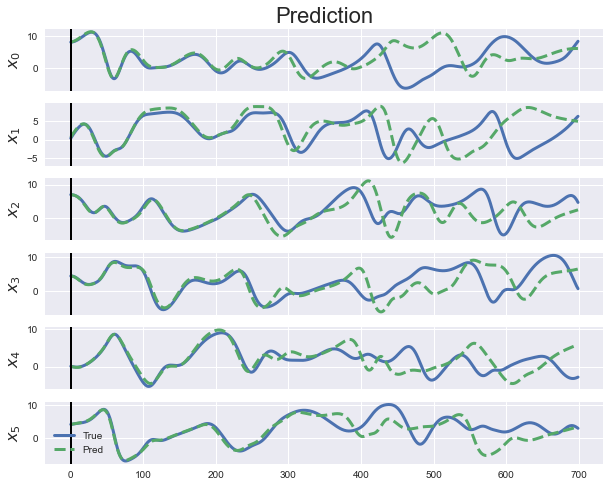

In [17]:
loss(opt.x, train_data, [valid_data_arr[vidx]], plot=True, pred_time=7)

7.7232527321045

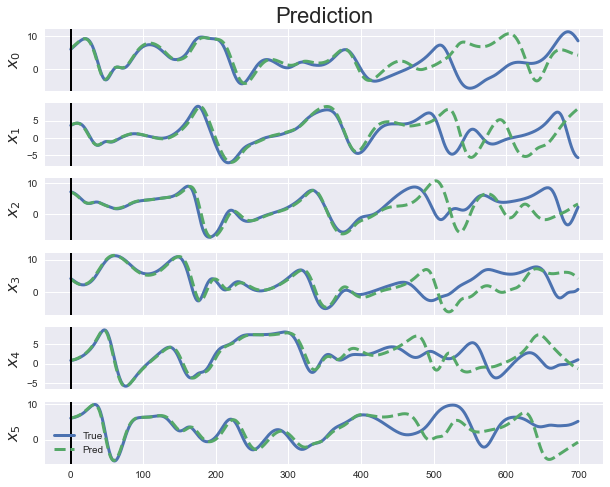

In [18]:
loss(opt.x, train_data, [valid_data_arr[4]], plot=True, pred_time=7)

# Now we can look at test data that is not in validation set

10.103528671877315

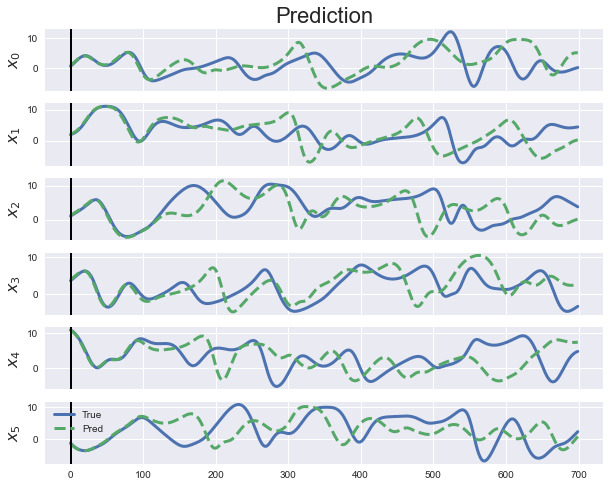

In [19]:
loss(opt.x, train_data, [test_data], plot=True, pred_time=7)